# Checkout the dataset
Dataset: [bbc dataset][def]  
- 根據文章片段，分類該文章是屬於什麼領域的報導
- 總共有五種分類：entertainment, sport, tech, business, politics
- 資料總筆數：2225

我們可以從下方圖表得知：  
* 此資料集有五種類別，即是等等 BERT 判斷分類的 Label  
* 而每筆 Text 就是 BERT 的 input 資料

目的就是判斷此 Text 的類別 (Label) 是什麼  

[def]: https://www.kaggle.com/datasets/sainijagjit/bbc-dataset

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

datapath = 'bbc-text.csv'
df = pd.read_csv(datapath)
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


<Axes: xlabel='category'>

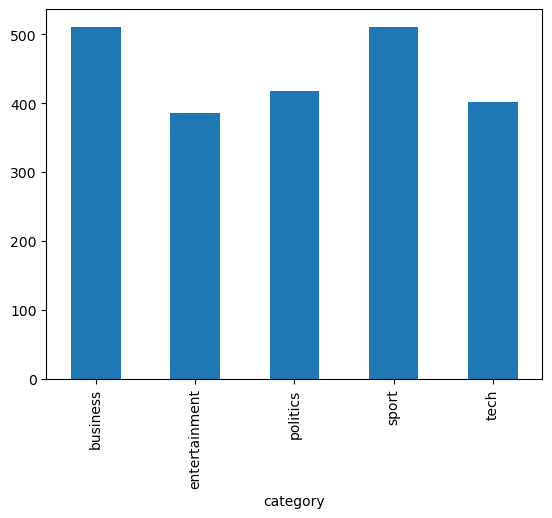

In [45]:
df.groupby(['category']).size().plot.bar()

# Preprocessing Data (資料前處理)

## 1. BertTokenizer
[**BertTokenizer**](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer):
以 Word-based 的方式做 Tokenization，並加上 \[CLS\]、\[SEP\]、\[PAD\] 這三個特殊 token  
使用方式為： ```BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)```   
其中，```PRETRAINED_MODEL_NAME``` 可依需求尋找適合任務的預訓練模型 ([可用模型總攬](https://huggingface.co/models))  
本例子使用常見的英文模型 ```'bert-base-cased'```

BertTokenizer 繼承於 [PreTrainedTokenizer](https://huggingface.co/docs/transformers/v4.23.1/en/main_classes/tokenizer#transformers.PreTrainedTokenizer)，其中較常使用的參數如下：

* ```text``` / ```text_pair ```: 要做 Tokenize 的序列 / 要做 Tokenize 的一對序列
* ```padding```: 選擇要不要補 padding (\[PAD\])  
  * ```True``` or ```'longest'```: 做 padding 直到序列長度等於 batch 中最長的序列
  * ```'max_length'```: padding 直到設定的值 'max_length'
  * ```False``` or ```'do_not_pad'```: 不做 padding
* ```max_length```: 設定序列的最長長度 (BERT 中是 512) 
* ```truncation```: 若序列(序列對)長度總和大於上限，是否截斷序列
  * ```True``` or ```'longest_first'```: 以迭代的方式，從最長的序列開始慢慢截斷。  
    ex:  
    seq1 = "a b c", seq2 = "d e", max_length = 2。因為 len(seq1) + len(seq2) > 2，需要要做截斷  
    (註：這邊先忽略 \[CLS\]、\[SEP\]、\[PAD\] 這些 Token)  
    迭代1：seq1 = "a b", seq2 = "d e"  
    迭代2：seq1 = "a", seq2 = "d e"  
    迭代3：seq1 = "a", seq2 = "d" => 最後輸出 "a d"  
  * ```'only_first'```: 只截斷一對序列對中的第一個序列
  * ```'only_second'```: 只截斷一對序列對中的第二個序列
  * ```False``` or ```'do_not_truncate'```: 不做截斷
* ```return_tensors```: 決定回傳張量的資料型態
  * ```'tf'```: TensorFlow tf.constant.
  * ```'pt'```: PyTorch torch.Tensor.
  * ```'np'```: Numpy np.ndarray.

In [46]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text1 = 'I am practicing using Bert Model'
example_text2 = 'I am trying'
bert_input = tokenizer(example_text1, padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")
bert_input2 = tokenizer(example_text1,example_text2, padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


`BertTokenizer` 的輸出 (這邊為 `bert_input`) 有三種：
* `input_ids`: 輸出每個 token 代表的數字代號  
    (其中 \[CLS\] = 101, \[SEP\] = 102, \[PAD\] = 0)
* `token_type_ids`: 輸出每個 token 是屬於序列對中的哪一個序列，用 0、1 表示  
    (如果輸入序列只有一個，那每個 token 都是 0)
    (啊簡單來說就是讓 BERT 知道 Token 屬於哪個句子)
* `attention_mask`: 判斷各個 token 是原句資訊還是 padding  
    如果該 token 是 真實的字、\[CLS\]、\[SEP\]：輸出 1  
    如果該 token 是 \[PAD\]：輸出 0

In [47]:
print("Sequence: ", example_text1)
print("input_ids: ",bert_input['input_ids'])
print("token_type_ids: ", bert_input['token_type_ids'])
print("attention_mask: ", bert_input['attention_mask'])

example_text1_decode = tokenizer.decode(bert_input.input_ids[0])

print("decode: ",example_text1_decode)
print("-----------------------------------------------------------")
print("Sequence1: ", example_text1)
print("Sequence2: ", example_text2)
print("input_ids: ",bert_input2['input_ids'])
print("token_type_ids: ", bert_input2['token_type_ids'])
print("attention_mask: ", bert_input2['attention_mask'])

example_text2_decode = tokenizer.decode(bert_input2.input_ids[0])

print("decode: ",example_text2_decode)

Sequence:  I am practicing using Bert Model
input_ids:  tensor([[  101,   146,  1821, 13029,  1606, 15035,  6747,   102,     0,     0]])
token_type_ids:  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask:  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])
decode:  [CLS] I am practicing using Bert Model [SEP] [PAD] [PAD]
-----------------------------------------------------------
Sequence1:  I am practicing using Bert Model
Sequence2:  I am trying
input_ids:  tensor([[  101,   146,  1821, 13029,  1606,   102,   146,  1821,  1774,   102]])
token_type_ids:  tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]])
attention_mask:  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
decode:  [CLS] I am practicing using [SEP] I am trying [SEP]


## 2. Data Class
1. 決定要用什麼模型的 tokenizer  
2. 給定對應到 Dataset 類別的標籤 (labels)，即將資料集中的各類別對應到 id (數值)  
   這邊將 ```'business'```, ```'entertainment'```, ```'sport'```, ```'tech'```, ```'politics'``` 對應到 0 ~ 4，
3. 初始化 Dataset 時：
   - 各筆資料的分類 (category) 轉換成 id
   - 再把資料集丟進 BertTokenizer，轉換成 BERT 可以使用的格式

In [48]:
import torch
import numpy as np
from transformers import BertTokenizer

# 決定 tokenizer 類型
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# 決定資料集中各分類對應的 id
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

# 資料集處理
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        # 把每一筆資料的類別改成 id
        self.labels = [labels[label] for label in df['category']]  
        # 對每筆資料做 BERT tokenize
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    # 回傳資料集各類別 (id)
    def classes(self):
        return self.labels

    # 回傳該 label 的資料數
    def __len__(self):
        return len(self.labels)

    # 取得當前資料的 label
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    # 取得當前資料的 text
    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

切分 訓練 (training)、驗證 (validation)、測試 (testing) 資料集   
這邊切分比例為 80:10:10  

註：
1. ```df.sample(frac=1, random_state=42)```：從 dataframe 隨機取樣  
   ```frac```：要抽取 dataframe 的比例 (0 ~ 1)  
   ```random_state```：隨機的狀態，可以想樣乘亂數表的位置 (？)  
2. ```np.split(..., [int(.8*len(df)), int(.9*len(df))])```：把陣列做分割  
   上述第二個參數的 list，代表分別取道的相對位置，分割個數 = 該 list 的長度，以本例子來說：  
   第一區塊：```int(.8*len(df))```：取到 df 的 80 % => 分割的第一組陣列是 0% ~ 80% 的 df  
   第二區塊：```int(.9*len(df))```：取到 df 的 90 % => 分割的第一組陣列是 80% ~ 90% 的 df  
   第三區塊：分割的第一組陣列是 90% ~ 100% 的 df  

In [49]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1780 222 223


# Model Building
[**BertModel**](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel)：主要是 transformer 的 Encoder 部分  
繼承於 [PreTrainedModel](https://huggingface.co/docs/transformers/v4.23.1/en/main_classes/model#transformers.PreTrainedModel)，在 ```forward```中較常使用的參數如下：  
* ```input_ids```: 輸入序列  
* ```attention_mask```: 輸入序列對應的 mask，以告知 attention 略過他們  
  1: 該 token 是 真實的字、\[CLS\]、\[SEP\]  
  0: 該 token 是 \[PAD\]，即要被 mask 掉的部分
* ```return_dict ```: True: 回傳值是 [ModelOutput](https://huggingface.co/docs/transformers/v4.23.1/en/main_classes/output#transformers.utils.ModelOutput)；False: 回傳值是 tuple

若 ```return_dict = True```，BertModel 的輸出為 [transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions](https://huggingface.co/docs/transformers/v4.23.1/en/main_classes/output#transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions)  
而範例中，```return_dict = False```，BertModel 的輸出為 ```tuple(torch.FloatTensor)```，範例以 ```_``` 與 ```pooled_output``` 表示：
* ```_```: sequence output，為序列在 BERT 最後一層 hidden layer 的輸出
* ```pooled_output```: 取出 BERT 最後一層 layer中，\[CLS\] 對應的向量 (vector)  
由上可知，BERT 可以處理序列任務 (如輸出```_```) 及 分類、迴歸分析任務 (如輸出```pooled_output```)

我們把 ```pooled_output``` 經過 dropout、線性轉換、ReLU 激活函數後，我們在最後的線性層可以得到維度為 5 的向量，代表著我們資料及的分類 (sport, business, politics, entertainment, and tech)

In [50]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5, path = "", pretrained_model = ""):
        super(BertClassifier, self).__init__()                      # 繼承 nn.Module

        self.bert = BertModel.from_pretrained(pretrained_model)    # 選擇 Model
        self.dropout = nn.Dropout(dropout)                          # dropout = 0.5 => 去掉 50% neural，避免 overfitting
        self.linear = nn.Linear(768, 5)                             # BERT Base size: 768，每句有 5 種可能的分類要做選擇  
        self.relu = nn.ReLU()
        self.path = path

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer
    
    def save_model(self):
        self.bert.save_pretrained(self.path)
    

# Training Loop
* Epoch: 4
* Loss Function: Categorical cross entropy (因為要做複數類別分類)
* Optimizer: Adam
* Learning Rate: 10<sup>-6</sup> (1e-6)

In [51]:
from torch.optim import Adam
from tqdm import tqdm
import os

def train(model, train_data, val_data, learning_rate, epochs, model_name):

    if os.path.isfile("fine_tune_record_epoch.csv"):
        rec = pd.read_csv("fine_tune_record_epoch.csv")
    else:
        rec = pd.DataFrame({"model_name":[], "train_acc":[], "train_loss":[], "val_acc":[], "val_loss":[]})

    # 把原本的資料經過 Dataset 類別包裝起來
    train, val = Dataset(train_data), Dataset(val_data)

    # 把訓練、驗證資料集丟進 Dataloader 定義取樣資訊 (ex: 設定 batch_size...等等)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=8)

    # 偵測有 GPU，有就用
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()                       # Loss Function: Categorical cross entropy
    optimizer = Adam(model.parameters(), lr= learning_rate) # Optimizer: Adam

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()
    
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    # 每次完整訓練 (每個 epoch) 要做的事
    for epoch_num in range(epochs):

            # ---------- 訓練的部分 ----------
            total_acc_train = 0
            total_loss_train = 0

            # 這邊加上 tqdm 模組來顯示 dataloader 處理進度條
            # 所以在程式意義上，可以直接把這行當作 for train_input, train_label in train_dataloader:
            for train_input, train_label in tqdm(train_dataloader):

                # .to(device): 把東西 (tensor) 丟到 GPU 的概念
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                # 把 data 丟進 BERT
                output = model(input_id, mask)
                
                # 計算 Cross Entropy，以此計算 loss
                batch_loss = criterion(output, train_label.long())  # 參數解釋：(模型的輸出, 原本預計的輸出)
                total_loss_train += batch_loss.item()               # .item(): tensor 轉 純量
                
                # 看 model output "可能性最高" 的 label 是不是和 data 一樣，是的話，acc + 1
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()       # 清空前一次 Gradient
                batch_loss.backward()   # 根據 lost 計算 back propagation
                optimizer.step()        # 做 Gradient Decent
            
            # ---------- 驗證的部分 ----------
            total_acc_val = 0
            total_loss_val = 0

            # 步驟和訓練時差不多，差在沒做 Gradient Decent
            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            train_loss.append(total_loss_train / len(train_data))
            train_acc.append(total_acc_train / len(train_data))
            val_loss.append(total_loss_val / len(val_data))
            val_acc.append(total_acc_val / len(val_data))
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
    
    new_rec = pd.concat([rec, pd.DataFrame(pd.DataFrame({'model_name': model_name, 'train_acc': [train_acc], 'train_loss': [train_loss], 'val_acc': [val_acc], 'val_loss': [val_loss]}))], ignore_index=True)
    new_rec.to_csv("fine_tune_record_epoch.csv", index = None)
    model.save_model()

# mask_purpose

In [9]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:07<00:00,  3.29it/s]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.223                 | Val Loss:  0.207                 | Val Accuracy:  0.216


100%|██████████| 223/223 [01:12<00:00,  3.09it/s]


Epochs: 2 | Train Loss:  0.200                 | Train Accuracy:  0.252                 | Val Loss:  0.203                 | Val Accuracy:  0.225


100%|██████████| 223/223 [01:16<00:00,  2.93it/s]


Epochs: 3 | Train Loss:  0.188                 | Train Accuracy:  0.361                 | Val Loss:  0.169                 | Val Accuracy:  0.581


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.141                 | Train Accuracy:  0.652                 | Val Loss:  0.111                 | Val Accuracy:  0.770


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 5 | Train Loss:  0.097                 | Train Accuracy:  0.819                 | Val Loss:  0.079                 | Val Accuracy:  0.883


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 6 | Train Loss:  0.069                 | Train Accuracy:  0.938                 | Val Loss:  0.060                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 7 | Train Loss:  0.049                 | Train Accuracy:  0.970                 | Val Loss:  0.039                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 8 | Train Loss:  0.035                 | Train Accuracy:  0.981                 | Val Loss:  0.032                 | Val Accuracy:  0.968


In [10]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.216                 | Val Loss:  0.205                 | Val Accuracy:  0.180


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  0.196                 | Train Accuracy:  0.298                 | Val Loss:  0.190                 | Val Accuracy:  0.351


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.162                 | Train Accuracy:  0.545                 | Val Loss:  0.132                 | Val Accuracy:  0.703


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.109                 | Train Accuracy:  0.809                 | Val Loss:  0.091                 | Val Accuracy:  0.878


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 5 | Train Loss:  0.079                 | Train Accuracy:  0.905                 | Val Loss:  0.068                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.057                 | Train Accuracy:  0.946                 | Val Loss:  0.047                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.040                 | Train Accuracy:  0.962                 | Val Loss:  0.031                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.027                 | Train Accuracy:  0.978                 | Val Loss:  0.023                 | Val Accuracy:  0.977


In [11]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 1 | Train Loss:  0.203                 | Train Accuracy:  0.249                 | Val Loss:  0.202                 | Val Accuracy:  0.257


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.193                 | Train Accuracy:  0.324                 | Val Loss:  0.188                 | Val Accuracy:  0.387


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  0.174                 | Train Accuracy:  0.475                 | Val Loss:  0.162                 | Val Accuracy:  0.572


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 4 | Train Loss:  0.145                 | Train Accuracy:  0.648                 | Val Loss:  0.116                 | Val Accuracy:  0.811


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  0.091                 | Train Accuracy:  0.876                 | Val Loss:  0.065                 | Val Accuracy:  0.937


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 6 | Train Loss:  0.055                 | Train Accuracy:  0.955                 | Val Loss:  0.044                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 7 | Train Loss:  0.036                 | Train Accuracy:  0.974                 | Val Loss:  0.032                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 8 | Train Loss:  0.025                 | Train Accuracy:  0.983                 | Val Loss:  0.022                 | Val Accuracy:  0.968


In [12]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 1 | Train Loss:  0.210                 | Train Accuracy:  0.233                 | Val Loss:  0.201                 | Val Accuracy:  0.288


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  0.190                 | Train Accuracy:  0.323                 | Val Loss:  0.175                 | Val Accuracy:  0.441


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.158                 | Train Accuracy:  0.511                 | Val Loss:  0.129                 | Val Accuracy:  0.689


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.110                 | Train Accuracy:  0.754                 | Val Loss:  0.088                 | Val Accuracy:  0.856


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.079                 | Train Accuracy:  0.887                 | Val Loss:  0.069                 | Val Accuracy:  0.923


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.058                 | Train Accuracy:  0.955                 | Val Loss:  0.051                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.043                 | Train Accuracy:  0.980                 | Val Loss:  0.037                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.031                 | Train Accuracy:  0.988                 | Val Loss:  0.028                 | Val Accuracy:  0.982


In [13]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.94it/s]


Epochs: 1 | Train Loss:  0.218                 | Train Accuracy:  0.197                 | Val Loss:  0.211                 | Val Accuracy:  0.198


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.203                 | Train Accuracy:  0.244                 | Val Loss:  0.190                 | Val Accuracy:  0.369


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.184                 | Train Accuracy:  0.360                 | Val Loss:  0.160                 | Val Accuracy:  0.505


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.139                 | Train Accuracy:  0.658                 | Val Loss:  0.112                 | Val Accuracy:  0.847


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.087                 | Train Accuracy:  0.901                 | Val Loss:  0.063                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.054                 | Train Accuracy:  0.957                 | Val Loss:  0.043                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.036                 | Train Accuracy:  0.981                 | Val Loss:  0.030                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.025                 | Train Accuracy:  0.990                 | Val Loss:  0.023                 | Val Accuracy:  0.977


# mask_purpose_E2

In [14]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E2", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E2")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.94it/s]


Epochs: 1 | Train Loss:  0.200                 | Train Accuracy:  0.274                 | Val Loss:  0.197                 | Val Accuracy:  0.324


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.189                 | Train Accuracy:  0.376                 | Val Loss:  0.186                 | Val Accuracy:  0.423


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.165                 | Train Accuracy:  0.504                 | Val Loss:  0.145                 | Val Accuracy:  0.559


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 4 | Train Loss:  0.114                 | Train Accuracy:  0.728                 | Val Loss:  0.092                 | Val Accuracy:  0.770


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.079                 | Train Accuracy:  0.793                 | Val Loss:  0.071                 | Val Accuracy:  0.793


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.064                 | Train Accuracy:  0.806                 | Val Loss:  0.062                 | Val Accuracy:  0.797


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.055                 | Train Accuracy:  0.813                 | Val Loss:  0.056                 | Val Accuracy:  0.797


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.050                 | Train Accuracy:  0.821                 | Val Loss:  0.052                 | Val Accuracy:  0.815


In [15]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E2", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E2")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.94it/s]


Epochs: 1 | Train Loss:  0.210                 | Train Accuracy:  0.199                 | Val Loss:  0.204                 | Val Accuracy:  0.225


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  0.201                 | Train Accuracy:  0.228                 | Val Loss:  0.192                 | Val Accuracy:  0.333


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  0.156                 | Train Accuracy:  0.582                 | Val Loss:  0.117                 | Val Accuracy:  0.725


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 4 | Train Loss:  0.088                 | Train Accuracy:  0.870                 | Val Loss:  0.062                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 5 | Train Loss:  0.050                 | Train Accuracy:  0.965                 | Val Loss:  0.039                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  0.032                 | Train Accuracy:  0.979                 | Val Loss:  0.026                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  0.023                 | Train Accuracy:  0.985                 | Val Loss:  0.020                 | Val Accuracy:  0.986


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 8 | Train Loss:  0.017                 | Train Accuracy:  0.988                 | Val Loss:  0.015                 | Val Accuracy:  0.986


In [16]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E2", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E2")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.94it/s]


Epochs: 1 | Train Loss:  0.211                 | Train Accuracy:  0.180                 | Val Loss:  0.204                 | Val Accuracy:  0.234


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  0.199                 | Train Accuracy:  0.269                 | Val Loss:  0.189                 | Val Accuracy:  0.392


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  0.163                 | Train Accuracy:  0.525                 | Val Loss:  0.126                 | Val Accuracy:  0.698


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 4 | Train Loss:  0.111                 | Train Accuracy:  0.738                 | Val Loss:  0.086                 | Val Accuracy:  0.824


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 5 | Train Loss:  0.071                 | Train Accuracy:  0.884                 | Val Loss:  0.046                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  0.041                 | Train Accuracy:  0.971                 | Val Loss:  0.032                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  0.027                 | Train Accuracy:  0.980                 | Val Loss:  0.023                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 8 | Train Loss:  0.020                 | Train Accuracy:  0.985                 | Val Loss:  0.019                 | Val Accuracy:  0.968


In [17]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E2", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E2")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 1 | Train Loss:  0.199                 | Train Accuracy:  0.265                 | Val Loss:  0.193                 | Val Accuracy:  0.297


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  0.167                 | Train Accuracy:  0.488                 | Val Loss:  0.151                 | Val Accuracy:  0.559


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.129                 | Train Accuracy:  0.643                 | Val Loss:  0.123                 | Val Accuracy:  0.653


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 4 | Train Loss:  0.104                 | Train Accuracy:  0.703                 | Val Loss:  0.101                 | Val Accuracy:  0.703


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.083                 | Train Accuracy:  0.800                 | Val Loss:  0.079                 | Val Accuracy:  0.811


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.049                 | Train Accuracy:  0.948                 | Val Loss:  0.040                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 7 | Train Loss:  0.029                 | Train Accuracy:  0.983                 | Val Loss:  0.028                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 8 | Train Loss:  0.022                 | Train Accuracy:  0.990                 | Val Loss:  0.021                 | Val Accuracy:  0.982


In [18]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E2", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E2")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.227                 | Val Loss:  0.201                 | Val Accuracy:  0.306


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.182                 | Train Accuracy:  0.425                 | Val Loss:  0.161                 | Val Accuracy:  0.495


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.148                 | Train Accuracy:  0.559                 | Val Loss:  0.131                 | Val Accuracy:  0.617


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.127                 | Train Accuracy:  0.634                 | Val Loss:  0.114                 | Val Accuracy:  0.667


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.099                 | Train Accuracy:  0.768                 | Val Loss:  0.085                 | Val Accuracy:  0.820


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.053                 | Train Accuracy:  0.939                 | Val Loss:  0.038                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 7 | Train Loss:  0.028                 | Train Accuracy:  0.976                 | Val Loss:  0.024                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 8 | Train Loss:  0.019                 | Train Accuracy:  0.983                 | Val Loss:  0.018                 | Val Accuracy:  0.964


# mask_purpose_E4

In [64]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E4", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E4")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.201                 | Train Accuracy:  0.256                 | Val Loss:  0.192                 | Val Accuracy:  0.329


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.178                 | Train Accuracy:  0.427                 | Val Loss:  0.163                 | Val Accuracy:  0.554


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  0.138                 | Train Accuracy:  0.647                 | Val Loss:  0.119                 | Val Accuracy:  0.752


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 4 | Train Loss:  0.093                 | Train Accuracy:  0.847                 | Val Loss:  0.078                 | Val Accuracy:  0.878


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 5 | Train Loss:  0.060                 | Train Accuracy:  0.943                 | Val Loss:  0.051                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 6 | Train Loss:  0.040                 | Train Accuracy:  0.970                 | Val Loss:  0.036                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 7 | Train Loss:  0.028                 | Train Accuracy:  0.981                 | Val Loss:  0.029                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 8 | Train Loss:  0.020                 | Train Accuracy:  0.987                 | Val Loss:  0.020                 | Val Accuracy:  0.973


In [65]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E4", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E4")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.97it/s]


Epochs: 1 | Train Loss:  0.201                 | Train Accuracy:  0.237                 | Val Loss:  0.204                 | Val Accuracy:  0.207


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.197                 | Train Accuracy:  0.284                 | Val Loss:  0.200                 | Val Accuracy:  0.270


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  0.183                 | Train Accuracy:  0.393                 | Val Loss:  0.168                 | Val Accuracy:  0.455


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 4 | Train Loss:  0.147                 | Train Accuracy:  0.532                 | Val Loss:  0.131                 | Val Accuracy:  0.599


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 5 | Train Loss:  0.113                 | Train Accuracy:  0.715                 | Val Loss:  0.079                 | Val Accuracy:  0.892


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 6 | Train Loss:  0.059                 | Train Accuracy:  0.938                 | Val Loss:  0.041                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 7 | Train Loss:  0.034                 | Train Accuracy:  0.973                 | Val Loss:  0.028                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 8 | Train Loss:  0.023                 | Train Accuracy:  0.983                 | Val Loss:  0.020                 | Val Accuracy:  0.982


In [66]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E4", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E4")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.227                 | Val Loss:  0.202                 | Val Accuracy:  0.230


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.194                 | Train Accuracy:  0.297                 | Val Loss:  0.187                 | Val Accuracy:  0.410


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  0.178                 | Train Accuracy:  0.384                 | Val Loss:  0.167                 | Val Accuracy:  0.468


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 4 | Train Loss:  0.155                 | Train Accuracy:  0.523                 | Val Loss:  0.135                 | Val Accuracy:  0.572


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 5 | Train Loss:  0.121                 | Train Accuracy:  0.639                 | Val Loss:  0.104                 | Val Accuracy:  0.752


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 6 | Train Loss:  0.088                 | Train Accuracy:  0.819                 | Val Loss:  0.063                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 7 | Train Loss:  0.049                 | Train Accuracy:  0.953                 | Val Loss:  0.036                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 8 | Train Loss:  0.030                 | Train Accuracy:  0.975                 | Val Loss:  0.025                 | Val Accuracy:  0.973


In [67]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E4", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E4")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.246                 | Val Loss:  0.199                 | Val Accuracy:  0.275


100%|██████████| 223/223 [01:18<00:00,  2.82it/s]


Epochs: 2 | Train Loss:  0.176                 | Train Accuracy:  0.456                 | Val Loss:  0.161                 | Val Accuracy:  0.550


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.138                 | Train Accuracy:  0.621                 | Val Loss:  0.114                 | Val Accuracy:  0.707


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.096                 | Train Accuracy:  0.769                 | Val Loss:  0.079                 | Val Accuracy:  0.811


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.060                 | Train Accuracy:  0.910                 | Val Loss:  0.043                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.035                 | Train Accuracy:  0.978                 | Val Loss:  0.029                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 7 | Train Loss:  0.024                 | Train Accuracy:  0.988                 | Val Loss:  0.022                 | Val Accuracy:  0.986


100%|██████████| 223/223 [01:23<00:00,  2.67it/s]


Epochs: 8 | Train Loss:  0.017                 | Train Accuracy:  0.994                 | Val Loss:  0.017                 | Val Accuracy:  0.982


In [68]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E4", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E4")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:11<00:00,  3.12it/s]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.239                 | Val Loss:  0.194                 | Val Accuracy:  0.338


100%|██████████| 223/223 [01:13<00:00,  3.04it/s]


Epochs: 2 | Train Loss:  0.181                 | Train Accuracy:  0.422                 | Val Loss:  0.169                 | Val Accuracy:  0.500


100%|██████████| 223/223 [01:20<00:00,  2.79it/s]


Epochs: 3 | Train Loss:  0.147                 | Train Accuracy:  0.626                 | Val Loss:  0.123                 | Val Accuracy:  0.730


100%|██████████| 223/223 [01:25<00:00,  2.62it/s]


Epochs: 4 | Train Loss:  0.103                 | Train Accuracy:  0.794                 | Val Loss:  0.085                 | Val Accuracy:  0.833


100%|██████████| 223/223 [01:25<00:00,  2.62it/s]


Epochs: 5 | Train Loss:  0.070                 | Train Accuracy:  0.897                 | Val Loss:  0.055                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:25<00:00,  2.62it/s]


Epochs: 6 | Train Loss:  0.045                 | Train Accuracy:  0.968                 | Val Loss:  0.035                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:25<00:00,  2.61it/s]


Epochs: 7 | Train Loss:  0.030                 | Train Accuracy:  0.981                 | Val Loss:  0.027                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:25<00:00,  2.62it/s]


Epochs: 8 | Train Loss:  0.022                 | Train Accuracy:  0.989                 | Val Loss:  0.019                 | Val Accuracy:  0.982


# mask_purpose_E6

In [69]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E6", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E6")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:07<00:00,  3.29it/s]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.240                 | Val Loss:  0.199                 | Val Accuracy:  0.284


100%|██████████| 223/223 [01:11<00:00,  3.12it/s]


Epochs: 2 | Train Loss:  0.195                 | Train Accuracy:  0.315                 | Val Loss:  0.189                 | Val Accuracy:  0.351


100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 3 | Train Loss:  0.170                 | Train Accuracy:  0.472                 | Val Loss:  0.145                 | Val Accuracy:  0.613


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.115                 | Train Accuracy:  0.734                 | Val Loss:  0.091                 | Val Accuracy:  0.829


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 5 | Train Loss:  0.076                 | Train Accuracy:  0.863                 | Val Loss:  0.064                 | Val Accuracy:  0.892


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 6 | Train Loss:  0.049                 | Train Accuracy:  0.943                 | Val Loss:  0.042                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 7 | Train Loss:  0.034                 | Train Accuracy:  0.970                 | Val Loss:  0.032                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 8 | Train Loss:  0.024                 | Train Accuracy:  0.986                 | Val Loss:  0.024                 | Val Accuracy:  0.973


In [70]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E6", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E6")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.93it/s]


Epochs: 1 | Train Loss:  0.201                 | Train Accuracy:  0.262                 | Val Loss:  0.192                 | Val Accuracy:  0.311


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  0.188                 | Train Accuracy:  0.331                 | Val Loss:  0.178                 | Val Accuracy:  0.405


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.165                 | Train Accuracy:  0.449                 | Val Loss:  0.155                 | Val Accuracy:  0.527


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.127                 | Train Accuracy:  0.666                 | Val Loss:  0.083                 | Val Accuracy:  0.883


100%|██████████| 223/223 [01:17<00:00,  2.90it/s]


Epochs: 5 | Train Loss:  0.061                 | Train Accuracy:  0.937                 | Val Loss:  0.043                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.034                 | Train Accuracy:  0.969                 | Val Loss:  0.029                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.023                 | Train Accuracy:  0.979                 | Val Loss:  0.022                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.016                 | Train Accuracy:  0.990                 | Val Loss:  0.018                 | Val Accuracy:  0.973


In [71]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E6", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E6")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 1 | Train Loss:  0.200                 | Train Accuracy:  0.257                 | Val Loss:  0.196                 | Val Accuracy:  0.302


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  0.187                 | Train Accuracy:  0.342                 | Val Loss:  0.180                 | Val Accuracy:  0.428


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 3 | Train Loss:  0.171                 | Train Accuracy:  0.455                 | Val Loss:  0.159                 | Val Accuracy:  0.563


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.134                 | Train Accuracy:  0.696                 | Val Loss:  0.107                 | Val Accuracy:  0.820


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.089                 | Train Accuracy:  0.876                 | Val Loss:  0.073                 | Val Accuracy:  0.910


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.057                 | Train Accuracy:  0.947                 | Val Loss:  0.047                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.039                 | Train Accuracy:  0.974                 | Val Loss:  0.036                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.029                 | Train Accuracy:  0.984                 | Val Loss:  0.028                 | Val Accuracy:  0.968


In [72]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E6", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E6")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.94it/s]


Epochs: 1 | Train Loss:  0.199                 | Train Accuracy:  0.278                 | Val Loss:  0.195                 | Val Accuracy:  0.311


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.180                 | Train Accuracy:  0.407                 | Val Loss:  0.168                 | Val Accuracy:  0.464


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  0.149                 | Train Accuracy:  0.588                 | Val Loss:  0.122                 | Val Accuracy:  0.725


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  0.093                 | Train Accuracy:  0.854                 | Val Loss:  0.065                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  0.055                 | Train Accuracy:  0.950                 | Val Loss:  0.044                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 6 | Train Loss:  0.037                 | Train Accuracy:  0.969                 | Val Loss:  0.031                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  0.025                 | Train Accuracy:  0.981                 | Val Loss:  0.023                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 8 | Train Loss:  0.018                 | Train Accuracy:  0.988                 | Val Loss:  0.020                 | Val Accuracy:  0.968


In [73]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E6", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E6")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 1 | Train Loss:  0.209                 | Train Accuracy:  0.223                 | Val Loss:  0.203                 | Val Accuracy:  0.266


100%|██████████| 223/223 [01:18<00:00,  2.82it/s]


Epochs: 2 | Train Loss:  0.192                 | Train Accuracy:  0.331                 | Val Loss:  0.183                 | Val Accuracy:  0.414


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  0.166                 | Train Accuracy:  0.499                 | Val Loss:  0.149                 | Val Accuracy:  0.626


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 4 | Train Loss:  0.122                 | Train Accuracy:  0.741                 | Val Loss:  0.099                 | Val Accuracy:  0.793


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  0.077                 | Train Accuracy:  0.863                 | Val Loss:  0.057                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  0.043                 | Train Accuracy:  0.967                 | Val Loss:  0.036                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 7 | Train Loss:  0.028                 | Train Accuracy:  0.982                 | Val Loss:  0.027                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 8 | Train Loss:  0.020                 | Train Accuracy:  0.985                 | Val Loss:  0.022                 | Val Accuracy:  0.964


# mask_purpose_E8

In [52]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E8", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E8")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [02:49<00:00,  1.32it/s]


Epochs: 1 | Train Loss:  0.209                 | Train Accuracy:  0.210                 | Val Loss:  0.201                 | Val Accuracy:  0.252


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 2 | Train Loss:  0.195                 | Train Accuracy:  0.289                 | Val Loss:  0.189                 | Val Accuracy:  0.329


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 3 | Train Loss:  0.183                 | Train Accuracy:  0.415                 | Val Loss:  0.176                 | Val Accuracy:  0.495


100%|██████████| 223/223 [01:44<00:00,  2.12it/s]


Epochs: 4 | Train Loss:  0.156                 | Train Accuracy:  0.570                 | Val Loss:  0.137                 | Val Accuracy:  0.667


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 5 | Train Loss:  0.120                 | Train Accuracy:  0.727                 | Val Loss:  0.090                 | Val Accuracy:  0.869


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 6 | Train Loss:  0.068                 | Train Accuracy:  0.926                 | Val Loss:  0.052                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 7 | Train Loss:  0.044                 | Train Accuracy:  0.971                 | Val Loss:  0.039                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 8 | Train Loss:  0.030                 | Train Accuracy:  0.985                 | Val Loss:  0.027                 | Val Accuracy:  0.982


In [37]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E8", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E8")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 1 | Train Loss:  0.205                 | Train Accuracy:  0.245                 | Val Loss:  0.199                 | Val Accuracy:  0.284


100%|██████████| 223/223 [01:20<00:00,  2.77it/s]


Epochs: 2 | Train Loss:  0.180                 | Train Accuracy:  0.412                 | Val Loss:  0.172                 | Val Accuracy:  0.482


100%|██████████| 223/223 [01:19<00:00,  2.80it/s]


Epochs: 3 | Train Loss:  0.160                 | Train Accuracy:  0.556                 | Val Loss:  0.151                 | Val Accuracy:  0.604


100%|██████████| 223/223 [01:19<00:00,  2.82it/s]


Epochs: 4 | Train Loss:  0.137                 | Train Accuracy:  0.656                 | Val Loss:  0.133                 | Val Accuracy:  0.680


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  0.110                 | Train Accuracy:  0.790                 | Val Loss:  0.101                 | Val Accuracy:  0.851


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 6 | Train Loss:  0.080                 | Train Accuracy:  0.913                 | Val Loss:  0.058                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  0.051                 | Train Accuracy:  0.960                 | Val Loss:  0.040                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 8 | Train Loss:  0.037                 | Train Accuracy:  0.981                 | Val Loss:  0.031                 | Val Accuracy:  0.982


In [11]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E8", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E8")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  0.203                 | Train Accuracy:  0.248                 | Val Loss:  0.198                 | Val Accuracy:  0.297


100%|██████████| 223/223 [01:21<00:00,  2.75it/s]


Epochs: 2 | Train Loss:  0.189                 | Train Accuracy:  0.337                 | Val Loss:  0.181                 | Val Accuracy:  0.428


100%|██████████| 223/223 [01:20<00:00,  2.78it/s]


Epochs: 3 | Train Loss:  0.175                 | Train Accuracy:  0.456                 | Val Loss:  0.159                 | Val Accuracy:  0.577


100%|██████████| 223/223 [01:19<00:00,  2.80it/s]


Epochs: 4 | Train Loss:  0.144                 | Train Accuracy:  0.651                 | Val Loss:  0.133                 | Val Accuracy:  0.671


100%|██████████| 223/223 [01:20<00:00,  2.79it/s]


Epochs: 5 | Train Loss:  0.112                 | Train Accuracy:  0.797                 | Val Loss:  0.089                 | Val Accuracy:  0.892


100%|██████████| 223/223 [01:19<00:00,  2.80it/s]


Epochs: 6 | Train Loss:  0.072                 | Train Accuracy:  0.928                 | Val Loss:  0.051                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:19<00:00,  2.80it/s]


Epochs: 7 | Train Loss:  0.042                 | Train Accuracy:  0.975                 | Val Loss:  0.034                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:19<00:00,  2.81it/s]


Epochs: 8 | Train Loss:  0.026                 | Train Accuracy:  0.986                 | Val Loss:  0.024                 | Val Accuracy:  0.973


In [12]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E8", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E8")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.212                 | Val Loss:  0.208                 | Val Accuracy:  0.167


100%|██████████| 223/223 [01:20<00:00,  2.77it/s]


Epochs: 2 | Train Loss:  0.199                 | Train Accuracy:  0.266                 | Val Loss:  0.200                 | Val Accuracy:  0.248


100%|██████████| 223/223 [01:20<00:00,  2.77it/s]


Epochs: 3 | Train Loss:  0.188                 | Train Accuracy:  0.353                 | Val Loss:  0.180                 | Val Accuracy:  0.405


100%|██████████| 223/223 [01:20<00:00,  2.78it/s]


Epochs: 4 | Train Loss:  0.165                 | Train Accuracy:  0.476                 | Val Loss:  0.148                 | Val Accuracy:  0.581


100%|██████████| 223/223 [01:19<00:00,  2.79it/s]


Epochs: 5 | Train Loss:  0.137                 | Train Accuracy:  0.603                 | Val Loss:  0.118                 | Val Accuracy:  0.730


100%|██████████| 223/223 [01:19<00:00,  2.80it/s]


Epochs: 6 | Train Loss:  0.105                 | Train Accuracy:  0.760                 | Val Loss:  0.085                 | Val Accuracy:  0.820


100%|██████████| 223/223 [01:19<00:00,  2.81it/s]


Epochs: 7 | Train Loss:  0.082                 | Train Accuracy:  0.794                 | Val Loss:  0.068                 | Val Accuracy:  0.833


100%|██████████| 223/223 [01:19<00:00,  2.82it/s]


Epochs: 8 | Train Loss:  0.067                 | Train Accuracy:  0.816                 | Val Loss:  0.056                 | Val Accuracy:  0.865


In [33]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_E8", pretrained_model = 'saved_model/saved_model_mask_purpose_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_E8")

Some weights of the model checkpoint at saved_model/saved_model_mask_purpose_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 1 | Train Loss:  0.207                 | Train Accuracy:  0.251                 | Val Loss:  0.205                 | Val Accuracy:  0.275


100%|██████████| 223/223 [01:21<00:00,  2.73it/s]


Epochs: 2 | Train Loss:  0.196                 | Train Accuracy:  0.307                 | Val Loss:  0.193                 | Val Accuracy:  0.342


100%|██████████| 223/223 [01:21<00:00,  2.75it/s]


Epochs: 3 | Train Loss:  0.182                 | Train Accuracy:  0.397                 | Val Loss:  0.168                 | Val Accuracy:  0.509


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 4 | Train Loss:  0.153                 | Train Accuracy:  0.542                 | Val Loss:  0.141                 | Val Accuracy:  0.604


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 5 | Train Loss:  0.122                 | Train Accuracy:  0.685                 | Val Loss:  0.100                 | Val Accuracy:  0.761


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.076                 | Train Accuracy:  0.860                 | Val Loss:  0.054                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 7 | Train Loss:  0.040                 | Train Accuracy:  0.965                 | Val Loss:  0.028                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 8 | Train Loss:  0.025                 | Train Accuracy:  0.976                 | Val Loss:  0.020                 | Val Accuracy:  0.986


# maskPos_purpose

In [19]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:06<00:00,  3.34it/s]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.235                 | Val Loss:  0.199                 | Val Accuracy:  0.270


100%|██████████| 223/223 [01:14<00:00,  3.01it/s]


Epochs: 2 | Train Loss:  0.196                 | Train Accuracy:  0.290                 | Val Loss:  0.182                 | Val Accuracy:  0.396


100%|██████████| 223/223 [01:17<00:00,  2.90it/s]


Epochs: 3 | Train Loss:  0.185                 | Train Accuracy:  0.377                 | Val Loss:  0.181                 | Val Accuracy:  0.423


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 4 | Train Loss:  0.162                 | Train Accuracy:  0.544                 | Val Loss:  0.144                 | Val Accuracy:  0.667


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 5 | Train Loss:  0.123                 | Train Accuracy:  0.764                 | Val Loss:  0.096                 | Val Accuracy:  0.869


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 6 | Train Loss:  0.083                 | Train Accuracy:  0.915                 | Val Loss:  0.071                 | Val Accuracy:  0.946


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 7 | Train Loss:  0.059                 | Train Accuracy:  0.952                 | Val Loss:  0.050                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 8 | Train Loss:  0.041                 | Train Accuracy:  0.978                 | Val Loss:  0.038                 | Val Accuracy:  0.955


In [20]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.246                 | Val Loss:  0.201                 | Val Accuracy:  0.297


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.194                 | Train Accuracy:  0.316                 | Val Loss:  0.188                 | Val Accuracy:  0.378


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.176                 | Train Accuracy:  0.446                 | Val Loss:  0.158                 | Val Accuracy:  0.563


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.148                 | Train Accuracy:  0.607                 | Val Loss:  0.132                 | Val Accuracy:  0.685


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.110                 | Train Accuracy:  0.781                 | Val Loss:  0.097                 | Val Accuracy:  0.851


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.081                 | Train Accuracy:  0.888                 | Val Loss:  0.071                 | Val Accuracy:  0.905


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.059                 | Train Accuracy:  0.948                 | Val Loss:  0.055                 | Val Accuracy:  0.932


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.043                 | Train Accuracy:  0.971                 | Val Loss:  0.042                 | Val Accuracy:  0.937


In [21]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.94it/s]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.202                 | Val Loss:  0.203                 | Val Accuracy:  0.257


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  0.196                 | Train Accuracy:  0.306                 | Val Loss:  0.197                 | Val Accuracy:  0.261


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  0.182                 | Train Accuracy:  0.395                 | Val Loss:  0.176                 | Val Accuracy:  0.464


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 4 | Train Loss:  0.149                 | Train Accuracy:  0.622                 | Val Loss:  0.127                 | Val Accuracy:  0.743


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  0.104                 | Train Accuracy:  0.810                 | Val Loss:  0.091                 | Val Accuracy:  0.833


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  0.073                 | Train Accuracy:  0.908                 | Val Loss:  0.069                 | Val Accuracy:  0.910


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 7 | Train Loss:  0.053                 | Train Accuracy:  0.953                 | Val Loss:  0.046                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:14<00:00,  3.00it/s]


Epochs: 8 | Train Loss:  0.037                 | Train Accuracy:  0.973                 | Val Loss:  0.034                 | Val Accuracy:  0.964


In [22]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.210                 | Val Loss:  0.206                 | Val Accuracy:  0.185


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.201                 | Train Accuracy:  0.233                 | Val Loss:  0.200                 | Val Accuracy:  0.243


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.196                 | Train Accuracy:  0.294                 | Val Loss:  0.196                 | Val Accuracy:  0.275


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.183                 | Train Accuracy:  0.410                 | Val Loss:  0.175                 | Val Accuracy:  0.468


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.154                 | Train Accuracy:  0.598                 | Val Loss:  0.134                 | Val Accuracy:  0.716


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.107                 | Train Accuracy:  0.826                 | Val Loss:  0.077                 | Val Accuracy:  0.910


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.063                 | Train Accuracy:  0.946                 | Val Loss:  0.047                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.037                 | Train Accuracy:  0.970                 | Val Loss:  0.032                 | Val Accuracy:  0.959


In [23]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.222                 | Val Loss:  0.208                 | Val Accuracy:  0.167


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.201                 | Train Accuracy:  0.254                 | Val Loss:  0.200                 | Val Accuracy:  0.257


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.191                 | Train Accuracy:  0.353                 | Val Loss:  0.183                 | Val Accuracy:  0.428


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.164                 | Train Accuracy:  0.564                 | Val Loss:  0.147                 | Val Accuracy:  0.685


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.118                 | Train Accuracy:  0.790                 | Val Loss:  0.099                 | Val Accuracy:  0.856


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.068                 | Train Accuracy:  0.931                 | Val Loss:  0.052                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.041                 | Train Accuracy:  0.969                 | Val Loss:  0.036                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.028                 | Train Accuracy:  0.978                 | Val Loss:  0.029                 | Val Accuracy:  0.964


# maskPos_purpose_E2

In [39]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E2", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E2")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.94it/s]


Epochs: 1 | Train Loss:  0.203                 | Train Accuracy:  0.269                 | Val Loss:  0.198                 | Val Accuracy:  0.306


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.176                 | Train Accuracy:  0.457                 | Val Loss:  0.151                 | Val Accuracy:  0.608


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 3 | Train Loss:  0.130                 | Train Accuracy:  0.692                 | Val Loss:  0.106                 | Val Accuracy:  0.743


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.085                 | Train Accuracy:  0.825                 | Val Loss:  0.064                 | Val Accuracy:  0.883


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.047                 | Train Accuracy:  0.948                 | Val Loss:  0.037                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.029                 | Train Accuracy:  0.978                 | Val Loss:  0.028                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 7 | Train Loss:  0.021                 | Train Accuracy:  0.984                 | Val Loss:  0.023                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.016                 | Train Accuracy:  0.990                 | Val Loss:  0.021                 | Val Accuracy:  0.973


In [40]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E2", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E2")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 1 | Train Loss:  0.209                 | Train Accuracy:  0.216                 | Val Loss:  0.204                 | Val Accuracy:  0.257


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.191                 | Train Accuracy:  0.323                 | Val Loss:  0.166                 | Val Accuracy:  0.559


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 3 | Train Loss:  0.137                 | Train Accuracy:  0.661                 | Val Loss:  0.107                 | Val Accuracy:  0.761


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 4 | Train Loss:  0.089                 | Train Accuracy:  0.820                 | Val Loss:  0.065                 | Val Accuracy:  0.914


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  0.055                 | Train Accuracy:  0.947                 | Val Loss:  0.040                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  0.035                 | Train Accuracy:  0.971                 | Val Loss:  0.030                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  0.025                 | Train Accuracy:  0.981                 | Val Loss:  0.022                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 8 | Train Loss:  0.018                 | Train Accuracy:  0.988                 | Val Loss:  0.019                 | Val Accuracy:  0.977


In [41]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E2", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E2")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 1 | Train Loss:  0.201                 | Train Accuracy:  0.262                 | Val Loss:  0.201                 | Val Accuracy:  0.279


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  0.187                 | Train Accuracy:  0.358                 | Val Loss:  0.170                 | Val Accuracy:  0.423


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 3 | Train Loss:  0.160                 | Train Accuracy:  0.461                 | Val Loss:  0.146                 | Val Accuracy:  0.500


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 4 | Train Loss:  0.131                 | Train Accuracy:  0.601                 | Val Loss:  0.116                 | Val Accuracy:  0.653


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.101                 | Train Accuracy:  0.712                 | Val Loss:  0.090                 | Val Accuracy:  0.761


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.074                 | Train Accuracy:  0.792                 | Val Loss:  0.069                 | Val Accuracy:  0.784


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.060                 | Train Accuracy:  0.810                 | Val Loss:  0.062                 | Val Accuracy:  0.784


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.053                 | Train Accuracy:  0.815                 | Val Loss:  0.056                 | Val Accuracy:  0.797


In [42]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E2", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E2")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.94it/s]


Epochs: 1 | Train Loss:  0.216                 | Train Accuracy:  0.216                 | Val Loss:  0.194                 | Val Accuracy:  0.329


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.177                 | Train Accuracy:  0.431                 | Val Loss:  0.160                 | Val Accuracy:  0.536


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 3 | Train Loss:  0.128                 | Train Accuracy:  0.716                 | Val Loss:  0.104                 | Val Accuracy:  0.811


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 4 | Train Loss:  0.082                 | Train Accuracy:  0.876                 | Val Loss:  0.065                 | Val Accuracy:  0.928


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  0.058                 | Train Accuracy:  0.929                 | Val Loss:  0.051                 | Val Accuracy:  0.937


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  0.043                 | Train Accuracy:  0.960                 | Val Loss:  0.039                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  0.033                 | Train Accuracy:  0.973                 | Val Loss:  0.029                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 8 | Train Loss:  0.025                 | Train Accuracy:  0.985                 | Val Loss:  0.026                 | Val Accuracy:  0.968


In [43]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E2", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E2")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.93it/s]


Epochs: 1 | Train Loss:  0.200                 | Train Accuracy:  0.250                 | Val Loss:  0.203                 | Val Accuracy:  0.234


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  0.193                 | Train Accuracy:  0.317                 | Val Loss:  0.190                 | Val Accuracy:  0.351


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 3 | Train Loss:  0.176                 | Train Accuracy:  0.433                 | Val Loss:  0.170                 | Val Accuracy:  0.455


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 4 | Train Loss:  0.147                 | Train Accuracy:  0.555                 | Val Loss:  0.134                 | Val Accuracy:  0.590


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 5 | Train Loss:  0.114                 | Train Accuracy:  0.720                 | Val Loss:  0.097                 | Val Accuracy:  0.865


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 6 | Train Loss:  0.074                 | Train Accuracy:  0.914                 | Val Loss:  0.059                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 7 | Train Loss:  0.043                 | Train Accuracy:  0.967                 | Val Loss:  0.035                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 8 | Train Loss:  0.027                 | Train Accuracy:  0.984                 | Val Loss:  0.025                 | Val Accuracy:  0.968


# maskPos_purpose_E4

In [59]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E4", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E4")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:07<00:00,  3.31it/s]


Epochs: 1 | Train Loss:  0.200                 | Train Accuracy:  0.274                 | Val Loss:  0.192                 | Val Accuracy:  0.324


100%|██████████| 223/223 [01:11<00:00,  3.12it/s]


Epochs: 2 | Train Loss:  0.186                 | Train Accuracy:  0.376                 | Val Loss:  0.181                 | Val Accuracy:  0.423


100%|██████████| 223/223 [01:14<00:00,  2.98it/s]


Epochs: 3 | Train Loss:  0.171                 | Train Accuracy:  0.467                 | Val Loss:  0.163                 | Val Accuracy:  0.527


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 4 | Train Loss:  0.145                 | Train Accuracy:  0.590                 | Val Loss:  0.134                 | Val Accuracy:  0.676


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 5 | Train Loss:  0.108                 | Train Accuracy:  0.784                 | Val Loss:  0.094                 | Val Accuracy:  0.856


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 6 | Train Loss:  0.073                 | Train Accuracy:  0.908                 | Val Loss:  0.064                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.052                 | Train Accuracy:  0.958                 | Val Loss:  0.047                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.038                 | Train Accuracy:  0.971                 | Val Loss:  0.034                 | Val Accuracy:  0.977


In [60]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E4", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E4")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.93it/s]


Epochs: 1 | Train Loss:  0.198                 | Train Accuracy:  0.268                 | Val Loss:  0.193                 | Val Accuracy:  0.351


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  0.179                 | Train Accuracy:  0.431                 | Val Loss:  0.162                 | Val Accuracy:  0.572


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 3 | Train Loss:  0.143                 | Train Accuracy:  0.643                 | Val Loss:  0.112                 | Val Accuracy:  0.842


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.094                 | Train Accuracy:  0.852                 | Val Loss:  0.072                 | Val Accuracy:  0.937


100%|██████████| 223/223 [01:17<00:00,  2.90it/s]


Epochs: 5 | Train Loss:  0.059                 | Train Accuracy:  0.952                 | Val Loss:  0.046                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.039                 | Train Accuracy:  0.975                 | Val Loss:  0.035                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.029                 | Train Accuracy:  0.981                 | Val Loss:  0.026                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:17<00:00,  2.90it/s]


Epochs: 8 | Train Loss:  0.022                 | Train Accuracy:  0.985                 | Val Loss:  0.023                 | Val Accuracy:  0.959


In [61]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E4", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E4")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.223                 | Val Loss:  0.203                 | Val Accuracy:  0.284


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.187                 | Train Accuracy:  0.369                 | Val Loss:  0.175                 | Val Accuracy:  0.437


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 3 | Train Loss:  0.164                 | Train Accuracy:  0.483                 | Val Loss:  0.153                 | Val Accuracy:  0.559


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 4 | Train Loss:  0.127                 | Train Accuracy:  0.714                 | Val Loss:  0.101                 | Val Accuracy:  0.856


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 5 | Train Loss:  0.086                 | Train Accuracy:  0.892                 | Val Loss:  0.068                 | Val Accuracy:  0.946


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 6 | Train Loss:  0.058                 | Train Accuracy:  0.946                 | Val Loss:  0.050                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 7 | Train Loss:  0.039                 | Train Accuracy:  0.970                 | Val Loss:  0.037                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 8 | Train Loss:  0.030                 | Train Accuracy:  0.981                 | Val Loss:  0.028                 | Val Accuracy:  0.973


In [62]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E4", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E4")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 1 | Train Loss:  0.205                 | Train Accuracy:  0.229                 | Val Loss:  0.200                 | Val Accuracy:  0.252


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  0.189                 | Train Accuracy:  0.340                 | Val Loss:  0.178                 | Val Accuracy:  0.446


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.150                 | Train Accuracy:  0.607                 | Val Loss:  0.127                 | Val Accuracy:  0.725


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.108                 | Train Accuracy:  0.757                 | Val Loss:  0.092                 | Val Accuracy:  0.829


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.079                 | Train Accuracy:  0.849                 | Val Loss:  0.071                 | Val Accuracy:  0.901


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.059                 | Train Accuracy:  0.930                 | Val Loss:  0.050                 | Val Accuracy:  0.946


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 7 | Train Loss:  0.041                 | Train Accuracy:  0.962                 | Val Loss:  0.033                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 8 | Train Loss:  0.027                 | Train Accuracy:  0.981                 | Val Loss:  0.026                 | Val Accuracy:  0.977


In [63]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E4", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E4")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.248                 | Val Loss:  0.203                 | Val Accuracy:  0.239


100%|██████████| 223/223 [01:18<00:00,  2.82it/s]


Epochs: 2 | Train Loss:  0.192                 | Train Accuracy:  0.344                 | Val Loss:  0.181                 | Val Accuracy:  0.446


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 3 | Train Loss:  0.165                 | Train Accuracy:  0.522                 | Val Loss:  0.136                 | Val Accuracy:  0.707


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.111                 | Train Accuracy:  0.817                 | Val Loss:  0.090                 | Val Accuracy:  0.869


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.073                 | Train Accuracy:  0.930                 | Val Loss:  0.061                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 6 | Train Loss:  0.049                 | Train Accuracy:  0.963                 | Val Loss:  0.043                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 7 | Train Loss:  0.034                 | Train Accuracy:  0.974                 | Val Loss:  0.032                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.025                 | Train Accuracy:  0.982                 | Val Loss:  0.024                 | Val Accuracy:  0.977


# maskPos_purpose_E6

In [74]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E6", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E6")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.94it/s]


Epochs: 1 | Train Loss:  0.207                 | Train Accuracy:  0.218                 | Val Loss:  0.201                 | Val Accuracy:  0.266


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.193                 | Train Accuracy:  0.327                 | Val Loss:  0.188                 | Val Accuracy:  0.392


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  0.158                 | Train Accuracy:  0.557                 | Val Loss:  0.128                 | Val Accuracy:  0.734


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  0.117                 | Train Accuracy:  0.725                 | Val Loss:  0.096                 | Val Accuracy:  0.802


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  0.083                 | Train Accuracy:  0.843                 | Val Loss:  0.064                 | Val Accuracy:  0.901


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  0.052                 | Train Accuracy:  0.943                 | Val Loss:  0.042                 | Val Accuracy:  0.946


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  0.034                 | Train Accuracy:  0.967                 | Val Loss:  0.028                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 8 | Train Loss:  0.023                 | Train Accuracy:  0.983                 | Val Loss:  0.022                 | Val Accuracy:  0.982


In [75]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E6", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E6")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 1 | Train Loss:  0.212                 | Train Accuracy:  0.197                 | Val Loss:  0.207                 | Val Accuracy:  0.221


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  0.202                 | Train Accuracy:  0.240                 | Val Loss:  0.199                 | Val Accuracy:  0.225


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.190                 | Train Accuracy:  0.330                 | Val Loss:  0.183                 | Val Accuracy:  0.342


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.155                 | Train Accuracy:  0.526                 | Val Loss:  0.116                 | Val Accuracy:  0.734


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 5 | Train Loss:  0.091                 | Train Accuracy:  0.832                 | Val Loss:  0.075                 | Val Accuracy:  0.896


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.054                 | Train Accuracy:  0.940                 | Val Loss:  0.039                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.033                 | Train Accuracy:  0.974                 | Val Loss:  0.027                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 8 | Train Loss:  0.023                 | Train Accuracy:  0.979                 | Val Loss:  0.022                 | Val Accuracy:  0.982


In [76]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E6", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E6")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.94it/s]


Epochs: 1 | Train Loss:  0.200                 | Train Accuracy:  0.255                 | Val Loss:  0.199                 | Val Accuracy:  0.293


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  0.186                 | Train Accuracy:  0.372                 | Val Loss:  0.185                 | Val Accuracy:  0.410


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  0.163                 | Train Accuracy:  0.534                 | Val Loss:  0.142                 | Val Accuracy:  0.698


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  0.119                 | Train Accuracy:  0.739                 | Val Loss:  0.097                 | Val Accuracy:  0.820


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  0.087                 | Train Accuracy:  0.810                 | Val Loss:  0.073                 | Val Accuracy:  0.842


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  0.061                 | Train Accuracy:  0.898                 | Val Loss:  0.047                 | Val Accuracy:  0.946


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  0.036                 | Train Accuracy:  0.973                 | Val Loss:  0.032                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 8 | Train Loss:  0.024                 | Train Accuracy:  0.985                 | Val Loss:  0.022                 | Val Accuracy:  0.991


In [77]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E6", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E6")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.225                 | Val Loss:  0.202                 | Val Accuracy:  0.212


100%|██████████| 223/223 [01:19<00:00,  2.80it/s]


Epochs: 2 | Train Loss:  0.196                 | Train Accuracy:  0.311                 | Val Loss:  0.189                 | Val Accuracy:  0.378


100%|██████████| 223/223 [01:20<00:00,  2.76it/s]


Epochs: 3 | Train Loss:  0.178                 | Train Accuracy:  0.458                 | Val Loss:  0.165                 | Val Accuracy:  0.559


100%|██████████| 223/223 [01:20<00:00,  2.76it/s]


Epochs: 4 | Train Loss:  0.137                 | Train Accuracy:  0.706                 | Val Loss:  0.115                 | Val Accuracy:  0.770


100%|██████████| 223/223 [01:20<00:00,  2.76it/s]


Epochs: 5 | Train Loss:  0.091                 | Train Accuracy:  0.888                 | Val Loss:  0.073                 | Val Accuracy:  0.919


100%|██████████| 223/223 [01:20<00:00,  2.78it/s]


Epochs: 6 | Train Loss:  0.059                 | Train Accuracy:  0.954                 | Val Loss:  0.049                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  0.041                 | Train Accuracy:  0.976                 | Val Loss:  0.037                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 8 | Train Loss:  0.029                 | Train Accuracy:  0.983                 | Val Loss:  0.028                 | Val Accuracy:  0.982


In [78]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E6", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E6")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 1 | Train Loss:  0.200                 | Train Accuracy:  0.270                 | Val Loss:  0.191                 | Val Accuracy:  0.378


100%|██████████| 223/223 [01:19<00:00,  2.80it/s]


Epochs: 2 | Train Loss:  0.186                 | Train Accuracy:  0.385                 | Val Loss:  0.171                 | Val Accuracy:  0.495


100%|██████████| 223/223 [01:19<00:00,  2.81it/s]


Epochs: 3 | Train Loss:  0.159                 | Train Accuracy:  0.533                 | Val Loss:  0.136                 | Val Accuracy:  0.698


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  0.121                 | Train Accuracy:  0.760                 | Val Loss:  0.102                 | Val Accuracy:  0.833


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  0.087                 | Train Accuracy:  0.883                 | Val Loss:  0.072                 | Val Accuracy:  0.946


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 6 | Train Loss:  0.061                 | Train Accuracy:  0.949                 | Val Loss:  0.048                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 7 | Train Loss:  0.042                 | Train Accuracy:  0.977                 | Val Loss:  0.035                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 8 | Train Loss:  0.030                 | Train Accuracy:  0.976                 | Val Loss:  0.026                 | Val Accuracy:  0.982


# maskPos_purpose_E8

In [44]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E8", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E8")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:09<00:00,  3.21it/s]


Epochs: 1 | Train Loss:  0.200                 | Train Accuracy:  0.245                 | Val Loss:  0.199                 | Val Accuracy:  0.288


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.191                 | Train Accuracy:  0.347                 | Val Loss:  0.187                 | Val Accuracy:  0.383


100%|██████████| 223/223 [01:21<00:00,  2.75it/s]


Epochs: 3 | Train Loss:  0.179                 | Train Accuracy:  0.440                 | Val Loss:  0.170                 | Val Accuracy:  0.545


100%|██████████| 223/223 [01:21<00:00,  2.73it/s]


Epochs: 4 | Train Loss:  0.157                 | Train Accuracy:  0.574                 | Val Loss:  0.135                 | Val Accuracy:  0.689


100%|██████████| 223/223 [01:21<00:00,  2.72it/s]


Epochs: 5 | Train Loss:  0.111                 | Train Accuracy:  0.815                 | Val Loss:  0.079                 | Val Accuracy:  0.937


100%|██████████| 223/223 [01:20<00:00,  2.79it/s]


Epochs: 6 | Train Loss:  0.062                 | Train Accuracy:  0.954                 | Val Loss:  0.048                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:19<00:00,  2.81it/s]


Epochs: 7 | Train Loss:  0.042                 | Train Accuracy:  0.972                 | Val Loss:  0.036                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:19<00:00,  2.81it/s]


Epochs: 8 | Train Loss:  0.031                 | Train Accuracy:  0.980                 | Val Loss:  0.029                 | Val Accuracy:  0.973


In [30]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E8", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E8")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:20<00:00,  2.78it/s]


Epochs: 1 | Train Loss:  0.203                 | Train Accuracy:  0.230                 | Val Loss:  0.202                 | Val Accuracy:  0.248


100%|██████████| 223/223 [01:22<00:00,  2.70it/s]


Epochs: 2 | Train Loss:  0.199                 | Train Accuracy:  0.269                 | Val Loss:  0.191                 | Val Accuracy:  0.351


100%|██████████| 223/223 [01:19<00:00,  2.80it/s]


Epochs: 3 | Train Loss:  0.190                 | Train Accuracy:  0.347                 | Val Loss:  0.180                 | Val Accuracy:  0.428


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  0.180                 | Train Accuracy:  0.407                 | Val Loss:  0.172                 | Val Accuracy:  0.455


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 5 | Train Loss:  0.161                 | Train Accuracy:  0.508                 | Val Loss:  0.154                 | Val Accuracy:  0.545


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  0.139                 | Train Accuracy:  0.606                 | Val Loss:  0.134                 | Val Accuracy:  0.644


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  0.111                 | Train Accuracy:  0.767                 | Val Loss:  0.084                 | Val Accuracy:  0.874


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 8 | Train Loss:  0.064                 | Train Accuracy:  0.937                 | Val Loss:  0.046                 | Val Accuracy:  0.964


In [31]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E8", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E8")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  0.209                 | Train Accuracy:  0.212                 | Val Loss:  0.203                 | Val Accuracy:  0.212


100%|██████████| 223/223 [01:21<00:00,  2.73it/s]


Epochs: 2 | Train Loss:  0.197                 | Train Accuracy:  0.285                 | Val Loss:  0.189                 | Val Accuracy:  0.374


100%|██████████| 223/223 [01:20<00:00,  2.77it/s]


Epochs: 3 | Train Loss:  0.166                 | Train Accuracy:  0.501                 | Val Loss:  0.140                 | Val Accuracy:  0.617


100%|██████████| 223/223 [01:20<00:00,  2.78it/s]


Epochs: 4 | Train Loss:  0.118                 | Train Accuracy:  0.731                 | Val Loss:  0.097                 | Val Accuracy:  0.829


100%|██████████| 223/223 [01:19<00:00,  2.80it/s]


Epochs: 5 | Train Loss:  0.074                 | Train Accuracy:  0.911                 | Val Loss:  0.058                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:19<00:00,  2.81it/s]


Epochs: 6 | Train Loss:  0.047                 | Train Accuracy:  0.959                 | Val Loss:  0.039                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:18<00:00,  2.82it/s]


Epochs: 7 | Train Loss:  0.033                 | Train Accuracy:  0.977                 | Val Loss:  0.031                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:18<00:00,  2.82it/s]


Epochs: 8 | Train Loss:  0.024                 | Train Accuracy:  0.983                 | Val Loss:  0.024                 | Val Accuracy:  0.968


In [57]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E8", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E8")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 1 | Train Loss:  0.203                 | Train Accuracy:  0.255                 | Val Loss:  0.200                 | Val Accuracy:  0.257


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  0.181                 | Train Accuracy:  0.422                 | Val Loss:  0.176                 | Val Accuracy:  0.491


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  0.160                 | Train Accuracy:  0.575                 | Val Loss:  0.148                 | Val Accuracy:  0.590


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 4 | Train Loss:  0.127                 | Train Accuracy:  0.724                 | Val Loss:  0.115                 | Val Accuracy:  0.761


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  0.101                 | Train Accuracy:  0.791                 | Val Loss:  0.095                 | Val Accuracy:  0.788


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 6 | Train Loss:  0.069                 | Train Accuracy:  0.911                 | Val Loss:  0.051                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 7 | Train Loss:  0.043                 | Train Accuracy:  0.974                 | Val Loss:  0.035                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 8 | Train Loss:  0.030                 | Train Accuracy:  0.986                 | Val Loss:  0.027                 | Val Accuracy:  0.977


In [58]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_purpose_E8", pretrained_model = 'saved_model/saved_model_maskPos_purpose_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_purpose_E8")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_purpose_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 1 | Train Loss:  0.215                 | Train Accuracy:  0.194                 | Val Loss:  0.211                 | Val Accuracy:  0.225


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  0.198                 | Train Accuracy:  0.283                 | Val Loss:  0.194                 | Val Accuracy:  0.347


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.175                 | Train Accuracy:  0.470                 | Val Loss:  0.146                 | Val Accuracy:  0.658


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.124                 | Train Accuracy:  0.743                 | Val Loss:  0.097                 | Val Accuracy:  0.860


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.081                 | Train Accuracy:  0.911                 | Val Loss:  0.061                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.054                 | Train Accuracy:  0.963                 | Val Loss:  0.045                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.040                 | Train Accuracy:  0.977                 | Val Loss:  0.033                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.031                 | Train Accuracy:  0.985                 | Val Loss:  0.029                 | Val Accuracy:  0.977


# mask15

In [12]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask15", pretrained_model = 'saved_model/saved_model_mask15')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask15")

Some weights of the model checkpoint at saved_model/saved_model_mask15 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.201                 | Val Loss:  0.201                 | Val Accuracy:  0.239


100%|██████████| 223/223 [01:19<00:00,  2.81it/s]


Epochs: 2 | Train Loss:  0.197                 | Train Accuracy:  0.287                 | Val Loss:  0.194                 | Val Accuracy:  0.329


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  0.189                 | Train Accuracy:  0.365                 | Val Loss:  0.189                 | Val Accuracy:  0.410


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 4 | Train Loss:  0.178                 | Train Accuracy:  0.458                 | Val Loss:  0.175                 | Val Accuracy:  0.505


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 5 | Train Loss:  0.158                 | Train Accuracy:  0.567                 | Val Loss:  0.145                 | Val Accuracy:  0.644


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 6 | Train Loss:  0.127                 | Train Accuracy:  0.723                 | Val Loss:  0.109                 | Val Accuracy:  0.797


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 7 | Train Loss:  0.096                 | Train Accuracy:  0.814                 | Val Loss:  0.084                 | Val Accuracy:  0.874


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 8 | Train Loss:  0.069                 | Train Accuracy:  0.924                 | Val Loss:  0.057                 | Val Accuracy:  0.950


In [9]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask15", pretrained_model = 'saved_model/saved_model_mask15')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask15")

Some weights of the model checkpoint at saved_model/saved_model_mask15 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:09<00:00,  3.23it/s]


Epochs: 1 | Train Loss:  0.200                 | Train Accuracy:  0.246                 | Val Loss:  0.199                 | Val Accuracy:  0.221


100%|██████████| 223/223 [01:13<00:00,  3.03it/s]


Epochs: 2 | Train Loss:  0.190                 | Train Accuracy:  0.328                 | Val Loss:  0.192                 | Val Accuracy:  0.324


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 3 | Train Loss:  0.179                 | Train Accuracy:  0.401                 | Val Loss:  0.175                 | Val Accuracy:  0.423


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  0.161                 | Train Accuracy:  0.531                 | Val Loss:  0.150                 | Val Accuracy:  0.590


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  0.137                 | Train Accuracy:  0.619                 | Val Loss:  0.128                 | Val Accuracy:  0.649


100%|██████████| 223/223 [01:19<00:00,  2.82it/s]


Epochs: 6 | Train Loss:  0.117                 | Train Accuracy:  0.676                 | Val Loss:  0.113                 | Val Accuracy:  0.671


100%|██████████| 223/223 [01:19<00:00,  2.82it/s]


Epochs: 7 | Train Loss:  0.101                 | Train Accuracy:  0.727                 | Val Loss:  0.096                 | Val Accuracy:  0.752


100%|██████████| 223/223 [01:18<00:00,  2.82it/s]


Epochs: 8 | Train Loss:  0.085                 | Train Accuracy:  0.815                 | Val Loss:  0.081                 | Val Accuracy:  0.847


In [14]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask15", pretrained_model = 'saved_model/saved_model_mask15')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask15")

Some weights of the model checkpoint at saved_model/saved_model_mask15 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.260                 | Val Loss:  0.191                 | Val Accuracy:  0.347


100%|██████████| 223/223 [01:19<00:00,  2.80it/s]


Epochs: 2 | Train Loss:  0.186                 | Train Accuracy:  0.396                 | Val Loss:  0.178                 | Val Accuracy:  0.441


100%|██████████| 223/223 [01:19<00:00,  2.82it/s]


Epochs: 3 | Train Loss:  0.168                 | Train Accuracy:  0.512                 | Val Loss:  0.155                 | Val Accuracy:  0.590


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 4 | Train Loss:  0.145                 | Train Accuracy:  0.623                 | Val Loss:  0.133                 | Val Accuracy:  0.694


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 5 | Train Loss:  0.121                 | Train Accuracy:  0.742                 | Val Loss:  0.104                 | Val Accuracy:  0.833


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 6 | Train Loss:  0.098                 | Train Accuracy:  0.824                 | Val Loss:  0.081                 | Val Accuracy:  0.878


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 7 | Train Loss:  0.076                 | Train Accuracy:  0.862                 | Val Loss:  0.064                 | Val Accuracy:  0.883


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 8 | Train Loss:  0.059                 | Train Accuracy:  0.917                 | Val Loss:  0.049                 | Val Accuracy:  0.946


In [12]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask15", pretrained_model = 'saved_model/saved_model_mask15')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask15")

Some weights of the model checkpoint at saved_model/saved_model_mask15 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 1 | Train Loss:  0.194                 | Train Accuracy:  0.316                 | Val Loss:  0.194                 | Val Accuracy:  0.302


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.180                 | Train Accuracy:  0.416                 | Val Loss:  0.170                 | Val Accuracy:  0.477


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.161                 | Train Accuracy:  0.538                 | Val Loss:  0.158                 | Val Accuracy:  0.545


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 4 | Train Loss:  0.145                 | Train Accuracy:  0.605                 | Val Loss:  0.140                 | Val Accuracy:  0.613


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 5 | Train Loss:  0.128                 | Train Accuracy:  0.682                 | Val Loss:  0.126                 | Val Accuracy:  0.694


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.110                 | Train Accuracy:  0.753                 | Val Loss:  0.109                 | Val Accuracy:  0.716


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 7 | Train Loss:  0.093                 | Train Accuracy:  0.796                 | Val Loss:  0.094                 | Val Accuracy:  0.775


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.078                 | Train Accuracy:  0.834                 | Val Loss:  0.073                 | Val Accuracy:  0.892


In [13]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask15", pretrained_model = 'saved_model/saved_model_mask15')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask15")

Some weights of the model checkpoint at saved_model/saved_model_mask15 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 1 | Train Loss:  0.209                 | Train Accuracy:  0.210                 | Val Loss:  0.194                 | Val Accuracy:  0.302


100%|██████████| 223/223 [01:19<00:00,  2.82it/s]


Epochs: 2 | Train Loss:  0.184                 | Train Accuracy:  0.358                 | Val Loss:  0.176                 | Val Accuracy:  0.414


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 3 | Train Loss:  0.162                 | Train Accuracy:  0.485                 | Val Loss:  0.151                 | Val Accuracy:  0.568


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 4 | Train Loss:  0.140                 | Train Accuracy:  0.606                 | Val Loss:  0.128                 | Val Accuracy:  0.703


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  0.117                 | Train Accuracy:  0.756                 | Val Loss:  0.107                 | Val Accuracy:  0.793


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  0.095                 | Train Accuracy:  0.835                 | Val Loss:  0.084                 | Val Accuracy:  0.883


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  0.077                 | Train Accuracy:  0.907                 | Val Loss:  0.067                 | Val Accuracy:  0.928


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 8 | Train Loss:  0.061                 | Train Accuracy:  0.949                 | Val Loss:  0.058                 | Val Accuracy:  0.946


# mask6

In [15]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask6", pretrained_model = 'saved_model/saved_model_mask6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask6")

Some weights of the model checkpoint at saved_model/saved_model_mask6 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.241                 | Val Loss:  0.194                 | Val Accuracy:  0.320


100%|██████████| 223/223 [01:19<00:00,  2.79it/s]


Epochs: 2 | Train Loss:  0.181                 | Train Accuracy:  0.432                 | Val Loss:  0.171                 | Val Accuracy:  0.514


100%|██████████| 223/223 [01:19<00:00,  2.82it/s]


Epochs: 3 | Train Loss:  0.163                 | Train Accuracy:  0.552                 | Val Loss:  0.155                 | Val Accuracy:  0.568


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 4 | Train Loss:  0.147                 | Train Accuracy:  0.611                 | Val Loss:  0.142                 | Val Accuracy:  0.617


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  0.130                 | Train Accuracy:  0.675                 | Val Loss:  0.129                 | Val Accuracy:  0.676


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 6 | Train Loss:  0.116                 | Train Accuracy:  0.716                 | Val Loss:  0.113                 | Val Accuracy:  0.698


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 7 | Train Loss:  0.103                 | Train Accuracy:  0.751                 | Val Loss:  0.099                 | Val Accuracy:  0.757


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 8 | Train Loss:  0.089                 | Train Accuracy:  0.777                 | Val Loss:  0.088                 | Val Accuracy:  0.761


In [10]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask6", pretrained_model = 'saved_model/saved_model_mask6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask6")

Some weights of the model checkpoint at saved_model/saved_model_mask6 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  0.200                 | Train Accuracy:  0.260                 | Val Loss:  0.197                 | Val Accuracy:  0.306


100%|██████████| 223/223 [01:21<00:00,  2.74it/s]


Epochs: 2 | Train Loss:  0.192                 | Train Accuracy:  0.333                 | Val Loss:  0.185                 | Val Accuracy:  0.419


100%|██████████| 223/223 [01:20<00:00,  2.76it/s]


Epochs: 3 | Train Loss:  0.174                 | Train Accuracy:  0.454                 | Val Loss:  0.166                 | Val Accuracy:  0.432


100%|██████████| 223/223 [01:20<00:00,  2.77it/s]


Epochs: 4 | Train Loss:  0.155                 | Train Accuracy:  0.508                 | Val Loss:  0.146                 | Val Accuracy:  0.559


100%|██████████| 223/223 [01:20<00:00,  2.77it/s]


Epochs: 5 | Train Loss:  0.135                 | Train Accuracy:  0.616                 | Val Loss:  0.118                 | Val Accuracy:  0.707


100%|██████████| 223/223 [01:20<00:00,  2.78it/s]


Epochs: 6 | Train Loss:  0.106                 | Train Accuracy:  0.759                 | Val Loss:  0.094                 | Val Accuracy:  0.811


100%|██████████| 223/223 [01:20<00:00,  2.78it/s]


Epochs: 7 | Train Loss:  0.085                 | Train Accuracy:  0.836                 | Val Loss:  0.074                 | Val Accuracy:  0.878


100%|██████████| 223/223 [01:20<00:00,  2.78it/s]


Epochs: 8 | Train Loss:  0.066                 | Train Accuracy:  0.903                 | Val Loss:  0.057                 | Val Accuracy:  0.901


In [17]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask6", pretrained_model = 'saved_model/saved_model_mask6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask6")

Some weights of the model checkpoint at saved_model/saved_model_mask6 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 1 | Train Loss:  0.198                 | Train Accuracy:  0.283                 | Val Loss:  0.190                 | Val Accuracy:  0.410


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.177                 | Train Accuracy:  0.438                 | Val Loss:  0.170                 | Val Accuracy:  0.514


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 3 | Train Loss:  0.162                 | Train Accuracy:  0.529                 | Val Loss:  0.159                 | Val Accuracy:  0.545


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 4 | Train Loss:  0.146                 | Train Accuracy:  0.609                 | Val Loss:  0.136                 | Val Accuracy:  0.716


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 5 | Train Loss:  0.126                 | Train Accuracy:  0.718                 | Val Loss:  0.113                 | Val Accuracy:  0.797


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.105                 | Train Accuracy:  0.801                 | Val Loss:  0.092                 | Val Accuracy:  0.833


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 7 | Train Loss:  0.089                 | Train Accuracy:  0.842                 | Val Loss:  0.078                 | Val Accuracy:  0.874


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 8 | Train Loss:  0.072                 | Train Accuracy:  0.904                 | Val Loss:  0.066                 | Val Accuracy:  0.910


In [14]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask6", pretrained_model = 'saved_model/saved_model_mask6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask6")

Some weights of the model checkpoint at saved_model/saved_model_mask6 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.94it/s]


Epochs: 1 | Train Loss:  0.199                 | Train Accuracy:  0.285                 | Val Loss:  0.194                 | Val Accuracy:  0.311


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  0.186                 | Train Accuracy:  0.369                 | Val Loss:  0.178                 | Val Accuracy:  0.419


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 3 | Train Loss:  0.172                 | Train Accuracy:  0.448                 | Val Loss:  0.163                 | Val Accuracy:  0.514


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.158                 | Train Accuracy:  0.482                 | Val Loss:  0.147                 | Val Accuracy:  0.532


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 5 | Train Loss:  0.141                 | Train Accuracy:  0.548                 | Val Loss:  0.125                 | Val Accuracy:  0.644


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.123                 | Train Accuracy:  0.632                 | Val Loss:  0.119                 | Val Accuracy:  0.653


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 7 | Train Loss:  0.114                 | Train Accuracy:  0.669                 | Val Loss:  0.100                 | Val Accuracy:  0.721


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.101                 | Train Accuracy:  0.717                 | Val Loss:  0.087                 | Val Accuracy:  0.770


In [15]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask6", pretrained_model = 'saved_model/saved_model_mask6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask6")

Some weights of the model checkpoint at saved_model/saved_model_mask6 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.93it/s]


Epochs: 1 | Train Loss:  0.197                 | Train Accuracy:  0.282                 | Val Loss:  0.200                 | Val Accuracy:  0.266


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  0.193                 | Train Accuracy:  0.313                 | Val Loss:  0.197                 | Val Accuracy:  0.239


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  0.188                 | Train Accuracy:  0.328                 | Val Loss:  0.189                 | Val Accuracy:  0.306


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 4 | Train Loss:  0.181                 | Train Accuracy:  0.392                 | Val Loss:  0.172                 | Val Accuracy:  0.514


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 5 | Train Loss:  0.152                 | Train Accuracy:  0.548                 | Val Loss:  0.148                 | Val Accuracy:  0.554


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  0.132                 | Train Accuracy:  0.619                 | Val Loss:  0.127                 | Val Accuracy:  0.622


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  0.117                 | Train Accuracy:  0.696                 | Val Loss:  0.110                 | Val Accuracy:  0.757


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 8 | Train Loss:  0.097                 | Train Accuracy:  0.794                 | Val Loss:  0.088                 | Val Accuracy:  0.838


# mask_DMLM

In [9]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E10", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [04:13<00:00,  1.14s/it]


Epochs: 1 | Train Loss:  0.207                 | Train Accuracy:  0.217                 | Val Loss:  0.204                 | Val Accuracy:  0.230


100%|██████████| 223/223 [04:25<00:00,  1.19s/it]


Epochs: 2 | Train Loss:  0.197                 | Train Accuracy:  0.294                 | Val Loss:  0.189                 | Val Accuracy:  0.369


100%|██████████| 223/223 [04:10<00:00,  1.12s/it]


Epochs: 3 | Train Loss:  0.183                 | Train Accuracy:  0.384                 | Val Loss:  0.175                 | Val Accuracy:  0.419


100%|██████████| 223/223 [01:40<00:00,  2.23it/s]


Epochs: 4 | Train Loss:  0.169                 | Train Accuracy:  0.451                 | Val Loss:  0.158                 | Val Accuracy:  0.509


100%|██████████| 223/223 [01:39<00:00,  2.25it/s]


Epochs: 5 | Train Loss:  0.139                 | Train Accuracy:  0.585                 | Val Loss:  0.123                 | Val Accuracy:  0.707


100%|██████████| 223/223 [01:39<00:00,  2.24it/s]


Epochs: 6 | Train Loss:  0.084                 | Train Accuracy:  0.864                 | Val Loss:  0.056                 | Val Accuracy:  0.946


100%|██████████| 223/223 [01:39<00:00,  2.24it/s]


Epochs: 7 | Train Loss:  0.040                 | Train Accuracy:  0.965                 | Val Loss:  0.035                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:38<00:00,  2.27it/s]


Epochs: 8 | Train Loss:  0.025                 | Train Accuracy:  0.976                 | Val Loss:  0.025                 | Val Accuracy:  0.973


In [10]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E10", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:41<00:00,  2.20it/s]


Epochs: 1 | Train Loss:  0.205                 | Train Accuracy:  0.216                 | Val Loss:  0.205                 | Val Accuracy:  0.239


100%|██████████| 223/223 [01:39<00:00,  2.24it/s]


Epochs: 2 | Train Loss:  0.194                 | Train Accuracy:  0.301                 | Val Loss:  0.192                 | Val Accuracy:  0.347


100%|██████████| 223/223 [01:40<00:00,  2.21it/s]


Epochs: 3 | Train Loss:  0.179                 | Train Accuracy:  0.408                 | Val Loss:  0.174                 | Val Accuracy:  0.459


100%|██████████| 223/223 [01:40<00:00,  2.21it/s]


Epochs: 4 | Train Loss:  0.159                 | Train Accuracy:  0.524                 | Val Loss:  0.157                 | Val Accuracy:  0.572


100%|██████████| 223/223 [01:39<00:00,  2.24it/s]


Epochs: 5 | Train Loss:  0.133                 | Train Accuracy:  0.662                 | Val Loss:  0.120                 | Val Accuracy:  0.752


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 6 | Train Loss:  0.094                 | Train Accuracy:  0.863                 | Val Loss:  0.082                 | Val Accuracy:  0.923


100%|██████████| 223/223 [01:50<00:00,  2.02it/s]


Epochs: 7 | Train Loss:  0.063                 | Train Accuracy:  0.946                 | Val Loss:  0.051                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:50<00:00,  2.03it/s]


Epochs: 8 | Train Loss:  0.042                 | Train Accuracy:  0.972                 | Val Loss:  0.041                 | Val Accuracy:  0.964


In [11]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E10", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [04:28<00:00,  1.20s/it]


Epochs: 1 | Train Loss:  0.207                 | Train Accuracy:  0.192                 | Val Loss:  0.201                 | Val Accuracy:  0.243


100%|██████████| 223/223 [02:28<00:00,  1.50it/s]


Epochs: 2 | Train Loss:  0.194                 | Train Accuracy:  0.299                 | Val Loss:  0.187                 | Val Accuracy:  0.324


100%|██████████| 223/223 [01:38<00:00,  2.27it/s]


Epochs: 3 | Train Loss:  0.182                 | Train Accuracy:  0.387                 | Val Loss:  0.174                 | Val Accuracy:  0.450


100%|██████████| 223/223 [01:41<00:00,  2.20it/s]


Epochs: 4 | Train Loss:  0.157                 | Train Accuracy:  0.541                 | Val Loss:  0.155                 | Val Accuracy:  0.577


100%|██████████| 223/223 [01:40<00:00,  2.22it/s]


Epochs: 5 | Train Loss:  0.128                 | Train Accuracy:  0.699                 | Val Loss:  0.114                 | Val Accuracy:  0.788


100%|██████████| 223/223 [01:40<00:00,  2.23it/s]


Epochs: 6 | Train Loss:  0.096                 | Train Accuracy:  0.849                 | Val Loss:  0.086                 | Val Accuracy:  0.878


100%|██████████| 223/223 [01:40<00:00,  2.22it/s]


Epochs: 7 | Train Loss:  0.066                 | Train Accuracy:  0.933                 | Val Loss:  0.056                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:50<00:00,  2.02it/s]


Epochs: 8 | Train Loss:  0.046                 | Train Accuracy:  0.962                 | Val Loss:  0.041                 | Val Accuracy:  0.968


In [12]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E10", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [04:28<00:00,  1.21s/it]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.259                 | Val Loss:  0.202                 | Val Accuracy:  0.243


100%|██████████| 223/223 [04:37<00:00,  1.24s/it]


Epochs: 2 | Train Loss:  0.191                 | Train Accuracy:  0.346                 | Val Loss:  0.187                 | Val Accuracy:  0.374


100%|██████████| 223/223 [04:38<00:00,  1.25s/it]


Epochs: 3 | Train Loss:  0.173                 | Train Accuracy:  0.446                 | Val Loss:  0.163                 | Val Accuracy:  0.505


100%|██████████| 223/223 [04:22<00:00,  1.18s/it]


Epochs: 4 | Train Loss:  0.140                 | Train Accuracy:  0.606                 | Val Loss:  0.116                 | Val Accuracy:  0.676


100%|██████████| 223/223 [02:07<00:00,  1.75it/s]


Epochs: 5 | Train Loss:  0.076                 | Train Accuracy:  0.873                 | Val Loss:  0.053                 | Val Accuracy:  0.946


100%|██████████| 223/223 [01:42<00:00,  2.18it/s]


Epochs: 6 | Train Loss:  0.040                 | Train Accuracy:  0.964                 | Val Loss:  0.035                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 7 | Train Loss:  0.028                 | Train Accuracy:  0.977                 | Val Loss:  0.027                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:41<00:00,  2.20it/s]


Epochs: 8 | Train Loss:  0.021                 | Train Accuracy:  0.985                 | Val Loss:  0.022                 | Val Accuracy:  0.973


In [18]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E10", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.97it/s]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.201                 | Val Loss:  0.202                 | Val Accuracy:  0.252


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 2 | Train Loss:  0.199                 | Train Accuracy:  0.267                 | Val Loss:  0.194                 | Val Accuracy:  0.338


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 3 | Train Loss:  0.191                 | Train Accuracy:  0.324                 | Val Loss:  0.180                 | Val Accuracy:  0.432


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 4 | Train Loss:  0.175                 | Train Accuracy:  0.452                 | Val Loss:  0.146                 | Val Accuracy:  0.631


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.129                 | Train Accuracy:  0.615                 | Val Loss:  0.101                 | Val Accuracy:  0.770


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 6 | Train Loss:  0.086                 | Train Accuracy:  0.801                 | Val Loss:  0.070                 | Val Accuracy:  0.842


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 7 | Train Loss:  0.057                 | Train Accuracy:  0.923                 | Val Loss:  0.047                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 8 | Train Loss:  0.036                 | Train Accuracy:  0.969                 | Val Loss:  0.031                 | Val Accuracy:  0.973


In [17]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E10", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [04:30<00:00,  1.21s/it]


Epochs: 1 | Train Loss:  0.207                 | Train Accuracy:  0.220                 | Val Loss:  0.209                 | Val Accuracy:  0.221


100%|██████████| 223/223 [04:20<00:00,  1.17s/it]


Epochs: 2 | Train Loss:  0.198                 | Train Accuracy:  0.285                 | Val Loss:  0.204                 | Val Accuracy:  0.239


100%|██████████| 223/223 [02:38<00:00,  1.41it/s]


Epochs: 3 | Train Loss:  0.187                 | Train Accuracy:  0.367                 | Val Loss:  0.187                 | Val Accuracy:  0.378


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 4 | Train Loss:  0.167                 | Train Accuracy:  0.509                 | Val Loss:  0.155                 | Val Accuracy:  0.568


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 5 | Train Loss:  0.127                 | Train Accuracy:  0.663                 | Val Loss:  0.100                 | Val Accuracy:  0.748


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 6 | Train Loss:  0.068                 | Train Accuracy:  0.891                 | Val Loss:  0.052                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 7 | Train Loss:  0.038                 | Train Accuracy:  0.957                 | Val Loss:  0.034                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 8 | Train Loss:  0.026                 | Train Accuracy:  0.979                 | Val Loss:  0.026                 | Val Accuracy:  0.973


In [16]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E10", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [04:40<00:00,  1.26s/it]


Epochs: 1 | Train Loss:  0.208                 | Train Accuracy:  0.208                 | Val Loss:  0.206                 | Val Accuracy:  0.185


100%|██████████| 223/223 [04:34<00:00,  1.23s/it]


Epochs: 2 | Train Loss:  0.201                 | Train Accuracy:  0.236                 | Val Loss:  0.197                 | Val Accuracy:  0.230


100%|██████████| 223/223 [04:34<00:00,  1.23s/it]


Epochs: 3 | Train Loss:  0.194                 | Train Accuracy:  0.262                 | Val Loss:  0.191                 | Val Accuracy:  0.270


100%|██████████| 223/223 [03:04<00:00,  1.21it/s]


Epochs: 4 | Train Loss:  0.181                 | Train Accuracy:  0.335                 | Val Loss:  0.182                 | Val Accuracy:  0.306


100%|██████████| 223/223 [01:51<00:00,  2.01it/s]


Epochs: 5 | Train Loss:  0.164                 | Train Accuracy:  0.416                 | Val Loss:  0.160                 | Val Accuracy:  0.491


100%|██████████| 223/223 [01:50<00:00,  2.01it/s]


Epochs: 6 | Train Loss:  0.145                 | Train Accuracy:  0.537                 | Val Loss:  0.142                 | Val Accuracy:  0.599


100%|██████████| 223/223 [01:51<00:00,  2.00it/s]


Epochs: 7 | Train Loss:  0.118                 | Train Accuracy:  0.677                 | Val Loss:  0.109                 | Val Accuracy:  0.739


100%|██████████| 223/223 [01:50<00:00,  2.02it/s]


Epochs: 8 | Train Loss:  0.090                 | Train Accuracy:  0.774                 | Val Loss:  0.071                 | Val Accuracy:  0.919


In [15]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E10", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:40<00:00,  2.21it/s]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.265                 | Val Loss:  0.200                 | Val Accuracy:  0.257


100%|██████████| 223/223 [01:43<00:00,  2.14it/s]


Epochs: 2 | Train Loss:  0.191                 | Train Accuracy:  0.360                 | Val Loss:  0.181                 | Val Accuracy:  0.455


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 3 | Train Loss:  0.173                 | Train Accuracy:  0.453                 | Val Loss:  0.161                 | Val Accuracy:  0.491


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 4 | Train Loss:  0.153                 | Train Accuracy:  0.557                 | Val Loss:  0.137                 | Val Accuracy:  0.617


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 5 | Train Loss:  0.125                 | Train Accuracy:  0.681                 | Val Loss:  0.113                 | Val Accuracy:  0.707


100%|██████████| 223/223 [01:47<00:00,  2.08it/s]


Epochs: 6 | Train Loss:  0.095                 | Train Accuracy:  0.776                 | Val Loss:  0.088                 | Val Accuracy:  0.824


100%|██████████| 223/223 [01:52<00:00,  1.98it/s]


Epochs: 7 | Train Loss:  0.063                 | Train Accuracy:  0.920                 | Val Loss:  0.051                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:51<00:00,  2.00it/s]


Epochs: 8 | Train Loss:  0.041                 | Train Accuracy:  0.964                 | Val Loss:  0.035                 | Val Accuracy:  0.964


In [14]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E10", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:51<00:00,  2.00it/s]


Epochs: 1 | Train Loss:  0.207                 | Train Accuracy:  0.221                 | Val Loss:  0.202                 | Val Accuracy:  0.270


100%|██████████| 223/223 [01:55<00:00,  1.93it/s]


Epochs: 2 | Train Loss:  0.201                 | Train Accuracy:  0.256                 | Val Loss:  0.193                 | Val Accuracy:  0.320


100%|██████████| 223/223 [01:53<00:00,  1.96it/s]


Epochs: 3 | Train Loss:  0.193                 | Train Accuracy:  0.334                 | Val Loss:  0.189                 | Val Accuracy:  0.378


100%|██████████| 223/223 [01:47<00:00,  2.08it/s]


Epochs: 4 | Train Loss:  0.170                 | Train Accuracy:  0.478                 | Val Loss:  0.154                 | Val Accuracy:  0.581


100%|██████████| 223/223 [01:42<00:00,  2.17it/s]


Epochs: 5 | Train Loss:  0.140                 | Train Accuracy:  0.603                 | Val Loss:  0.129                 | Val Accuracy:  0.653


100%|██████████| 223/223 [01:42<00:00,  2.18it/s]


Epochs: 6 | Train Loss:  0.114                 | Train Accuracy:  0.699                 | Val Loss:  0.104                 | Val Accuracy:  0.743


100%|██████████| 223/223 [01:41<00:00,  2.19it/s]


Epochs: 7 | Train Loss:  0.089                 | Train Accuracy:  0.783                 | Val Loss:  0.087                 | Val Accuracy:  0.757


100%|██████████| 223/223 [01:42<00:00,  2.19it/s]


Epochs: 8 | Train Loss:  0.069                 | Train Accuracy:  0.815                 | Val Loss:  0.066                 | Val Accuracy:  0.833


In [13]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E10", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:40<00:00,  2.23it/s]


Epochs: 1 | Train Loss:  0.201                 | Train Accuracy:  0.241                 | Val Loss:  0.196                 | Val Accuracy:  0.293


100%|██████████| 223/223 [01:49<00:00,  2.04it/s]


Epochs: 2 | Train Loss:  0.192                 | Train Accuracy:  0.329                 | Val Loss:  0.188                 | Val Accuracy:  0.324


100%|██████████| 223/223 [02:45<00:00,  1.35it/s]


Epochs: 3 | Train Loss:  0.182                 | Train Accuracy:  0.384                 | Val Loss:  0.180                 | Val Accuracy:  0.360


100%|██████████| 223/223 [04:37<00:00,  1.24s/it]


Epochs: 4 | Train Loss:  0.166                 | Train Accuracy:  0.457                 | Val Loss:  0.165                 | Val Accuracy:  0.455


100%|██████████| 223/223 [04:33<00:00,  1.23s/it]


Epochs: 5 | Train Loss:  0.150                 | Train Accuracy:  0.541                 | Val Loss:  0.139                 | Val Accuracy:  0.599


100%|██████████| 223/223 [04:39<00:00,  1.25s/it]


Epochs: 6 | Train Loss:  0.121                 | Train Accuracy:  0.625                 | Val Loss:  0.107                 | Val Accuracy:  0.617


100%|██████████| 223/223 [03:42<00:00,  1.00it/s]


Epochs: 7 | Train Loss:  0.096                 | Train Accuracy:  0.638                 | Val Loss:  0.094                 | Val Accuracy:  0.626


100%|██████████| 223/223 [01:52<00:00,  1.97it/s]


Epochs: 8 | Train Loss:  0.087                 | Train Accuracy:  0.648                 | Val Loss:  0.089                 | Val Accuracy:  0.644


# mask_DMLM_E2

In [19]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E2", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  0.198                 | Train Accuracy:  0.279                 | Val Loss:  0.192                 | Val Accuracy:  0.320


100%|██████████| 223/223 [01:20<00:00,  2.77it/s]


Epochs: 2 | Train Loss:  0.179                 | Train Accuracy:  0.434                 | Val Loss:  0.165                 | Val Accuracy:  0.536


100%|██████████| 223/223 [01:20<00:00,  2.79it/s]


Epochs: 3 | Train Loss:  0.138                 | Train Accuracy:  0.685                 | Val Loss:  0.110                 | Val Accuracy:  0.851


100%|██████████| 223/223 [01:19<00:00,  2.80it/s]


Epochs: 4 | Train Loss:  0.088                 | Train Accuracy:  0.894                 | Val Loss:  0.069                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:19<00:00,  2.81it/s]


Epochs: 5 | Train Loss:  0.059                 | Train Accuracy:  0.956                 | Val Loss:  0.049                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 6 | Train Loss:  0.039                 | Train Accuracy:  0.978                 | Val Loss:  0.033                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 7 | Train Loss:  0.027                 | Train Accuracy:  0.985                 | Val Loss:  0.025                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:16<00:00,  2.93it/s]


Epochs: 8 | Train Loss:  0.019                 | Train Accuracy:  0.992                 | Val Loss:  0.021                 | Val Accuracy:  0.977


In [20]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E2", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:14<00:00,  2.98it/s]


Epochs: 1 | Train Loss:  0.201                 | Train Accuracy:  0.266                 | Val Loss:  0.192                 | Val Accuracy:  0.360


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.177                 | Train Accuracy:  0.429                 | Val Loss:  0.153                 | Val Accuracy:  0.608


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 3 | Train Loss:  0.134                 | Train Accuracy:  0.649                 | Val Loss:  0.119                 | Val Accuracy:  0.748


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 4 | Train Loss:  0.104                 | Train Accuracy:  0.770                 | Val Loss:  0.093                 | Val Accuracy:  0.784


100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 5 | Train Loss:  0.076                 | Train Accuracy:  0.860                 | Val Loss:  0.063                 | Val Accuracy:  0.919


100%|██████████| 223/223 [01:12<00:00,  3.09it/s]


Epochs: 6 | Train Loss:  0.054                 | Train Accuracy:  0.934                 | Val Loss:  0.042                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:12<00:00,  3.08it/s]


Epochs: 7 | Train Loss:  0.035                 | Train Accuracy:  0.975                 | Val Loss:  0.029                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:12<00:00,  3.08it/s]


Epochs: 8 | Train Loss:  0.024                 | Train Accuracy:  0.981                 | Val Loss:  0.022                 | Val Accuracy:  0.973


In [21]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E2", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.196                 | Train Accuracy:  0.297                 | Val Loss:  0.178                 | Val Accuracy:  0.459


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.160                 | Train Accuracy:  0.549                 | Val Loss:  0.137                 | Val Accuracy:  0.653


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 3 | Train Loss:  0.116                 | Train Accuracy:  0.751                 | Val Loss:  0.102                 | Val Accuracy:  0.766


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 4 | Train Loss:  0.089                 | Train Accuracy:  0.819                 | Val Loss:  0.083                 | Val Accuracy:  0.860


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 5 | Train Loss:  0.068                 | Train Accuracy:  0.885                 | Val Loss:  0.060                 | Val Accuracy:  0.932


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 6 | Train Loss:  0.047                 | Train Accuracy:  0.962                 | Val Loss:  0.041                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 7 | Train Loss:  0.034                 | Train Accuracy:  0.980                 | Val Loss:  0.031                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:16<00:00,  2.93it/s]


Epochs: 8 | Train Loss:  0.025                 | Train Accuracy:  0.987                 | Val Loss:  0.026                 | Val Accuracy:  0.973


In [22]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E2", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.203                 | Train Accuracy:  0.236                 | Val Loss:  0.194                 | Val Accuracy:  0.320


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.187                 | Train Accuracy:  0.360                 | Val Loss:  0.178                 | Val Accuracy:  0.419


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.152                 | Train Accuracy:  0.584                 | Val Loss:  0.133                 | Val Accuracy:  0.671


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 4 | Train Loss:  0.107                 | Train Accuracy:  0.771                 | Val Loss:  0.094                 | Val Accuracy:  0.761


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 5 | Train Loss:  0.074                 | Train Accuracy:  0.826                 | Val Loss:  0.059                 | Val Accuracy:  0.923


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 6 | Train Loss:  0.037                 | Train Accuracy:  0.976                 | Val Loss:  0.028                 | Val Accuracy:  0.986


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 7 | Train Loss:  0.022                 | Train Accuracy:  0.984                 | Val Loss:  0.021                 | Val Accuracy:  0.986


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 8 | Train Loss:  0.016                 | Train Accuracy:  0.988                 | Val Loss:  0.019                 | Val Accuracy:  0.977


In [23]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E2", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.97it/s]


Epochs: 1 | Train Loss:  0.201                 | Train Accuracy:  0.258                 | Val Loss:  0.196                 | Val Accuracy:  0.293


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.188                 | Train Accuracy:  0.346                 | Val Loss:  0.184                 | Val Accuracy:  0.423


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.157                 | Train Accuracy:  0.570                 | Val Loss:  0.132                 | Val Accuracy:  0.707


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 4 | Train Loss:  0.099                 | Train Accuracy:  0.806                 | Val Loss:  0.076                 | Val Accuracy:  0.869


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 5 | Train Loss:  0.056                 | Train Accuracy:  0.948                 | Val Loss:  0.039                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 6 | Train Loss:  0.032                 | Train Accuracy:  0.982                 | Val Loss:  0.026                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 7 | Train Loss:  0.021                 | Train Accuracy:  0.988                 | Val Loss:  0.019                 | Val Accuracy:  0.991


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 8 | Train Loss:  0.015                 | Train Accuracy:  0.992                 | Val Loss:  0.015                 | Val Accuracy:  0.991


In [28]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E2", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 1 | Train Loss:  0.207                 | Train Accuracy:  0.207                 | Val Loss:  0.208                 | Val Accuracy:  0.194


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.190                 | Train Accuracy:  0.356                 | Val Loss:  0.172                 | Val Accuracy:  0.482


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.149                 | Train Accuracy:  0.611                 | Val Loss:  0.129                 | Val Accuracy:  0.671


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 4 | Train Loss:  0.108                 | Train Accuracy:  0.748                 | Val Loss:  0.091                 | Val Accuracy:  0.802


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 5 | Train Loss:  0.065                 | Train Accuracy:  0.931                 | Val Loss:  0.044                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.90it/s]


Epochs: 6 | Train Loss:  0.037                 | Train Accuracy:  0.979                 | Val Loss:  0.029                 | Val Accuracy:  0.986


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 7 | Train Loss:  0.024                 | Train Accuracy:  0.986                 | Val Loss:  0.021                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 8 | Train Loss:  0.018                 | Train Accuracy:  0.990                 | Val Loss:  0.017                 | Val Accuracy:  0.991


In [27]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E2", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.200                 | Train Accuracy:  0.247                 | Val Loss:  0.193                 | Val Accuracy:  0.333


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.184                 | Train Accuracy:  0.403                 | Val Loss:  0.174                 | Val Accuracy:  0.477


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.162                 | Train Accuracy:  0.501                 | Val Loss:  0.149                 | Val Accuracy:  0.590


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 4 | Train Loss:  0.131                 | Train Accuracy:  0.643                 | Val Loss:  0.113                 | Val Accuracy:  0.716


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 5 | Train Loss:  0.101                 | Train Accuracy:  0.751                 | Val Loss:  0.088                 | Val Accuracy:  0.802


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 6 | Train Loss:  0.078                 | Train Accuracy:  0.815                 | Val Loss:  0.053                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 7 | Train Loss:  0.039                 | Train Accuracy:  0.975                 | Val Loss:  0.027                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 8 | Train Loss:  0.021                 | Train Accuracy:  0.987                 | Val Loss:  0.019                 | Val Accuracy:  0.986


In [26]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E2", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 1 | Train Loss:  0.208                 | Train Accuracy:  0.206                 | Val Loss:  0.204                 | Val Accuracy:  0.198


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.191                 | Train Accuracy:  0.352                 | Val Loss:  0.170                 | Val Accuracy:  0.505


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.147                 | Train Accuracy:  0.616                 | Val Loss:  0.125                 | Val Accuracy:  0.707


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.101                 | Train Accuracy:  0.828                 | Val Loss:  0.082                 | Val Accuracy:  0.910


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 5 | Train Loss:  0.062                 | Train Accuracy:  0.958                 | Val Loss:  0.044                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 6 | Train Loss:  0.038                 | Train Accuracy:  0.978                 | Val Loss:  0.029                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 7 | Train Loss:  0.027                 | Train Accuracy:  0.984                 | Val Loss:  0.022                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 8 | Train Loss:  0.020                 | Train Accuracy:  0.989                 | Val Loss:  0.018                 | Val Accuracy:  0.991


In [25]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E2", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.229                 | Val Loss:  0.201                 | Val Accuracy:  0.248


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.191                 | Train Accuracy:  0.331                 | Val Loss:  0.179                 | Val Accuracy:  0.432


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 3 | Train Loss:  0.160                 | Train Accuracy:  0.548                 | Val Loss:  0.127                 | Val Accuracy:  0.770


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 4 | Train Loss:  0.101                 | Train Accuracy:  0.866                 | Val Loss:  0.072                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 5 | Train Loss:  0.057                 | Train Accuracy:  0.961                 | Val Loss:  0.044                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 6 | Train Loss:  0.037                 | Train Accuracy:  0.979                 | Val Loss:  0.031                 | Val Accuracy:  0.986


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 7 | Train Loss:  0.027                 | Train Accuracy:  0.986                 | Val Loss:  0.025                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 8 | Train Loss:  0.020                 | Train Accuracy:  0.991                 | Val Loss:  0.019                 | Val Accuracy:  0.991


In [24]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E2", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.205                 | Train Accuracy:  0.260                 | Val Loss:  0.199                 | Val Accuracy:  0.279


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.185                 | Train Accuracy:  0.391                 | Val Loss:  0.179                 | Val Accuracy:  0.432


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.155                 | Train Accuracy:  0.568                 | Val Loss:  0.142                 | Val Accuracy:  0.622


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 4 | Train Loss:  0.100                 | Train Accuracy:  0.854                 | Val Loss:  0.075                 | Val Accuracy:  0.919


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 5 | Train Loss:  0.060                 | Train Accuracy:  0.951                 | Val Loss:  0.051                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 6 | Train Loss:  0.041                 | Train Accuracy:  0.974                 | Val Loss:  0.037                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 7 | Train Loss:  0.029                 | Train Accuracy:  0.984                 | Val Loss:  0.028                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 8 | Train Loss:  0.022                 | Train Accuracy:  0.990                 | Val Loss:  0.022                 | Val Accuracy:  0.964


# mask_DMLM_E4

In [29]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E4", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch4 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.243                 | Val Loss:  0.190                 | Val Accuracy:  0.311


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.174                 | Train Accuracy:  0.435                 | Val Loss:  0.156                 | Val Accuracy:  0.536


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.137                 | Train Accuracy:  0.630                 | Val Loss:  0.117                 | Val Accuracy:  0.739


100%|██████████| 223/223 [01:17<00:00,  2.90it/s]


Epochs: 4 | Train Loss:  0.102                 | Train Accuracy:  0.790                 | Val Loss:  0.089                 | Val Accuracy:  0.860


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 5 | Train Loss:  0.077                 | Train Accuracy:  0.893                 | Val Loss:  0.073                 | Val Accuracy:  0.896


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.059                 | Train Accuracy:  0.942                 | Val Loss:  0.057                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 7 | Train Loss:  0.048                 | Train Accuracy:  0.961                 | Val Loss:  0.047                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:17<00:00,  2.90it/s]


Epochs: 8 | Train Loss:  0.037                 | Train Accuracy:  0.978                 | Val Loss:  0.038                 | Val Accuracy:  0.964


In [30]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E4", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch4 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.216                 | Val Loss:  0.202                 | Val Accuracy:  0.293


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.193                 | Train Accuracy:  0.333                 | Val Loss:  0.185                 | Val Accuracy:  0.423


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 3 | Train Loss:  0.167                 | Train Accuracy:  0.499                 | Val Loss:  0.145                 | Val Accuracy:  0.613


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 4 | Train Loss:  0.123                 | Train Accuracy:  0.704                 | Val Loss:  0.104                 | Val Accuracy:  0.734


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 5 | Train Loss:  0.077                 | Train Accuracy:  0.884                 | Val Loss:  0.056                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.043                 | Train Accuracy:  0.964                 | Val Loss:  0.036                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 7 | Train Loss:  0.028                 | Train Accuracy:  0.979                 | Val Loss:  0.025                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 8 | Train Loss:  0.020                 | Train Accuracy:  0.989                 | Val Loss:  0.018                 | Val Accuracy:  0.977


In [31]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E4", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch4 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.198                 | Train Accuracy:  0.265                 | Val Loss:  0.191                 | Val Accuracy:  0.333


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.183                 | Train Accuracy:  0.366                 | Val Loss:  0.170                 | Val Accuracy:  0.419


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.147                 | Train Accuracy:  0.526                 | Val Loss:  0.133                 | Val Accuracy:  0.622


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 4 | Train Loss:  0.119                 | Train Accuracy:  0.661                 | Val Loss:  0.107                 | Val Accuracy:  0.725


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 5 | Train Loss:  0.096                 | Train Accuracy:  0.769                 | Val Loss:  0.086                 | Val Accuracy:  0.784


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.079                 | Train Accuracy:  0.797                 | Val Loss:  0.068                 | Val Accuracy:  0.824


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 7 | Train Loss:  0.057                 | Train Accuracy:  0.890                 | Val Loss:  0.041                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 8 | Train Loss:  0.033                 | Train Accuracy:  0.980                 | Val Loss:  0.027                 | Val Accuracy:  0.986


In [32]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E4", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch4 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.97it/s]


Epochs: 1 | Train Loss:  0.201                 | Train Accuracy:  0.237                 | Val Loss:  0.196                 | Val Accuracy:  0.306


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.195                 | Train Accuracy:  0.307                 | Val Loss:  0.191                 | Val Accuracy:  0.356


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.186                 | Train Accuracy:  0.380                 | Val Loss:  0.179                 | Val Accuracy:  0.441


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 4 | Train Loss:  0.165                 | Train Accuracy:  0.523                 | Val Loss:  0.148                 | Val Accuracy:  0.685


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 5 | Train Loss:  0.120                 | Train Accuracy:  0.794                 | Val Loss:  0.096                 | Val Accuracy:  0.874


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.077                 | Train Accuracy:  0.921                 | Val Loss:  0.065                 | Val Accuracy:  0.928


100%|██████████| 223/223 [01:17<00:00,  2.90it/s]


Epochs: 7 | Train Loss:  0.052                 | Train Accuracy:  0.962                 | Val Loss:  0.047                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 8 | Train Loss:  0.038                 | Train Accuracy:  0.978                 | Val Loss:  0.036                 | Val Accuracy:  0.973


In [33]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E4", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch4 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.194                 | Train Accuracy:  0.319                 | Val Loss:  0.191                 | Val Accuracy:  0.311


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.178                 | Train Accuracy:  0.409                 | Val Loss:  0.177                 | Val Accuracy:  0.405


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.155                 | Train Accuracy:  0.538                 | Val Loss:  0.147                 | Val Accuracy:  0.563


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 4 | Train Loss:  0.124                 | Train Accuracy:  0.644                 | Val Loss:  0.120                 | Val Accuracy:  0.595


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 5 | Train Loss:  0.103                 | Train Accuracy:  0.690                 | Val Loss:  0.101                 | Val Accuracy:  0.676


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.083                 | Train Accuracy:  0.800                 | Val Loss:  0.077                 | Val Accuracy:  0.829


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.062                 | Train Accuracy:  0.876                 | Val Loss:  0.062                 | Val Accuracy:  0.910


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 8 | Train Loss:  0.046                 | Train Accuracy:  0.948                 | Val Loss:  0.044                 | Val Accuracy:  0.968


In [34]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E4", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch4 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.201                 | Train Accuracy:  0.258                 | Val Loss:  0.194                 | Val Accuracy:  0.311


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.177                 | Train Accuracy:  0.451                 | Val Loss:  0.157                 | Val Accuracy:  0.563


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.132                 | Train Accuracy:  0.677                 | Val Loss:  0.103                 | Val Accuracy:  0.770


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.084                 | Train Accuracy:  0.862                 | Val Loss:  0.057                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 5 | Train Loss:  0.046                 | Train Accuracy:  0.965                 | Val Loss:  0.033                 | Val Accuracy:  0.986


100%|██████████| 223/223 [01:24<00:00,  2.62it/s]


Epochs: 6 | Train Loss:  0.029                 | Train Accuracy:  0.978                 | Val Loss:  0.025                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:20<00:00,  2.76it/s]


Epochs: 7 | Train Loss:  0.021                 | Train Accuracy:  0.984                 | Val Loss:  0.019                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 8 | Train Loss:  0.016                 | Train Accuracy:  0.988                 | Val Loss:  0.017                 | Val Accuracy:  0.982


In [35]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E4", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch4 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.97it/s]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.213                 | Val Loss:  0.201                 | Val Accuracy:  0.252


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.193                 | Train Accuracy:  0.331                 | Val Loss:  0.183                 | Val Accuracy:  0.419


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.167                 | Train Accuracy:  0.525                 | Val Loss:  0.153                 | Val Accuracy:  0.622


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 4 | Train Loss:  0.120                 | Train Accuracy:  0.758                 | Val Loss:  0.104                 | Val Accuracy:  0.793


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 5 | Train Loss:  0.079                 | Train Accuracy:  0.888                 | Val Loss:  0.066                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 6 | Train Loss:  0.053                 | Train Accuracy:  0.964                 | Val Loss:  0.045                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 7 | Train Loss:  0.035                 | Train Accuracy:  0.981                 | Val Loss:  0.033                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 8 | Train Loss:  0.025                 | Train Accuracy:  0.992                 | Val Loss:  0.024                 | Val Accuracy:  0.982


In [38]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E4", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch4 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.203                 | Train Accuracy:  0.247                 | Val Loss:  0.203                 | Val Accuracy:  0.275


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.186                 | Train Accuracy:  0.361                 | Val Loss:  0.183                 | Val Accuracy:  0.378


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 3 | Train Loss:  0.163                 | Train Accuracy:  0.507                 | Val Loss:  0.151                 | Val Accuracy:  0.554


100%|██████████| 223/223 [01:17<00:00,  2.90it/s]


Epochs: 4 | Train Loss:  0.129                 | Train Accuracy:  0.687                 | Val Loss:  0.119                 | Val Accuracy:  0.752


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 5 | Train Loss:  0.086                 | Train Accuracy:  0.863                 | Val Loss:  0.065                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 6 | Train Loss:  0.047                 | Train Accuracy:  0.960                 | Val Loss:  0.035                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 7 | Train Loss:  0.027                 | Train Accuracy:  0.981                 | Val Loss:  0.028                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 8 | Train Loss:  0.019                 | Train Accuracy:  0.990                 | Val Loss:  0.019                 | Val Accuracy:  0.982


In [37]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E4", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch4 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:14<00:00,  2.98it/s]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.231                 | Val Loss:  0.201                 | Val Accuracy:  0.225


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 2 | Train Loss:  0.192                 | Train Accuracy:  0.340                 | Val Loss:  0.176                 | Val Accuracy:  0.455


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 3 | Train Loss:  0.161                 | Train Accuracy:  0.538                 | Val Loss:  0.140                 | Val Accuracy:  0.734


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 4 | Train Loss:  0.121                 | Train Accuracy:  0.757                 | Val Loss:  0.104                 | Val Accuracy:  0.878


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 5 | Train Loss:  0.085                 | Train Accuracy:  0.913                 | Val Loss:  0.074                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 6 | Train Loss:  0.060                 | Train Accuracy:  0.958                 | Val Loss:  0.053                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 7 | Train Loss:  0.044                 | Train Accuracy:  0.977                 | Val Loss:  0.041                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 8 | Train Loss:  0.034                 | Train Accuracy:  0.984                 | Val Loss:  0.035                 | Val Accuracy:  0.977


In [36]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E4", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch4 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.97it/s]


Epochs: 1 | Train Loss:  0.203                 | Train Accuracy:  0.239                 | Val Loss:  0.200                 | Val Accuracy:  0.239


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.181                 | Train Accuracy:  0.419                 | Val Loss:  0.163                 | Val Accuracy:  0.559


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.145                 | Train Accuracy:  0.642                 | Val Loss:  0.129                 | Val Accuracy:  0.680


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 4 | Train Loss:  0.103                 | Train Accuracy:  0.819                 | Val Loss:  0.087                 | Val Accuracy:  0.874


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 5 | Train Loss:  0.068                 | Train Accuracy:  0.926                 | Val Loss:  0.052                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 6 | Train Loss:  0.043                 | Train Accuracy:  0.966                 | Val Loss:  0.037                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 7 | Train Loss:  0.029                 | Train Accuracy:  0.981                 | Val Loss:  0.027                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 8 | Train Loss:  0.021                 | Train Accuracy:  0.987                 | Val Loss:  0.021                 | Val Accuracy:  0.982


# mask_DMLM_E6

In [39]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E6", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch6 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.97it/s]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.262                 | Val Loss:  0.198                 | Val Accuracy:  0.297


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 2 | Train Loss:  0.186                 | Train Accuracy:  0.378                 | Val Loss:  0.172                 | Val Accuracy:  0.523


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.158                 | Train Accuracy:  0.571                 | Val Loss:  0.135                 | Val Accuracy:  0.698


100%|██████████| 223/223 [01:17<00:00,  2.90it/s]


Epochs: 4 | Train Loss:  0.120                 | Train Accuracy:  0.738                 | Val Loss:  0.099                 | Val Accuracy:  0.851


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 5 | Train Loss:  0.090                 | Train Accuracy:  0.866                 | Val Loss:  0.073                 | Val Accuracy:  0.923


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 6 | Train Loss:  0.060                 | Train Accuracy:  0.958                 | Val Loss:  0.052                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 7 | Train Loss:  0.043                 | Train Accuracy:  0.971                 | Val Loss:  0.040                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 8 | Train Loss:  0.034                 | Train Accuracy:  0.976                 | Val Loss:  0.035                 | Val Accuracy:  0.964


In [40]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E6", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch6 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.97it/s]


Epochs: 1 | Train Loss:  0.198                 | Train Accuracy:  0.275                 | Val Loss:  0.193                 | Val Accuracy:  0.342


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.181                 | Train Accuracy:  0.420                 | Val Loss:  0.175                 | Val Accuracy:  0.491


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 3 | Train Loss:  0.157                 | Train Accuracy:  0.572                 | Val Loss:  0.148                 | Val Accuracy:  0.613


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 4 | Train Loss:  0.130                 | Train Accuracy:  0.699                 | Val Loss:  0.115                 | Val Accuracy:  0.775


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 5 | Train Loss:  0.099                 | Train Accuracy:  0.792                 | Val Loss:  0.095                 | Val Accuracy:  0.793


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 6 | Train Loss:  0.081                 | Train Accuracy:  0.810                 | Val Loss:  0.080                 | Val Accuracy:  0.806


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 7 | Train Loss:  0.070                 | Train Accuracy:  0.827                 | Val Loss:  0.071                 | Val Accuracy:  0.811


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 8 | Train Loss:  0.058                 | Train Accuracy:  0.869                 | Val Loss:  0.064                 | Val Accuracy:  0.856


In [41]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E6", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch6 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.97it/s]


Epochs: 1 | Train Loss:  0.201                 | Train Accuracy:  0.267                 | Val Loss:  0.200                 | Val Accuracy:  0.279


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 2 | Train Loss:  0.189                 | Train Accuracy:  0.354                 | Val Loss:  0.181                 | Val Accuracy:  0.437


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 3 | Train Loss:  0.164                 | Train Accuracy:  0.529                 | Val Loss:  0.146                 | Val Accuracy:  0.586


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 4 | Train Loss:  0.116                 | Train Accuracy:  0.724                 | Val Loss:  0.092                 | Val Accuracy:  0.770


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 5 | Train Loss:  0.081                 | Train Accuracy:  0.797                 | Val Loss:  0.070                 | Val Accuracy:  0.793


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 6 | Train Loss:  0.066                 | Train Accuracy:  0.810                 | Val Loss:  0.062                 | Val Accuracy:  0.793


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 7 | Train Loss:  0.058                 | Train Accuracy:  0.814                 | Val Loss:  0.060                 | Val Accuracy:  0.802


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 8 | Train Loss:  0.052                 | Train Accuracy:  0.822                 | Val Loss:  0.059                 | Val Accuracy:  0.793


In [42]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E6", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch6 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.97it/s]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.234                 | Val Loss:  0.201                 | Val Accuracy:  0.297


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 2 | Train Loss:  0.193                 | Train Accuracy:  0.337                 | Val Loss:  0.185                 | Val Accuracy:  0.414


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 3 | Train Loss:  0.173                 | Train Accuracy:  0.457                 | Val Loss:  0.151                 | Val Accuracy:  0.545


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 4 | Train Loss:  0.131                 | Train Accuracy:  0.642                 | Val Loss:  0.103                 | Val Accuracy:  0.761


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 5 | Train Loss:  0.086                 | Train Accuracy:  0.799                 | Val Loss:  0.075                 | Val Accuracy:  0.820


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 6 | Train Loss:  0.065                 | Train Accuracy:  0.860                 | Val Loss:  0.058                 | Val Accuracy:  0.896


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 7 | Train Loss:  0.042                 | Train Accuracy:  0.961                 | Val Loss:  0.037                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 8 | Train Loss:  0.028                 | Train Accuracy:  0.983                 | Val Loss:  0.027                 | Val Accuracy:  0.982


In [43]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E6", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch6 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.97it/s]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.272                 | Val Loss:  0.197                 | Val Accuracy:  0.261


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 2 | Train Loss:  0.184                 | Train Accuracy:  0.382                 | Val Loss:  0.169                 | Val Accuracy:  0.518


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 3 | Train Loss:  0.156                 | Train Accuracy:  0.577                 | Val Loss:  0.146                 | Val Accuracy:  0.622


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 4 | Train Loss:  0.124                 | Train Accuracy:  0.733                 | Val Loss:  0.106                 | Val Accuracy:  0.851


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 5 | Train Loss:  0.092                 | Train Accuracy:  0.872                 | Val Loss:  0.078                 | Val Accuracy:  0.910


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 6 | Train Loss:  0.066                 | Train Accuracy:  0.949                 | Val Loss:  0.054                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 7 | Train Loss:  0.049                 | Train Accuracy:  0.970                 | Val Loss:  0.045                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 8 | Train Loss:  0.037                 | Train Accuracy:  0.984                 | Val Loss:  0.037                 | Val Accuracy:  0.964


In [48]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E6", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch6 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.94it/s]


Epochs: 1 | Train Loss:  0.201                 | Train Accuracy:  0.272                 | Val Loss:  0.187                 | Val Accuracy:  0.374


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.171                 | Train Accuracy:  0.475                 | Val Loss:  0.161                 | Val Accuracy:  0.518


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.145                 | Train Accuracy:  0.620                 | Val Loss:  0.126                 | Val Accuracy:  0.743


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.110                 | Train Accuracy:  0.811                 | Val Loss:  0.092                 | Val Accuracy:  0.887


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 5 | Train Loss:  0.072                 | Train Accuracy:  0.935                 | Val Loss:  0.057                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.049                 | Train Accuracy:  0.967                 | Val Loss:  0.045                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.036                 | Train Accuracy:  0.978                 | Val Loss:  0.035                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.027                 | Train Accuracy:  0.983                 | Val Loss:  0.031                 | Val Accuracy:  0.973


In [47]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E6", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch6 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 1 | Train Loss:  0.199                 | Train Accuracy:  0.272                 | Val Loss:  0.195                 | Val Accuracy:  0.302


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 2 | Train Loss:  0.188                 | Train Accuracy:  0.340                 | Val Loss:  0.180                 | Val Accuracy:  0.450


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.158                 | Train Accuracy:  0.553                 | Val Loss:  0.131                 | Val Accuracy:  0.676


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 4 | Train Loss:  0.105                 | Train Accuracy:  0.802                 | Val Loss:  0.081                 | Val Accuracy:  0.910


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 5 | Train Loss:  0.068                 | Train Accuracy:  0.927                 | Val Loss:  0.055                 | Val Accuracy:  0.946


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.045                 | Train Accuracy:  0.965                 | Val Loss:  0.040                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.031                 | Train Accuracy:  0.981                 | Val Loss:  0.028                 | Val Accuracy:  0.991


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.024                 | Train Accuracy:  0.984                 | Val Loss:  0.022                 | Val Accuracy:  0.991


In [46]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E6", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch6 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:14<00:00,  2.97it/s]


Epochs: 1 | Train Loss:  0.207                 | Train Accuracy:  0.200                 | Val Loss:  0.202                 | Val Accuracy:  0.270


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 2 | Train Loss:  0.197                 | Train Accuracy:  0.269                 | Val Loss:  0.193                 | Val Accuracy:  0.297


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 3 | Train Loss:  0.181                 | Train Accuracy:  0.394                 | Val Loss:  0.171                 | Val Accuracy:  0.477


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 4 | Train Loss:  0.158                 | Train Accuracy:  0.538                 | Val Loss:  0.142                 | Val Accuracy:  0.617


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 5 | Train Loss:  0.116                 | Train Accuracy:  0.767                 | Val Loss:  0.096                 | Val Accuracy:  0.869


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 6 | Train Loss:  0.073                 | Train Accuracy:  0.892                 | Val Loss:  0.058                 | Val Accuracy:  0.928


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 7 | Train Loss:  0.049                 | Train Accuracy:  0.963                 | Val Loss:  0.040                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 8 | Train Loss:  0.034                 | Train Accuracy:  0.978                 | Val Loss:  0.032                 | Val Accuracy:  0.964


In [45]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E6", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch6 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.97it/s]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.234                 | Val Loss:  0.196                 | Val Accuracy:  0.329


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 2 | Train Loss:  0.177                 | Train Accuracy:  0.436                 | Val Loss:  0.170                 | Val Accuracy:  0.468


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 3 | Train Loss:  0.143                 | Train Accuracy:  0.634                 | Val Loss:  0.128                 | Val Accuracy:  0.680


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 4 | Train Loss:  0.110                 | Train Accuracy:  0.760                 | Val Loss:  0.100                 | Val Accuracy:  0.779


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 5 | Train Loss:  0.084                 | Train Accuracy:  0.828                 | Val Loss:  0.074                 | Val Accuracy:  0.833


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 6 | Train Loss:  0.062                 | Train Accuracy:  0.899                 | Val Loss:  0.051                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 7 | Train Loss:  0.037                 | Train Accuracy:  0.977                 | Val Loss:  0.035                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 8 | Train Loss:  0.026                 | Train Accuracy:  0.987                 | Val Loss:  0.025                 | Val Accuracy:  0.977


In [44]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E6", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch6 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:14<00:00,  2.97it/s]


Epochs: 1 | Train Loss:  0.199                 | Train Accuracy:  0.278                 | Val Loss:  0.186                 | Val Accuracy:  0.401


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 2 | Train Loss:  0.181                 | Train Accuracy:  0.410                 | Val Loss:  0.167                 | Val Accuracy:  0.477


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 3 | Train Loss:  0.158                 | Train Accuracy:  0.551                 | Val Loss:  0.153                 | Val Accuracy:  0.563


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 4 | Train Loss:  0.130                 | Train Accuracy:  0.656                 | Val Loss:  0.111                 | Val Accuracy:  0.779


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 5 | Train Loss:  0.102                 | Train Accuracy:  0.772                 | Val Loss:  0.085                 | Val Accuracy:  0.865


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 6 | Train Loss:  0.080                 | Train Accuracy:  0.842                 | Val Loss:  0.070                 | Val Accuracy:  0.874


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 7 | Train Loss:  0.064                 | Train Accuracy:  0.877                 | Val Loss:  0.057                 | Val Accuracy:  0.910


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 8 | Train Loss:  0.049                 | Train Accuracy:  0.921                 | Val Loss:  0.047                 | Val Accuracy:  0.919


# mask_DMLM_E8

In [41]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E8", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:03<00:00,  3.51it/s]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.230                 | Val Loss:  0.203                 | Val Accuracy:  0.207


100%|██████████| 223/223 [01:09<00:00,  3.20it/s]


Epochs: 2 | Train Loss:  0.195                 | Train Accuracy:  0.251                 | Val Loss:  0.189                 | Val Accuracy:  0.261


100%|██████████| 223/223 [01:12<00:00,  3.08it/s]


Epochs: 3 | Train Loss:  0.178                 | Train Accuracy:  0.340                 | Val Loss:  0.179                 | Val Accuracy:  0.324


100%|██████████| 223/223 [01:13<00:00,  3.05it/s]


Epochs: 4 | Train Loss:  0.165                 | Train Accuracy:  0.400                 | Val Loss:  0.171                 | Val Accuracy:  0.374


100%|██████████| 223/223 [01:13<00:00,  3.04it/s]


Epochs: 5 | Train Loss:  0.153                 | Train Accuracy:  0.501                 | Val Loss:  0.148                 | Val Accuracy:  0.599


100%|██████████| 223/223 [01:13<00:00,  3.02it/s]


Epochs: 6 | Train Loss:  0.116                 | Train Accuracy:  0.730                 | Val Loss:  0.097                 | Val Accuracy:  0.757


100%|██████████| 223/223 [01:13<00:00,  3.02it/s]


Epochs: 7 | Train Loss:  0.082                 | Train Accuracy:  0.812                 | Val Loss:  0.075                 | Val Accuracy:  0.802


100%|██████████| 223/223 [01:13<00:00,  3.02it/s]


Epochs: 8 | Train Loss:  0.066                 | Train Accuracy:  0.840                 | Val Loss:  0.061                 | Val Accuracy:  0.860


In [42]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E8", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:17<00:00,  2.90it/s]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.211                 | Val Loss:  0.205                 | Val Accuracy:  0.243


100%|██████████| 223/223 [01:19<00:00,  2.80it/s]


Epochs: 2 | Train Loss:  0.195                 | Train Accuracy:  0.303                 | Val Loss:  0.192                 | Val Accuracy:  0.333


100%|██████████| 223/223 [01:18<00:00,  2.82it/s]


Epochs: 3 | Train Loss:  0.177                 | Train Accuracy:  0.446                 | Val Loss:  0.170                 | Val Accuracy:  0.486


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 4 | Train Loss:  0.147                 | Train Accuracy:  0.596                 | Val Loss:  0.134                 | Val Accuracy:  0.671


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  0.109                 | Train Accuracy:  0.762                 | Val Loss:  0.095                 | Val Accuracy:  0.784


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 6 | Train Loss:  0.081                 | Train Accuracy:  0.807                 | Val Loss:  0.074                 | Val Accuracy:  0.820


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 7 | Train Loss:  0.064                 | Train Accuracy:  0.851                 | Val Loss:  0.058                 | Val Accuracy:  0.892


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 8 | Train Loss:  0.044                 | Train Accuracy:  0.944                 | Val Loss:  0.036                 | Val Accuracy:  0.968


In [34]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E8", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 1 | Train Loss:  0.205                 | Train Accuracy:  0.213                 | Val Loss:  0.201                 | Val Accuracy:  0.279


100%|██████████| 223/223 [01:21<00:00,  2.74it/s]


Epochs: 2 | Train Loss:  0.198                 | Train Accuracy:  0.287                 | Val Loss:  0.196                 | Val Accuracy:  0.320


100%|██████████| 223/223 [01:20<00:00,  2.77it/s]


Epochs: 3 | Train Loss:  0.186                 | Train Accuracy:  0.408                 | Val Loss:  0.175                 | Val Accuracy:  0.464


100%|██████████| 223/223 [01:20<00:00,  2.79it/s]


Epochs: 4 | Train Loss:  0.150                 | Train Accuracy:  0.618                 | Val Loss:  0.121                 | Val Accuracy:  0.725


100%|██████████| 223/223 [01:19<00:00,  2.81it/s]


Epochs: 5 | Train Loss:  0.109                 | Train Accuracy:  0.786                 | Val Loss:  0.091                 | Val Accuracy:  0.856


100%|██████████| 223/223 [01:19<00:00,  2.82it/s]


Epochs: 6 | Train Loss:  0.076                 | Train Accuracy:  0.915                 | Val Loss:  0.063                 | Val Accuracy:  0.937


100%|██████████| 223/223 [01:18<00:00,  2.82it/s]


Epochs: 7 | Train Loss:  0.054                 | Train Accuracy:  0.949                 | Val Loss:  0.047                 | Val Accuracy:  0.946


100%|██████████| 223/223 [01:18<00:00,  2.82it/s]


Epochs: 8 | Train Loss:  0.039                 | Train Accuracy:  0.970                 | Val Loss:  0.033                 | Val Accuracy:  0.973


In [35]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E8", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 1 | Train Loss:  0.208                 | Train Accuracy:  0.224                 | Val Loss:  0.196                 | Val Accuracy:  0.293


100%|██████████| 223/223 [01:20<00:00,  2.78it/s]


Epochs: 2 | Train Loss:  0.190                 | Train Accuracy:  0.354                 | Val Loss:  0.176                 | Val Accuracy:  0.505


100%|██████████| 223/223 [01:19<00:00,  2.80it/s]


Epochs: 3 | Train Loss:  0.162                 | Train Accuracy:  0.527                 | Val Loss:  0.141                 | Val Accuracy:  0.662


100%|██████████| 223/223 [01:19<00:00,  2.82it/s]


Epochs: 4 | Train Loss:  0.119                 | Train Accuracy:  0.775                 | Val Loss:  0.096                 | Val Accuracy:  0.901


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  0.082                 | Train Accuracy:  0.912                 | Val Loss:  0.066                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  0.056                 | Train Accuracy:  0.952                 | Val Loss:  0.050                 | Val Accuracy:  0.946


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 7 | Train Loss:  0.042                 | Train Accuracy:  0.972                 | Val Loss:  0.037                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 8 | Train Loss:  0.032                 | Train Accuracy:  0.978                 | Val Loss:  0.028                 | Val Accuracy:  0.973


In [53]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E8", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch8 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.239                 | Val Loss:  0.198                 | Val Accuracy:  0.311


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  0.192                 | Train Accuracy:  0.321                 | Val Loss:  0.179                 | Val Accuracy:  0.396


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.166                 | Train Accuracy:  0.468                 | Val Loss:  0.149                 | Val Accuracy:  0.559


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.136                 | Train Accuracy:  0.632                 | Val Loss:  0.115                 | Val Accuracy:  0.725


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.095                 | Train Accuracy:  0.840                 | Val Loss:  0.074                 | Val Accuracy:  0.937


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.062                 | Train Accuracy:  0.937                 | Val Loss:  0.047                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 7 | Train Loss:  0.042                 | Train Accuracy:  0.966                 | Val Loss:  0.037                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 8 | Train Loss:  0.030                 | Train Accuracy:  0.979                 | Val Loss:  0.030                 | Val Accuracy:  0.968


In [54]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E8", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch8 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 1 | Train Loss:  0.205                 | Train Accuracy:  0.235                 | Val Loss:  0.198                 | Val Accuracy:  0.284


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  0.191                 | Train Accuracy:  0.329                 | Val Loss:  0.185                 | Val Accuracy:  0.374


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 3 | Train Loss:  0.171                 | Train Accuracy:  0.475                 | Val Loss:  0.150                 | Val Accuracy:  0.640


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.134                 | Train Accuracy:  0.692                 | Val Loss:  0.112                 | Val Accuracy:  0.788


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 5 | Train Loss:  0.097                 | Train Accuracy:  0.820                 | Val Loss:  0.080                 | Val Accuracy:  0.856


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.070                 | Train Accuracy:  0.922                 | Val Loss:  0.060                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 7 | Train Loss:  0.053                 | Train Accuracy:  0.963                 | Val Loss:  0.047                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 8 | Train Loss:  0.039                 | Train Accuracy:  0.979                 | Val Loss:  0.036                 | Val Accuracy:  0.964


In [55]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E8", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch8 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 1 | Train Loss:  0.210                 | Train Accuracy:  0.217                 | Val Loss:  0.208                 | Val Accuracy:  0.239


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  0.197                 | Train Accuracy:  0.305                 | Val Loss:  0.184                 | Val Accuracy:  0.401


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 3 | Train Loss:  0.156                 | Train Accuracy:  0.557                 | Val Loss:  0.130                 | Val Accuracy:  0.644


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.108                 | Train Accuracy:  0.761                 | Val Loss:  0.092                 | Val Accuracy:  0.824


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.076                 | Train Accuracy:  0.894                 | Val Loss:  0.059                 | Val Accuracy:  0.946


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.049                 | Train Accuracy:  0.962                 | Val Loss:  0.039                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 7 | Train Loss:  0.033                 | Train Accuracy:  0.978                 | Val Loss:  0.027                 | Val Accuracy:  0.986


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 8 | Train Loss:  0.025                 | Train Accuracy:  0.983                 | Val Loss:  0.022                 | Val Accuracy:  0.977


In [56]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E8", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch8 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 1 | Train Loss:  0.205                 | Train Accuracy:  0.253                 | Val Loss:  0.202                 | Val Accuracy:  0.293


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  0.184                 | Train Accuracy:  0.375                 | Val Loss:  0.172                 | Val Accuracy:  0.486


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 3 | Train Loss:  0.164                 | Train Accuracy:  0.503                 | Val Loss:  0.150                 | Val Accuracy:  0.604


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 4 | Train Loss:  0.135                 | Train Accuracy:  0.642                 | Val Loss:  0.112                 | Val Accuracy:  0.766


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.095                 | Train Accuracy:  0.834                 | Val Loss:  0.073                 | Val Accuracy:  0.937


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.063                 | Train Accuracy:  0.931                 | Val Loss:  0.047                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 7 | Train Loss:  0.042                 | Train Accuracy:  0.974                 | Val Loss:  0.034                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 8 | Train Loss:  0.030                 | Train Accuracy:  0.980                 | Val Loss:  0.028                 | Val Accuracy:  0.973


In [58]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E8", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch8 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.245                 | Val Loss:  0.198                 | Val Accuracy:  0.293


100%|██████████| 223/223 [01:18<00:00,  2.82it/s]


Epochs: 2 | Train Loss:  0.194                 | Train Accuracy:  0.313                 | Val Loss:  0.186                 | Val Accuracy:  0.405


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.176                 | Train Accuracy:  0.468                 | Val Loss:  0.159                 | Val Accuracy:  0.586


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 4 | Train Loss:  0.151                 | Train Accuracy:  0.624                 | Val Loss:  0.129                 | Val Accuracy:  0.725


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.122                 | Train Accuracy:  0.740                 | Val Loss:  0.104                 | Val Accuracy:  0.797


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.093                 | Train Accuracy:  0.852                 | Val Loss:  0.077                 | Val Accuracy:  0.919


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 7 | Train Loss:  0.067                 | Train Accuracy:  0.946                 | Val Loss:  0.057                 | Val Accuracy:  0.932


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 8 | Train Loss:  0.049                 | Train Accuracy:  0.971                 | Val Loss:  0.047                 | Val Accuracy:  0.955


In [57]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E8", pretrained_model = 'saved_model/saved_model_mask_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_mask_DMLM_epoch8 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.93it/s]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.233                 | Val Loss:  0.195                 | Val Accuracy:  0.284


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 2 | Train Loss:  0.187                 | Train Accuracy:  0.367                 | Val Loss:  0.171                 | Val Accuracy:  0.500


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 3 | Train Loss:  0.166                 | Train Accuracy:  0.494                 | Val Loss:  0.152                 | Val Accuracy:  0.581


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 4 | Train Loss:  0.137                 | Train Accuracy:  0.641                 | Val Loss:  0.117                 | Val Accuracy:  0.730


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.105                 | Train Accuracy:  0.767                 | Val Loss:  0.084                 | Val Accuracy:  0.883


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.069                 | Train Accuracy:  0.913                 | Val Loss:  0.053                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 7 | Train Loss:  0.044                 | Train Accuracy:  0.964                 | Val Loss:  0.038                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 8 | Train Loss:  0.031                 | Train Accuracy:  0.978                 | Val Loss:  0.032                 | Val Accuracy:  0.964


# mask_DMLM_E5

In [21]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E5", pretrained_model = 'saved_model/saved_model_mask_dyn_grow1_epoch5')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E5")

Some weights of the model checkpoint at saved_model/saved_model_mask_dyn_grow1_epoch5 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.203                 | Train Accuracy:  0.218                 | Val Loss:  0.202                 | Val Accuracy:  0.252


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.197                 | Train Accuracy:  0.291                 | Val Loss:  0.192                 | Val Accuracy:  0.342


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.180                 | Train Accuracy:  0.432                 | Val Loss:  0.161                 | Val Accuracy:  0.554


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 4 | Train Loss:  0.139                 | Train Accuracy:  0.644                 | Val Loss:  0.120                 | Val Accuracy:  0.698


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.100                 | Train Accuracy:  0.815                 | Val Loss:  0.080                 | Val Accuracy:  0.946


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.060                 | Train Accuracy:  0.943                 | Val Loss:  0.047                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.040                 | Train Accuracy:  0.977                 | Val Loss:  0.035                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 8 | Train Loss:  0.029                 | Train Accuracy:  0.985                 | Val Loss:  0.028                 | Val Accuracy:  0.982


In [22]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E5", pretrained_model = 'saved_model/saved_model_mask_dyn_grow1_epoch5')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E5")

Some weights of the model checkpoint at saved_model/saved_model_mask_dyn_grow1_epoch5 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.94it/s]


Epochs: 1 | Train Loss:  0.196                 | Train Accuracy:  0.309                 | Val Loss:  0.185                 | Val Accuracy:  0.405


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.174                 | Train Accuracy:  0.465                 | Val Loss:  0.156                 | Val Accuracy:  0.608


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.143                 | Train Accuracy:  0.656                 | Val Loss:  0.126                 | Val Accuracy:  0.743


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 4 | Train Loss:  0.112                 | Train Accuracy:  0.782                 | Val Loss:  0.095                 | Val Accuracy:  0.838


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.069                 | Train Accuracy:  0.931                 | Val Loss:  0.054                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.045                 | Train Accuracy:  0.970                 | Val Loss:  0.042                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.033                 | Train Accuracy:  0.981                 | Val Loss:  0.033                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 8 | Train Loss:  0.026                 | Train Accuracy:  0.985                 | Val Loss:  0.026                 | Val Accuracy:  0.977


In [23]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E5", pretrained_model = 'saved_model/saved_model_mask_dyn_grow1_epoch5')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E5")

Some weights of the model checkpoint at saved_model/saved_model_mask_dyn_grow1_epoch5 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.94it/s]


Epochs: 1 | Train Loss:  0.209                 | Train Accuracy:  0.201                 | Val Loss:  0.205                 | Val Accuracy:  0.266


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.188                 | Train Accuracy:  0.357                 | Val Loss:  0.173                 | Val Accuracy:  0.468


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.163                 | Train Accuracy:  0.488                 | Val Loss:  0.149                 | Val Accuracy:  0.523


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.135                 | Train Accuracy:  0.619                 | Val Loss:  0.117                 | Val Accuracy:  0.748


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.093                 | Train Accuracy:  0.861                 | Val Loss:  0.076                 | Val Accuracy:  0.928


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.059                 | Train Accuracy:  0.946                 | Val Loss:  0.043                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.036                 | Train Accuracy:  0.967                 | Val Loss:  0.032                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.026                 | Train Accuracy:  0.976                 | Val Loss:  0.024                 | Val Accuracy:  0.982


In [18]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E5", pretrained_model = 'saved_model/saved_model_mask_dyn_grow1_epoch5')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E5")

Some weights of the model checkpoint at saved_model/saved_model_mask_dyn_grow1_epoch5 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.94it/s]


Epochs: 1 | Train Loss:  0.207                 | Train Accuracy:  0.213                 | Val Loss:  0.200                 | Val Accuracy:  0.284


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  0.184                 | Train Accuracy:  0.393                 | Val Loss:  0.167                 | Val Accuracy:  0.509


100%|██████████| 223/223 [01:21<00:00,  2.75it/s]


Epochs: 3 | Train Loss:  0.144                 | Train Accuracy:  0.655                 | Val Loss:  0.121                 | Val Accuracy:  0.766


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 4 | Train Loss:  0.092                 | Train Accuracy:  0.867                 | Val Loss:  0.069                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 5 | Train Loss:  0.058                 | Train Accuracy:  0.948                 | Val Loss:  0.046                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:14<00:00,  3.00it/s]


Epochs: 6 | Train Loss:  0.039                 | Train Accuracy:  0.970                 | Val Loss:  0.033                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 7 | Train Loss:  0.028                 | Train Accuracy:  0.981                 | Val Loss:  0.028                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:20<00:00,  2.78it/s]


Epochs: 8 | Train Loss:  0.022                 | Train Accuracy:  0.989                 | Val Loss:  0.023                 | Val Accuracy:  0.977


In [19]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_DMLM_E5", pretrained_model = 'saved_model/saved_model_mask_dyn_grow1_epoch5')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_DMLM_E5")

Some weights of the model checkpoint at saved_model/saved_model_mask_dyn_grow1_epoch5 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:13<00:00,  3.03it/s]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.265                 | Val Loss:  0.199                 | Val Accuracy:  0.306


100%|██████████| 223/223 [01:14<00:00,  2.99it/s]


Epochs: 2 | Train Loss:  0.188                 | Train Accuracy:  0.360                 | Val Loss:  0.177                 | Val Accuracy:  0.405


100%|██████████| 223/223 [01:13<00:00,  3.01it/s]


Epochs: 3 | Train Loss:  0.167                 | Train Accuracy:  0.459                 | Val Loss:  0.155                 | Val Accuracy:  0.532


100%|██████████| 223/223 [01:13<00:00,  3.05it/s]


Epochs: 4 | Train Loss:  0.140                 | Train Accuracy:  0.630                 | Val Loss:  0.119                 | Val Accuracy:  0.752


100%|██████████| 223/223 [01:12<00:00,  3.07it/s]


Epochs: 5 | Train Loss:  0.095                 | Train Accuracy:  0.866                 | Val Loss:  0.075                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:12<00:00,  3.07it/s]


Epochs: 6 | Train Loss:  0.060                 | Train Accuracy:  0.948                 | Val Loss:  0.048                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:12<00:00,  3.07it/s]


Epochs: 7 | Train Loss:  0.038                 | Train Accuracy:  0.972                 | Val Loss:  0.031                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:12<00:00,  3.07it/s]


Epochs: 8 | Train Loss:  0.026                 | Train Accuracy:  0.979                 | Val Loss:  0.025                 | Val Accuracy:  0.982


In [ ]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_move", pretrained_model = 'saved_model/saved_model_mask_grow_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_move")

In [9]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_move", pretrained_model = 'saved_model/saved_model_mask_grow_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_move")

Some weights of the model checkpoint at saved_model/saved_model_mask_grow_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:22<00:00,  2.70it/s]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.250                 | Val Loss:  0.192                 | Val Accuracy:  0.374


100%|██████████| 223/223 [01:26<00:00,  2.58it/s]


Epochs: 2 | Train Loss:  0.191                 | Train Accuracy:  0.331                 | Val Loss:  0.180                 | Val Accuracy:  0.405


100%|██████████| 223/223 [01:25<00:00,  2.62it/s]


Epochs: 3 | Train Loss:  0.172                 | Train Accuracy:  0.444                 | Val Loss:  0.153                 | Val Accuracy:  0.563


100%|██████████| 223/223 [01:24<00:00,  2.65it/s]


Epochs: 4 | Train Loss:  0.147                 | Train Accuracy:  0.575                 | Val Loss:  0.135                 | Val Accuracy:  0.626


100%|██████████| 223/223 [01:18<00:00,  2.82it/s]


Epochs: 5 | Train Loss:  0.110                 | Train Accuracy:  0.792                 | Val Loss:  0.090                 | Val Accuracy:  0.878


100%|██████████| 223/223 [01:21<00:00,  2.75it/s]


Epochs: 6 | Train Loss:  0.071                 | Train Accuracy:  0.931                 | Val Loss:  0.059                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:25<00:00,  2.62it/s]


Epochs: 7 | Train Loss:  0.049                 | Train Accuracy:  0.967                 | Val Loss:  0.041                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:24<00:00,  2.63it/s]


Epochs: 8 | Train Loss:  0.034                 | Train Accuracy:  0.978                 | Val Loss:  0.032                 | Val Accuracy:  0.968


In [9]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_move", pretrained_model = 'saved_model/saved_model_mask_grow_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_move")

Some weights of the model checkpoint at saved_model/saved_model_mask_grow_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:05<00:00,  3.42it/s]


Epochs: 1 | Train Loss:  0.203                 | Train Accuracy:  0.240                 | Val Loss:  0.197                 | Val Accuracy:  0.248


100%|██████████| 223/223 [01:10<00:00,  3.15it/s]


Epochs: 2 | Train Loss:  0.182                 | Train Accuracy:  0.374                 | Val Loss:  0.176                 | Val Accuracy:  0.419


100%|██████████| 223/223 [01:12<00:00,  3.07it/s]


Epochs: 3 | Train Loss:  0.161                 | Train Accuracy:  0.522                 | Val Loss:  0.151                 | Val Accuracy:  0.595


100%|██████████| 223/223 [01:12<00:00,  3.06it/s]


Epochs: 4 | Train Loss:  0.133                 | Train Accuracy:  0.696                 | Val Loss:  0.120                 | Val Accuracy:  0.766


100%|██████████| 223/223 [01:12<00:00,  3.07it/s]


Epochs: 5 | Train Loss:  0.105                 | Train Accuracy:  0.818                 | Val Loss:  0.097                 | Val Accuracy:  0.865


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  0.085                 | Train Accuracy:  0.889                 | Val Loss:  0.078                 | Val Accuracy:  0.905


100%|██████████| 223/223 [01:13<00:00,  3.05it/s]


Epochs: 7 | Train Loss:  0.067                 | Train Accuracy:  0.938                 | Val Loss:  0.060                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:14<00:00,  2.98it/s]


Epochs: 8 | Train Loss:  0.051                 | Train Accuracy:  0.967                 | Val Loss:  0.053                 | Val Accuracy:  0.968


In [9]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_move", pretrained_model = 'saved_model/saved_model_mask_grow_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_move")

Some weights of the model checkpoint at saved_model/saved_model_mask_grow_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:21<00:00,  2.72it/s]


Epochs: 1 | Train Loss:  0.205                 | Train Accuracy:  0.236                 | Val Loss:  0.196                 | Val Accuracy:  0.302


100%|██████████| 223/223 [01:25<00:00,  2.59it/s]


Epochs: 2 | Train Loss:  0.189                 | Train Accuracy:  0.370                 | Val Loss:  0.175                 | Val Accuracy:  0.468


100%|██████████| 223/223 [01:25<00:00,  2.61it/s]


Epochs: 3 | Train Loss:  0.158                 | Train Accuracy:  0.573                 | Val Loss:  0.137                 | Val Accuracy:  0.730


100%|██████████| 223/223 [01:25<00:00,  2.62it/s]


Epochs: 4 | Train Loss:  0.127                 | Train Accuracy:  0.730                 | Val Loss:  0.115                 | Val Accuracy:  0.775


100%|██████████| 223/223 [01:24<00:00,  2.63it/s]


Epochs: 5 | Train Loss:  0.102                 | Train Accuracy:  0.802                 | Val Loss:  0.088                 | Val Accuracy:  0.874


100%|██████████| 223/223 [01:24<00:00,  2.64it/s]


Epochs: 6 | Train Loss:  0.078                 | Train Accuracy:  0.904                 | Val Loss:  0.071                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:24<00:00,  2.63it/s]


Epochs: 7 | Train Loss:  0.060                 | Train Accuracy:  0.956                 | Val Loss:  0.055                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:25<00:00,  2.61it/s]


Epochs: 8 | Train Loss:  0.044                 | Train Accuracy:  0.980                 | Val Loss:  0.044                 | Val Accuracy:  0.964


In [21]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_move", pretrained_model = 'saved_model/saved_model_mask_grow_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_move")

Some weights of the model checkpoint at saved_model/saved_model_mask_grow_epoch10 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.94it/s]


Epochs: 1 | Train Loss:  0.213                 | Train Accuracy:  0.228                 | Val Loss:  0.207                 | Val Accuracy:  0.248


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.185                 | Train Accuracy:  0.389                 | Val Loss:  0.172                 | Val Accuracy:  0.495


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.156                 | Train Accuracy:  0.563                 | Val Loss:  0.146                 | Val Accuracy:  0.631


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.132                 | Train Accuracy:  0.683                 | Val Loss:  0.129                 | Val Accuracy:  0.671


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 5 | Train Loss:  0.106                 | Train Accuracy:  0.816                 | Val Loss:  0.100                 | Val Accuracy:  0.829


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.083                 | Train Accuracy:  0.897                 | Val Loss:  0.073                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 7 | Train Loss:  0.061                 | Train Accuracy:  0.949                 | Val Loss:  0.057                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.046                 | Train Accuracy:  0.970                 | Val Loss:  0.045                 | Val Accuracy:  0.968


In [27]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_move_E5", pretrained_model = 'saved_model/saved_model_mask_grow_epoch5')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_move_E5")

Some weights of the model checkpoint at saved_model/saved_model_mask_grow_epoch5 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 1 | Train Loss:  0.196                 | Train Accuracy:  0.287                 | Val Loss:  0.187                 | Val Accuracy:  0.365


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.171                 | Train Accuracy:  0.481                 | Val Loss:  0.157                 | Val Accuracy:  0.559


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.148                 | Train Accuracy:  0.596                 | Val Loss:  0.137                 | Val Accuracy:  0.662


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 4 | Train Loss:  0.120                 | Train Accuracy:  0.746                 | Val Loss:  0.108                 | Val Accuracy:  0.802


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.093                 | Train Accuracy:  0.850                 | Val Loss:  0.080                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.064                 | Train Accuracy:  0.938                 | Val Loss:  0.057                 | Val Accuracy:  0.946


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 7 | Train Loss:  0.042                 | Train Accuracy:  0.970                 | Val Loss:  0.036                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.029                 | Train Accuracy:  0.983                 | Val Loss:  0.027                 | Val Accuracy:  0.977


In [9]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_move_E5", pretrained_model = 'saved_model/saved_model_mask_grow_epoch5')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_move_E5")

Some weights of the model checkpoint at saved_model/saved_model_mask_grow_epoch5 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:07<00:00,  3.32it/s]


Epochs: 1 | Train Loss:  0.205                 | Train Accuracy:  0.241                 | Val Loss:  0.190                 | Val Accuracy:  0.320


100%|██████████| 223/223 [01:15<00:00,  2.94it/s]


Epochs: 2 | Train Loss:  0.175                 | Train Accuracy:  0.447                 | Val Loss:  0.159                 | Val Accuracy:  0.536


100%|██████████| 223/223 [01:22<00:00,  2.69it/s]


Epochs: 3 | Train Loss:  0.144                 | Train Accuracy:  0.651                 | Val Loss:  0.131                 | Val Accuracy:  0.707


100%|██████████| 223/223 [01:24<00:00,  2.64it/s]


Epochs: 4 | Train Loss:  0.115                 | Train Accuracy:  0.808                 | Val Loss:  0.105                 | Val Accuracy:  0.851


100%|██████████| 223/223 [01:25<00:00,  2.62it/s]


Epochs: 5 | Train Loss:  0.086                 | Train Accuracy:  0.904                 | Val Loss:  0.080                 | Val Accuracy:  0.905


100%|██████████| 223/223 [01:25<00:00,  2.62it/s]


Epochs: 6 | Train Loss:  0.062                 | Train Accuracy:  0.952                 | Val Loss:  0.052                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:24<00:00,  2.63it/s]


Epochs: 7 | Train Loss:  0.042                 | Train Accuracy:  0.976                 | Val Loss:  0.038                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:25<00:00,  2.62it/s]


Epochs: 8 | Train Loss:  0.032                 | Train Accuracy:  0.988                 | Val Loss:  0.032                 | Val Accuracy:  0.982


In [29]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_move_E5", pretrained_model = 'saved_model/saved_model_mask_grow_epoch5')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_move_E5")

Some weights of the model checkpoint at saved_model/saved_model_mask_grow_epoch5 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.203                 | Train Accuracy:  0.237                 | Val Loss:  0.201                 | Val Accuracy:  0.234


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.192                 | Train Accuracy:  0.346                 | Val Loss:  0.169                 | Val Accuracy:  0.518


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.144                 | Train Accuracy:  0.653                 | Val Loss:  0.109                 | Val Accuracy:  0.793


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 4 | Train Loss:  0.087                 | Train Accuracy:  0.897                 | Val Loss:  0.066                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 5 | Train Loss:  0.055                 | Train Accuracy:  0.953                 | Val Loss:  0.046                 | Val Accuracy:  0.937


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 6 | Train Loss:  0.037                 | Train Accuracy:  0.970                 | Val Loss:  0.033                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.025                 | Train Accuracy:  0.984                 | Val Loss:  0.025                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 8 | Train Loss:  0.018                 | Train Accuracy:  0.988                 | Val Loss:  0.020                 | Val Accuracy:  0.964


In [22]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_move_E5", pretrained_model = 'saved_model/saved_model_mask_grow_epoch5')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_move_E5")

Some weights of the model checkpoint at saved_model/saved_model_mask_grow_epoch5 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 1 | Train Loss:  0.208                 | Train Accuracy:  0.197                 | Val Loss:  0.202                 | Val Accuracy:  0.239


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 2 | Train Loss:  0.197                 | Train Accuracy:  0.275                 | Val Loss:  0.193                 | Val Accuracy:  0.369


100%|██████████| 223/223 [01:16<00:00,  2.92it/s]


Epochs: 3 | Train Loss:  0.176                 | Train Accuracy:  0.460                 | Val Loss:  0.151                 | Val Accuracy:  0.631


100%|██████████| 223/223 [01:13<00:00,  3.04it/s]


Epochs: 4 | Train Loss:  0.125                 | Train Accuracy:  0.694                 | Val Loss:  0.099                 | Val Accuracy:  0.784


100%|██████████| 223/223 [01:12<00:00,  3.07it/s]


Epochs: 5 | Train Loss:  0.089                 | Train Accuracy:  0.781                 | Val Loss:  0.077                 | Val Accuracy:  0.811


100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 6 | Train Loss:  0.069                 | Train Accuracy:  0.801                 | Val Loss:  0.060                 | Val Accuracy:  0.842


100%|██████████| 223/223 [01:14<00:00,  2.99it/s]


Epochs: 7 | Train Loss:  0.055                 | Train Accuracy:  0.866                 | Val Loss:  0.045                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:12<00:00,  3.07it/s]


Epochs: 8 | Train Loss:  0.031                 | Train Accuracy:  0.974                 | Val Loss:  0.020                 | Val Accuracy:  0.982


In [23]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_purpose_move_E5", pretrained_model = 'saved_model/saved_model_mask_grow_epoch5')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_purpose_move_E5")

Some weights of the model checkpoint at saved_model/saved_model_mask_grow_epoch5 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.201                 | Train Accuracy:  0.247                 | Val Loss:  0.192                 | Val Accuracy:  0.324


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.183                 | Train Accuracy:  0.411                 | Val Loss:  0.174                 | Val Accuracy:  0.468


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.166                 | Train Accuracy:  0.541                 | Val Loss:  0.153                 | Val Accuracy:  0.635


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.131                 | Train Accuracy:  0.745                 | Val Loss:  0.103                 | Val Accuracy:  0.874


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.088                 | Train Accuracy:  0.911                 | Val Loss:  0.071                 | Val Accuracy:  0.937


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.061                 | Train Accuracy:  0.955                 | Val Loss:  0.053                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 7 | Train Loss:  0.043                 | Train Accuracy:  0.976                 | Val Loss:  0.041                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 8 | Train Loss:  0.032                 | Train Accuracy:  0.981                 | Val Loss:  0.034                 | Val Accuracy:  0.968


# maskPos_DMLM_E2

In [53]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E2", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.240                 | Val Loss:  0.197                 | Val Accuracy:  0.288


100%|██████████| 223/223 [01:45<00:00,  2.11it/s]


Epochs: 2 | Train Loss:  0.181                 | Train Accuracy:  0.390                 | Val Loss:  0.168                 | Val Accuracy:  0.486


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 3 | Train Loss:  0.150                 | Train Accuracy:  0.579                 | Val Loss:  0.134                 | Val Accuracy:  0.653


100%|██████████| 223/223 [01:56<00:00,  1.91it/s]


Epochs: 4 | Train Loss:  0.110                 | Train Accuracy:  0.766                 | Val Loss:  0.096                 | Val Accuracy:  0.815


100%|██████████| 223/223 [01:56<00:00,  1.91it/s]


Epochs: 5 | Train Loss:  0.078                 | Train Accuracy:  0.901                 | Val Loss:  0.068                 | Val Accuracy:  0.932


100%|██████████| 223/223 [01:56<00:00,  1.91it/s]


Epochs: 6 | Train Loss:  0.056                 | Train Accuracy:  0.957                 | Val Loss:  0.051                 | Val Accuracy:  0.955


100%|██████████| 223/223 [02:51<00:00,  1.30it/s]


Epochs: 7 | Train Loss:  0.042                 | Train Accuracy:  0.976                 | Val Loss:  0.036                 | Val Accuracy:  0.977


100%|██████████| 223/223 [04:45<00:00,  1.28s/it]


Epochs: 8 | Train Loss:  0.029                 | Train Accuracy:  0.981                 | Val Loss:  0.025                 | Val Accuracy:  0.982


In [54]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E2", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:54<00:00,  1.95it/s]


Epochs: 1 | Train Loss:  0.207                 | Train Accuracy:  0.217                 | Val Loss:  0.203                 | Val Accuracy:  0.293


100%|██████████| 223/223 [01:57<00:00,  1.89it/s]


Epochs: 2 | Train Loss:  0.191                 | Train Accuracy:  0.353                 | Val Loss:  0.178                 | Val Accuracy:  0.446


100%|██████████| 223/223 [02:05<00:00,  1.78it/s]


Epochs: 3 | Train Loss:  0.170                 | Train Accuracy:  0.465                 | Val Loss:  0.155                 | Val Accuracy:  0.595


100%|██████████| 223/223 [01:45<00:00,  2.12it/s]


Epochs: 4 | Train Loss:  0.123                 | Train Accuracy:  0.772                 | Val Loss:  0.096                 | Val Accuracy:  0.896


100%|██████████| 223/223 [01:45<00:00,  2.12it/s]


Epochs: 5 | Train Loss:  0.069                 | Train Accuracy:  0.946                 | Val Loss:  0.053                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 6 | Train Loss:  0.040                 | Train Accuracy:  0.979                 | Val Loss:  0.035                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 7 | Train Loss:  0.028                 | Train Accuracy:  0.987                 | Val Loss:  0.024                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:48<00:00,  2.05it/s]


Epochs: 8 | Train Loss:  0.020                 | Train Accuracy:  0.992                 | Val Loss:  0.020                 | Val Accuracy:  0.986


In [55]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E2", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [02:34<00:00,  1.45it/s]


Epochs: 1 | Train Loss:  0.207                 | Train Accuracy:  0.231                 | Val Loss:  0.200                 | Val Accuracy:  0.284


100%|██████████| 223/223 [04:56<00:00,  1.33s/it]


Epochs: 2 | Train Loss:  0.190                 | Train Accuracy:  0.349                 | Val Loss:  0.176                 | Val Accuracy:  0.523


100%|██████████| 223/223 [02:43<00:00,  1.36it/s]


Epochs: 3 | Train Loss:  0.156                 | Train Accuracy:  0.574                 | Val Loss:  0.134                 | Val Accuracy:  0.649


100%|██████████| 223/223 [01:46<00:00,  2.10it/s]


Epochs: 4 | Train Loss:  0.119                 | Train Accuracy:  0.709                 | Val Loss:  0.111                 | Val Accuracy:  0.739


100%|██████████| 223/223 [01:45<00:00,  2.12it/s]


Epochs: 5 | Train Loss:  0.086                 | Train Accuracy:  0.868                 | Val Loss:  0.080                 | Val Accuracy:  0.887


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 6 | Train Loss:  0.060                 | Train Accuracy:  0.940                 | Val Loss:  0.050                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 7 | Train Loss:  0.038                 | Train Accuracy:  0.972                 | Val Loss:  0.037                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:51<00:00,  2.00it/s]


Epochs: 8 | Train Loss:  0.027                 | Train Accuracy:  0.982                 | Val Loss:  0.027                 | Val Accuracy:  0.973


In [56]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E2", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [04:55<00:00,  1.33s/it]


Epochs: 1 | Train Loss:  0.198                 | Train Accuracy:  0.277                 | Val Loss:  0.192                 | Val Accuracy:  0.347


100%|██████████| 223/223 [04:19<00:00,  1.16s/it]


Epochs: 2 | Train Loss:  0.175                 | Train Accuracy:  0.442                 | Val Loss:  0.161                 | Val Accuracy:  0.527


100%|██████████| 223/223 [01:46<00:00,  2.10it/s]


Epochs: 3 | Train Loss:  0.144                 | Train Accuracy:  0.609                 | Val Loss:  0.131                 | Val Accuracy:  0.685


100%|██████████| 223/223 [01:46<00:00,  2.10it/s]


Epochs: 4 | Train Loss:  0.115                 | Train Accuracy:  0.736                 | Val Loss:  0.098                 | Val Accuracy:  0.797


100%|██████████| 223/223 [01:45<00:00,  2.11it/s]


Epochs: 5 | Train Loss:  0.093                 | Train Accuracy:  0.795                 | Val Loss:  0.079                 | Val Accuracy:  0.865


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 6 | Train Loss:  0.074                 | Train Accuracy:  0.864                 | Val Loss:  0.059                 | Val Accuracy:  0.932


100%|██████████| 223/223 [01:45<00:00,  2.12it/s]


Epochs: 7 | Train Loss:  0.051                 | Train Accuracy:  0.956                 | Val Loss:  0.043                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 8 | Train Loss:  0.032                 | Train Accuracy:  0.983                 | Val Loss:  0.025                 | Val Accuracy:  0.991


In [57]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E2", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.255                 | Val Loss:  0.191                 | Val Accuracy:  0.293


100%|██████████| 223/223 [01:46<00:00,  2.10it/s]


Epochs: 2 | Train Loss:  0.178                 | Train Accuracy:  0.425                 | Val Loss:  0.163                 | Val Accuracy:  0.568


100%|██████████| 223/223 [01:45<00:00,  2.12it/s]


Epochs: 3 | Train Loss:  0.148                 | Train Accuracy:  0.608                 | Val Loss:  0.130                 | Val Accuracy:  0.685


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 4 | Train Loss:  0.112                 | Train Accuracy:  0.777                 | Val Loss:  0.093                 | Val Accuracy:  0.865


100%|██████████| 223/223 [01:57<00:00,  1.90it/s]


Epochs: 5 | Train Loss:  0.077                 | Train Accuracy:  0.912                 | Val Loss:  0.061                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:57<00:00,  1.89it/s]


Epochs: 6 | Train Loss:  0.053                 | Train Accuracy:  0.962                 | Val Loss:  0.045                 | Val Accuracy:  0.968


100%|██████████| 223/223 [02:30<00:00,  1.48it/s]


Epochs: 7 | Train Loss:  0.037                 | Train Accuracy:  0.980                 | Val Loss:  0.028                 | Val Accuracy:  0.982


100%|██████████| 223/223 [05:04<00:00,  1.36s/it]


Epochs: 8 | Train Loss:  0.025                 | Train Accuracy:  0.990                 | Val Loss:  0.022                 | Val Accuracy:  0.973


In [58]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E2", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [05:06<00:00,  1.38s/it]


Epochs: 1 | Train Loss:  0.203                 | Train Accuracy:  0.244                 | Val Loss:  0.202                 | Val Accuracy:  0.248


100%|██████████| 223/223 [04:56<00:00,  1.33s/it]


Epochs: 2 | Train Loss:  0.188                 | Train Accuracy:  0.359                 | Val Loss:  0.180                 | Val Accuracy:  0.446


100%|██████████| 223/223 [04:58<00:00,  1.34s/it]


Epochs: 3 | Train Loss:  0.149                 | Train Accuracy:  0.660                 | Val Loss:  0.132                 | Val Accuracy:  0.730


100%|██████████| 223/223 [04:01<00:00,  1.08s/it]


Epochs: 4 | Train Loss:  0.107                 | Train Accuracy:  0.787                 | Val Loss:  0.104                 | Val Accuracy:  0.770


100%|██████████| 223/223 [01:46<00:00,  2.09it/s]


Epochs: 5 | Train Loss:  0.078                 | Train Accuracy:  0.847                 | Val Loss:  0.061                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:46<00:00,  2.09it/s]


Epochs: 6 | Train Loss:  0.047                 | Train Accuracy:  0.957                 | Val Loss:  0.037                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:45<00:00,  2.11it/s]


Epochs: 7 | Train Loss:  0.029                 | Train Accuracy:  0.981                 | Val Loss:  0.024                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:45<00:00,  2.11it/s]


Epochs: 8 | Train Loss:  0.020                 | Train Accuracy:  0.988                 | Val Loss:  0.019                 | Val Accuracy:  0.982


In [59]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E2", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:47<00:00,  2.06it/s]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.280                 | Val Loss:  0.190                 | Val Accuracy:  0.356


100%|██████████| 223/223 [01:57<00:00,  1.90it/s]


Epochs: 2 | Train Loss:  0.171                 | Train Accuracy:  0.487                 | Val Loss:  0.164                 | Val Accuracy:  0.550


100%|██████████| 223/223 [01:57<00:00,  1.90it/s]


Epochs: 3 | Train Loss:  0.142                 | Train Accuracy:  0.629                 | Val Loss:  0.134                 | Val Accuracy:  0.635


100%|██████████| 223/223 [02:42<00:00,  1.37it/s]


Epochs: 4 | Train Loss:  0.114                 | Train Accuracy:  0.720                 | Val Loss:  0.109                 | Val Accuracy:  0.721


100%|██████████| 223/223 [05:06<00:00,  1.37s/it]


Epochs: 5 | Train Loss:  0.084                 | Train Accuracy:  0.880                 | Val Loss:  0.075                 | Val Accuracy:  0.923


100%|██████████| 223/223 [05:00<00:00,  1.35s/it]


Epochs: 6 | Train Loss:  0.055                 | Train Accuracy:  0.964                 | Val Loss:  0.046                 | Val Accuracy:  0.977


100%|██████████| 223/223 [03:18<00:00,  1.12it/s]


Epochs: 7 | Train Loss:  0.034                 | Train Accuracy:  0.981                 | Val Loss:  0.031                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:45<00:00,  2.10it/s]


Epochs: 8 | Train Loss:  0.024                 | Train Accuracy:  0.987                 | Val Loss:  0.023                 | Val Accuracy:  0.982


In [60]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E2", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.243                 | Val Loss:  0.199                 | Val Accuracy:  0.275


100%|██████████| 223/223 [01:46<00:00,  2.10it/s]


Epochs: 2 | Train Loss:  0.190                 | Train Accuracy:  0.347                 | Val Loss:  0.177                 | Val Accuracy:  0.455


100%|██████████| 223/223 [01:45<00:00,  2.11it/s]


Epochs: 3 | Train Loss:  0.158                 | Train Accuracy:  0.564                 | Val Loss:  0.136                 | Val Accuracy:  0.698


100%|██████████| 223/223 [01:50<00:00,  2.01it/s]


Epochs: 4 | Train Loss:  0.105                 | Train Accuracy:  0.810                 | Val Loss:  0.073                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:56<00:00,  1.91it/s]


Epochs: 5 | Train Loss:  0.057                 | Train Accuracy:  0.950                 | Val Loss:  0.042                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:57<00:00,  1.90it/s]


Epochs: 6 | Train Loss:  0.035                 | Train Accuracy:  0.978                 | Val Loss:  0.029                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:56<00:00,  1.91it/s]


Epochs: 7 | Train Loss:  0.024                 | Train Accuracy:  0.987                 | Val Loss:  0.021                 | Val Accuracy:  0.977


100%|██████████| 223/223 [03:21<00:00,  1.10it/s]


Epochs: 8 | Train Loss:  0.018                 | Train Accuracy:  0.990                 | Val Loss:  0.018                 | Val Accuracy:  0.982


In [103]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E2", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:40<00:00,  2.21it/s]


Epochs: 1 | Train Loss:  0.205                 | Train Accuracy:  0.208                 | Val Loss:  0.195                 | Val Accuracy:  0.320


100%|██████████| 223/223 [01:49<00:00,  2.04it/s]


Epochs: 2 | Train Loss:  0.195                 | Train Accuracy:  0.298                 | Val Loss:  0.190                 | Val Accuracy:  0.387


100%|██████████| 223/223 [01:48<00:00,  2.06it/s]


Epochs: 3 | Train Loss:  0.179                 | Train Accuracy:  0.428                 | Val Loss:  0.170                 | Val Accuracy:  0.482


100%|██████████| 223/223 [01:52<00:00,  1.99it/s]


Epochs: 4 | Train Loss:  0.147                 | Train Accuracy:  0.629                 | Val Loss:  0.127                 | Val Accuracy:  0.739


100%|██████████| 223/223 [01:54<00:00,  1.95it/s]


Epochs: 5 | Train Loss:  0.103                 | Train Accuracy:  0.840                 | Val Loss:  0.084                 | Val Accuracy:  0.887


100%|██████████| 223/223 [01:52<00:00,  1.98it/s]


Epochs: 6 | Train Loss:  0.069                 | Train Accuracy:  0.922                 | Val Loss:  0.058                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:52<00:00,  1.97it/s]


Epochs: 7 | Train Loss:  0.047                 | Train Accuracy:  0.973                 | Val Loss:  0.041                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:48<00:00,  2.05it/s]


Epochs: 8 | Train Loss:  0.035                 | Train Accuracy:  0.980                 | Val Loss:  0.030                 | Val Accuracy:  0.977


In [62]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E2", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch2')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E2")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [04:47<00:00,  1.29s/it]


Epochs: 1 | Train Loss:  0.208                 | Train Accuracy:  0.204                 | Val Loss:  0.204                 | Val Accuracy:  0.234


100%|██████████| 223/223 [03:37<00:00,  1.03it/s]


Epochs: 2 | Train Loss:  0.186                 | Train Accuracy:  0.396                 | Val Loss:  0.171                 | Val Accuracy:  0.505


100%|██████████| 223/223 [01:46<00:00,  2.09it/s]


Epochs: 3 | Train Loss:  0.140                 | Train Accuracy:  0.638                 | Val Loss:  0.107                 | Val Accuracy:  0.811


100%|██████████| 223/223 [01:46<00:00,  2.10it/s]


Epochs: 4 | Train Loss:  0.092                 | Train Accuracy:  0.865                 | Val Loss:  0.069                 | Val Accuracy:  0.964


100%|██████████| 223/223 [01:45<00:00,  2.11it/s]


Epochs: 5 | Train Loss:  0.056                 | Train Accuracy:  0.961                 | Val Loss:  0.043                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 6 | Train Loss:  0.036                 | Train Accuracy:  0.974                 | Val Loss:  0.028                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:49<00:00,  2.05it/s]


Epochs: 7 | Train Loss:  0.025                 | Train Accuracy:  0.983                 | Val Loss:  0.020                 | Val Accuracy:  0.991


100%|██████████| 223/223 [01:56<00:00,  1.92it/s]


Epochs: 8 | Train Loss:  0.018                 | Train Accuracy:  0.988                 | Val Loss:  0.016                 | Val Accuracy:  0.986


# maskPos_DMLM_E4

In [63]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E4", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [05:00<00:00,  1.35s/it]


Epochs: 1 | Train Loss:  0.197                 | Train Accuracy:  0.280                 | Val Loss:  0.192                 | Val Accuracy:  0.347


100%|██████████| 223/223 [03:13<00:00,  1.15it/s]


Epochs: 2 | Train Loss:  0.179                 | Train Accuracy:  0.417                 | Val Loss:  0.170                 | Val Accuracy:  0.446


100%|██████████| 223/223 [01:46<00:00,  2.09it/s]


Epochs: 3 | Train Loss:  0.159                 | Train Accuracy:  0.511                 | Val Loss:  0.142                 | Val Accuracy:  0.568


100%|██████████| 223/223 [01:46<00:00,  2.09it/s]


Epochs: 4 | Train Loss:  0.133                 | Train Accuracy:  0.597                 | Val Loss:  0.115                 | Val Accuracy:  0.667


100%|██████████| 223/223 [01:46<00:00,  2.10it/s]


Epochs: 5 | Train Loss:  0.099                 | Train Accuracy:  0.762                 | Val Loss:  0.074                 | Val Accuracy:  0.856


100%|██████████| 223/223 [01:45<00:00,  2.12it/s]


Epochs: 6 | Train Loss:  0.066                 | Train Accuracy:  0.876                 | Val Loss:  0.049                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:52<00:00,  1.99it/s]


Epochs: 7 | Train Loss:  0.043                 | Train Accuracy:  0.957                 | Val Loss:  0.033                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:56<00:00,  1.91it/s]


Epochs: 8 | Train Loss:  0.027                 | Train Accuracy:  0.988                 | Val Loss:  0.024                 | Val Accuracy:  0.973


In [64]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E4", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 1 | Train Loss:  0.200                 | Train Accuracy:  0.287                 | Val Loss:  0.194                 | Val Accuracy:  0.351


100%|██████████| 223/223 [01:46<00:00,  2.09it/s]


Epochs: 2 | Train Loss:  0.186                 | Train Accuracy:  0.380                 | Val Loss:  0.178                 | Val Accuracy:  0.450


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 3 | Train Loss:  0.171                 | Train Accuracy:  0.438                 | Val Loss:  0.158                 | Val Accuracy:  0.518


100%|██████████| 223/223 [01:54<00:00,  1.95it/s]


Epochs: 4 | Train Loss:  0.158                 | Train Accuracy:  0.478                 | Val Loss:  0.144                 | Val Accuracy:  0.559


100%|██████████| 223/223 [01:56<00:00,  1.91it/s]


Epochs: 5 | Train Loss:  0.147                 | Train Accuracy:  0.521                 | Val Loss:  0.132                 | Val Accuracy:  0.613


100%|██████████| 223/223 [01:57<00:00,  1.90it/s]


Epochs: 6 | Train Loss:  0.133                 | Train Accuracy:  0.587                 | Val Loss:  0.112                 | Val Accuracy:  0.698


100%|██████████| 223/223 [01:57<00:00,  1.90it/s]


Epochs: 7 | Train Loss:  0.094                 | Train Accuracy:  0.777                 | Val Loss:  0.066                 | Val Accuracy:  0.905


100%|██████████| 223/223 [04:49<00:00,  1.30s/it]


Epochs: 8 | Train Loss:  0.052                 | Train Accuracy:  0.947                 | Val Loss:  0.040                 | Val Accuracy:  0.977


In [65]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E4", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:42<00:00,  2.17it/s]


Epochs: 1 | Train Loss:  0.200                 | Train Accuracy:  0.267                 | Val Loss:  0.191                 | Val Accuracy:  0.333


100%|██████████| 223/223 [01:46<00:00,  2.10it/s]


Epochs: 2 | Train Loss:  0.182                 | Train Accuracy:  0.403                 | Val Loss:  0.157                 | Val Accuracy:  0.599


100%|██████████| 223/223 [01:45<00:00,  2.11it/s]


Epochs: 3 | Train Loss:  0.148                 | Train Accuracy:  0.631                 | Val Loss:  0.124                 | Val Accuracy:  0.752


100%|██████████| 223/223 [01:49<00:00,  2.04it/s]


Epochs: 4 | Train Loss:  0.108                 | Train Accuracy:  0.802                 | Val Loss:  0.090                 | Val Accuracy:  0.865


100%|██████████| 223/223 [01:56<00:00,  1.91it/s]


Epochs: 5 | Train Loss:  0.077                 | Train Accuracy:  0.905                 | Val Loss:  0.063                 | Val Accuracy:  0.937


100%|██████████| 223/223 [01:57<00:00,  1.90it/s]


Epochs: 6 | Train Loss:  0.055                 | Train Accuracy:  0.957                 | Val Loss:  0.047                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:56<00:00,  1.91it/s]


Epochs: 7 | Train Loss:  0.043                 | Train Accuracy:  0.975                 | Val Loss:  0.037                 | Val Accuracy:  0.986


100%|██████████| 223/223 [01:56<00:00,  1.91it/s]


Epochs: 8 | Train Loss:  0.032                 | Train Accuracy:  0.984                 | Val Loss:  0.028                 | Val Accuracy:  0.986


In [66]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E4", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [02:00<00:00,  1.85it/s]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.252                 | Val Loss:  0.201                 | Val Accuracy:  0.257


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 2 | Train Loss:  0.196                 | Train Accuracy:  0.307                 | Val Loss:  0.196                 | Val Accuracy:  0.297


100%|██████████| 223/223 [01:45<00:00,  2.10it/s]


Epochs: 3 | Train Loss:  0.174                 | Train Accuracy:  0.442                 | Val Loss:  0.151                 | Val Accuracy:  0.514


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 4 | Train Loss:  0.137                 | Train Accuracy:  0.572                 | Val Loss:  0.128                 | Val Accuracy:  0.608


100%|██████████| 223/223 [01:45<00:00,  2.12it/s]


Epochs: 5 | Train Loss:  0.115                 | Train Accuracy:  0.685                 | Val Loss:  0.099                 | Val Accuracy:  0.775


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 6 | Train Loss:  0.085                 | Train Accuracy:  0.785                 | Val Loss:  0.073                 | Val Accuracy:  0.824


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 7 | Train Loss:  0.065                 | Train Accuracy:  0.856                 | Val Loss:  0.052                 | Val Accuracy:  0.923


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 8 | Train Loss:  0.038                 | Train Accuracy:  0.960                 | Val Loss:  0.035                 | Val Accuracy:  0.955


In [67]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E4", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 1 | Train Loss:  0.203                 | Train Accuracy:  0.220                 | Val Loss:  0.200                 | Val Accuracy:  0.261


100%|██████████| 223/223 [01:45<00:00,  2.11it/s]


Epochs: 2 | Train Loss:  0.197                 | Train Accuracy:  0.298                 | Val Loss:  0.196                 | Val Accuracy:  0.342


100%|██████████| 223/223 [01:54<00:00,  1.94it/s]


Epochs: 3 | Train Loss:  0.188                 | Train Accuracy:  0.378                 | Val Loss:  0.182                 | Val Accuracy:  0.441


100%|██████████| 223/223 [01:56<00:00,  1.91it/s]


Epochs: 4 | Train Loss:  0.153                 | Train Accuracy:  0.633                 | Val Loss:  0.118                 | Val Accuracy:  0.815


100%|██████████| 223/223 [01:57<00:00,  1.90it/s]


Epochs: 5 | Train Loss:  0.079                 | Train Accuracy:  0.924                 | Val Loss:  0.056                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:56<00:00,  1.91it/s]


Epochs: 6 | Train Loss:  0.049                 | Train Accuracy:  0.963                 | Val Loss:  0.040                 | Val Accuracy:  0.977


100%|██████████| 223/223 [02:10<00:00,  1.71it/s]


Epochs: 7 | Train Loss:  0.035                 | Train Accuracy:  0.975                 | Val Loss:  0.029                 | Val Accuracy:  0.977


100%|██████████| 223/223 [05:02<00:00,  1.36s/it]


Epochs: 8 | Train Loss:  0.027                 | Train Accuracy:  0.979                 | Val Loss:  0.025                 | Val Accuracy:  0.973


In [68]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E4", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 1 | Train Loss:  0.203                 | Train Accuracy:  0.250                 | Val Loss:  0.192                 | Val Accuracy:  0.351


100%|██████████| 223/223 [01:46<00:00,  2.10it/s]


Epochs: 2 | Train Loss:  0.178                 | Train Accuracy:  0.409                 | Val Loss:  0.158                 | Val Accuracy:  0.541


100%|██████████| 223/223 [01:53<00:00,  1.96it/s]


Epochs: 3 | Train Loss:  0.139                 | Train Accuracy:  0.648                 | Val Loss:  0.120                 | Val Accuracy:  0.775


100%|██████████| 223/223 [01:56<00:00,  1.92it/s]


Epochs: 4 | Train Loss:  0.103                 | Train Accuracy:  0.826                 | Val Loss:  0.090                 | Val Accuracy:  0.869


100%|██████████| 223/223 [01:56<00:00,  1.91it/s]


Epochs: 5 | Train Loss:  0.074                 | Train Accuracy:  0.921                 | Val Loss:  0.068                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:57<00:00,  1.90it/s]


Epochs: 6 | Train Loss:  0.054                 | Train Accuracy:  0.956                 | Val Loss:  0.054                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:55<00:00,  1.93it/s]


Epochs: 7 | Train Loss:  0.041                 | Train Accuracy:  0.978                 | Val Loss:  0.046                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:44<00:00,  2.12it/s]


Epochs: 8 | Train Loss:  0.034                 | Train Accuracy:  0.981                 | Val Loss:  0.036                 | Val Accuracy:  0.964


In [69]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E4", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 1 | Train Loss:  0.191                 | Train Accuracy:  0.335                 | Val Loss:  0.177                 | Val Accuracy:  0.432


100%|██████████| 223/223 [01:46<00:00,  2.08it/s]


Epochs: 2 | Train Loss:  0.167                 | Train Accuracy:  0.480                 | Val Loss:  0.159                 | Val Accuracy:  0.545


100%|██████████| 223/223 [01:46<00:00,  2.10it/s]


Epochs: 3 | Train Loss:  0.150                 | Train Accuracy:  0.566                 | Val Loss:  0.146                 | Val Accuracy:  0.581


100%|██████████| 223/223 [01:46<00:00,  2.10it/s]


Epochs: 4 | Train Loss:  0.130                 | Train Accuracy:  0.669                 | Val Loss:  0.125                 | Val Accuracy:  0.680


100%|██████████| 223/223 [01:55<00:00,  1.93it/s]


Epochs: 5 | Train Loss:  0.101                 | Train Accuracy:  0.785                 | Val Loss:  0.090                 | Val Accuracy:  0.815


100%|██████████| 223/223 [01:56<00:00,  1.92it/s]


Epochs: 6 | Train Loss:  0.058                 | Train Accuracy:  0.943                 | Val Loss:  0.051                 | Val Accuracy:  0.941


100%|██████████| 223/223 [04:32<00:00,  1.22s/it]


Epochs: 7 | Train Loss:  0.036                 | Train Accuracy:  0.976                 | Val Loss:  0.034                 | Val Accuracy:  0.964


100%|██████████| 223/223 [04:57<00:00,  1.33s/it]


Epochs: 8 | Train Loss:  0.026                 | Train Accuracy:  0.980                 | Val Loss:  0.027                 | Val Accuracy:  0.959


In [70]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E4", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [04:50<00:00,  1.30s/it]


Epochs: 1 | Train Loss:  0.197                 | Train Accuracy:  0.294                 | Val Loss:  0.197                 | Val Accuracy:  0.315


100%|██████████| 223/223 [05:00<00:00,  1.35s/it]


Epochs: 2 | Train Loss:  0.186                 | Train Accuracy:  0.386                 | Val Loss:  0.180                 | Val Accuracy:  0.410


100%|██████████| 223/223 [04:57<00:00,  1.33s/it]


Epochs: 3 | Train Loss:  0.165                 | Train Accuracy:  0.506                 | Val Loss:  0.149                 | Val Accuracy:  0.622


100%|██████████| 223/223 [05:01<00:00,  1.35s/it]


Epochs: 4 | Train Loss:  0.136                 | Train Accuracy:  0.639                 | Val Loss:  0.120                 | Val Accuracy:  0.698


100%|██████████| 223/223 [04:58<00:00,  1.34s/it]


Epochs: 5 | Train Loss:  0.113                 | Train Accuracy:  0.713                 | Val Loss:  0.098                 | Val Accuracy:  0.779


100%|██████████| 223/223 [03:31<00:00,  1.05it/s]


Epochs: 6 | Train Loss:  0.078                 | Train Accuracy:  0.861                 | Val Loss:  0.059                 | Val Accuracy:  0.919


100%|██████████| 223/223 [01:47<00:00,  2.08it/s]


Epochs: 7 | Train Loss:  0.053                 | Train Accuracy:  0.924                 | Val Loss:  0.044                 | Val Accuracy:  0.932


100%|██████████| 223/223 [01:46<00:00,  2.10it/s]


Epochs: 8 | Train Loss:  0.039                 | Train Accuracy:  0.958                 | Val Loss:  0.037                 | Val Accuracy:  0.941


In [71]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E4", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:44<00:00,  2.12it/s]


Epochs: 1 | Train Loss:  0.199                 | Train Accuracy:  0.270                 | Val Loss:  0.192                 | Val Accuracy:  0.387


100%|██████████| 223/223 [01:45<00:00,  2.11it/s]


Epochs: 2 | Train Loss:  0.175                 | Train Accuracy:  0.454                 | Val Loss:  0.156                 | Val Accuracy:  0.617


100%|██████████| 223/223 [01:51<00:00,  2.01it/s]


Epochs: 3 | Train Loss:  0.139                 | Train Accuracy:  0.671                 | Val Loss:  0.121                 | Val Accuracy:  0.752


100%|██████████| 223/223 [03:43<00:00,  1.00s/it]


Epochs: 4 | Train Loss:  0.103                 | Train Accuracy:  0.822                 | Val Loss:  0.087                 | Val Accuracy:  0.869


100%|██████████| 223/223 [05:08<00:00,  1.38s/it]


Epochs: 5 | Train Loss:  0.069                 | Train Accuracy:  0.927                 | Val Loss:  0.058                 | Val Accuracy:  0.946


100%|██████████| 223/223 [04:59<00:00,  1.34s/it]


Epochs: 6 | Train Loss:  0.044                 | Train Accuracy:  0.970                 | Val Loss:  0.043                 | Val Accuracy:  0.946


100%|██████████| 223/223 [04:55<00:00,  1.32s/it]


Epochs: 7 | Train Loss:  0.031                 | Train Accuracy:  0.981                 | Val Loss:  0.033                 | Val Accuracy:  0.959


100%|██████████| 223/223 [02:15<00:00,  1.64it/s]


Epochs: 8 | Train Loss:  0.023                 | Train Accuracy:  0.987                 | Val Loss:  0.030                 | Val Accuracy:  0.959


In [72]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E4", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch4')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E4")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [04:54<00:00,  1.32s/it]


Epochs: 1 | Train Loss:  0.190                 | Train Accuracy:  0.361                 | Val Loss:  0.167                 | Val Accuracy:  0.495


100%|██████████| 223/223 [05:08<00:00,  1.39s/it]


Epochs: 2 | Train Loss:  0.158                 | Train Accuracy:  0.507                 | Val Loss:  0.134                 | Val Accuracy:  0.653


100%|██████████| 223/223 [05:02<00:00,  1.36s/it]


Epochs: 3 | Train Loss:  0.113                 | Train Accuracy:  0.780                 | Val Loss:  0.093                 | Val Accuracy:  0.874


100%|██████████| 223/223 [04:27<00:00,  1.20s/it]


Epochs: 4 | Train Loss:  0.076                 | Train Accuracy:  0.930                 | Val Loss:  0.067                 | Val Accuracy:  0.928


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 5 | Train Loss:  0.056                 | Train Accuracy:  0.954                 | Val Loss:  0.049                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:46<00:00,  2.10it/s]


Epochs: 6 | Train Loss:  0.042                 | Train Accuracy:  0.971                 | Val Loss:  0.040                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:46<00:00,  2.10it/s]


Epochs: 7 | Train Loss:  0.032                 | Train Accuracy:  0.976                 | Val Loss:  0.031                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:45<00:00,  2.11it/s]


Epochs: 8 | Train Loss:  0.024                 | Train Accuracy:  0.988                 | Val Loss:  0.027                 | Val Accuracy:  0.968


# maskPos_DMLM_E6

In [73]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E6", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 1 | Train Loss:  0.214                 | Train Accuracy:  0.199                 | Val Loss:  0.207                 | Val Accuracy:  0.230


100%|██████████| 223/223 [01:57<00:00,  1.90it/s]


Epochs: 2 | Train Loss:  0.201                 | Train Accuracy:  0.262                 | Val Loss:  0.196                 | Val Accuracy:  0.279


100%|██████████| 223/223 [01:57<00:00,  1.90it/s]


Epochs: 3 | Train Loss:  0.183                 | Train Accuracy:  0.386                 | Val Loss:  0.171                 | Val Accuracy:  0.428


100%|██████████| 223/223 [01:56<00:00,  1.92it/s]


Epochs: 4 | Train Loss:  0.152                 | Train Accuracy:  0.525                 | Val Loss:  0.141                 | Val Accuracy:  0.545


100%|██████████| 223/223 [01:56<00:00,  1.92it/s]


Epochs: 5 | Train Loss:  0.117                 | Train Accuracy:  0.674                 | Val Loss:  0.099                 | Val Accuracy:  0.797


100%|██████████| 223/223 [02:31<00:00,  1.47it/s]


Epochs: 6 | Train Loss:  0.071                 | Train Accuracy:  0.903                 | Val Loss:  0.055                 | Val Accuracy:  0.955


100%|██████████| 223/223 [04:53<00:00,  1.31s/it]


Epochs: 7 | Train Loss:  0.039                 | Train Accuracy:  0.974                 | Val Loss:  0.031                 | Val Accuracy:  0.977


100%|██████████| 223/223 [04:09<00:00,  1.12s/it]


Epochs: 8 | Train Loss:  0.023                 | Train Accuracy:  0.987                 | Val Loss:  0.022                 | Val Accuracy:  0.977


In [74]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E6", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [04:03<00:00,  1.09s/it]


Epochs: 1 | Train Loss:  0.203                 | Train Accuracy:  0.244                 | Val Loss:  0.200                 | Val Accuracy:  0.270


100%|██████████| 223/223 [05:02<00:00,  1.36s/it]


Epochs: 2 | Train Loss:  0.185                 | Train Accuracy:  0.356                 | Val Loss:  0.173                 | Val Accuracy:  0.450


100%|██████████| 223/223 [04:57<00:00,  1.33s/it]


Epochs: 3 | Train Loss:  0.163                 | Train Accuracy:  0.477                 | Val Loss:  0.141                 | Val Accuracy:  0.613


100%|██████████| 223/223 [05:03<00:00,  1.36s/it]


Epochs: 4 | Train Loss:  0.126                 | Train Accuracy:  0.684                 | Val Loss:  0.105                 | Val Accuracy:  0.761


100%|██████████| 223/223 [02:28<00:00,  1.50it/s]


Epochs: 5 | Train Loss:  0.089                 | Train Accuracy:  0.800                 | Val Loss:  0.077                 | Val Accuracy:  0.851


100%|██████████| 223/223 [01:46<00:00,  2.09it/s]


Epochs: 6 | Train Loss:  0.057                 | Train Accuracy:  0.916                 | Val Loss:  0.042                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:46<00:00,  2.10it/s]


Epochs: 7 | Train Loss:  0.031                 | Train Accuracy:  0.975                 | Val Loss:  0.026                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:45<00:00,  2.12it/s]


Epochs: 8 | Train Loss:  0.021                 | Train Accuracy:  0.986                 | Val Loss:  0.021                 | Val Accuracy:  0.977


In [75]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E6", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.228                 | Val Loss:  0.201                 | Val Accuracy:  0.270


100%|██████████| 223/223 [01:55<00:00,  1.94it/s]


Epochs: 2 | Train Loss:  0.192                 | Train Accuracy:  0.332                 | Val Loss:  0.178                 | Val Accuracy:  0.459


100%|██████████| 223/223 [01:57<00:00,  1.90it/s]


Epochs: 3 | Train Loss:  0.164                 | Train Accuracy:  0.516                 | Val Loss:  0.146                 | Val Accuracy:  0.608


100%|██████████| 223/223 [01:57<00:00,  1.90it/s]


Epochs: 4 | Train Loss:  0.127                 | Train Accuracy:  0.691                 | Val Loss:  0.103                 | Val Accuracy:  0.761


100%|██████████| 223/223 [01:57<00:00,  1.90it/s]


Epochs: 5 | Train Loss:  0.094                 | Train Accuracy:  0.779                 | Val Loss:  0.073                 | Val Accuracy:  0.847


100%|██████████| 223/223 [01:57<00:00,  1.90it/s]


Epochs: 6 | Train Loss:  0.057                 | Train Accuracy:  0.929                 | Val Loss:  0.037                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:57<00:00,  1.90it/s]


Epochs: 7 | Train Loss:  0.032                 | Train Accuracy:  0.979                 | Val Loss:  0.026                 | Val Accuracy:  0.986


100%|██████████| 223/223 [03:44<00:00,  1.01s/it]


Epochs: 8 | Train Loss:  0.022                 | Train Accuracy:  0.987                 | Val Loss:  0.022                 | Val Accuracy:  0.968


In [76]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E6", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [04:16<00:00,  1.15s/it]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.221                 | Val Loss:  0.200                 | Val Accuracy:  0.293


100%|██████████| 223/223 [01:46<00:00,  2.10it/s]


Epochs: 2 | Train Loss:  0.197                 | Train Accuracy:  0.308                 | Val Loss:  0.195                 | Val Accuracy:  0.338


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 3 | Train Loss:  0.187                 | Train Accuracy:  0.389                 | Val Loss:  0.180                 | Val Accuracy:  0.392


100%|██████████| 223/223 [01:45<00:00,  2.11it/s]


Epochs: 4 | Train Loss:  0.163                 | Train Accuracy:  0.552                 | Val Loss:  0.137                 | Val Accuracy:  0.716


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 5 | Train Loss:  0.122                 | Train Accuracy:  0.778                 | Val Loss:  0.096                 | Val Accuracy:  0.892


100%|██████████| 223/223 [01:46<00:00,  2.10it/s]


Epochs: 6 | Train Loss:  0.076                 | Train Accuracy:  0.929                 | Val Loss:  0.056                 | Val Accuracy:  0.977


100%|██████████| 223/223 [03:57<00:00,  1.06s/it]


Epochs: 7 | Train Loss:  0.047                 | Train Accuracy:  0.974                 | Val Loss:  0.037                 | Val Accuracy:  0.973


100%|██████████| 223/223 [04:55<00:00,  1.32s/it]


Epochs: 8 | Train Loss:  0.031                 | Train Accuracy:  0.985                 | Val Loss:  0.025                 | Val Accuracy:  0.977


In [77]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E6", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [02:20<00:00,  1.59it/s]


Epochs: 1 | Train Loss:  0.200                 | Train Accuracy:  0.253                 | Val Loss:  0.196                 | Val Accuracy:  0.329


100%|██████████| 223/223 [01:46<00:00,  2.09it/s]


Epochs: 2 | Train Loss:  0.188                 | Train Accuracy:  0.369                 | Val Loss:  0.179                 | Val Accuracy:  0.441


100%|██████████| 223/223 [01:45<00:00,  2.11it/s]


Epochs: 3 | Train Loss:  0.173                 | Train Accuracy:  0.471                 | Val Loss:  0.167                 | Val Accuracy:  0.486


100%|██████████| 223/223 [01:45<00:00,  2.11it/s]


Epochs: 4 | Train Loss:  0.159                 | Train Accuracy:  0.551                 | Val Loss:  0.153                 | Val Accuracy:  0.577


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 5 | Train Loss:  0.140                 | Train Accuracy:  0.641                 | Val Loss:  0.128                 | Val Accuracy:  0.734


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 6 | Train Loss:  0.104                 | Train Accuracy:  0.810                 | Val Loss:  0.070                 | Val Accuracy:  0.923


100%|██████████| 223/223 [01:44<00:00,  2.12it/s]


Epochs: 7 | Train Loss:  0.060                 | Train Accuracy:  0.953                 | Val Loss:  0.048                 | Val Accuracy:  0.946


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 8 | Train Loss:  0.040                 | Train Accuracy:  0.979                 | Val Loss:  0.034                 | Val Accuracy:  0.973


In [78]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E6", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.205                 | Val Loss:  0.204                 | Val Accuracy:  0.185


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 2 | Train Loss:  0.202                 | Train Accuracy:  0.232                 | Val Loss:  0.204                 | Val Accuracy:  0.207


100%|██████████| 223/223 [01:50<00:00,  2.02it/s]


Epochs: 3 | Train Loss:  0.197                 | Train Accuracy:  0.285                 | Val Loss:  0.190                 | Val Accuracy:  0.329


100%|██████████| 223/223 [04:16<00:00,  1.15s/it]


Epochs: 4 | Train Loss:  0.181                 | Train Accuracy:  0.396                 | Val Loss:  0.169                 | Val Accuracy:  0.441


100%|██████████| 223/223 [04:50<00:00,  1.30s/it]


Epochs: 5 | Train Loss:  0.156                 | Train Accuracy:  0.502                 | Val Loss:  0.152                 | Val Accuracy:  0.473


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 6 | Train Loss:  0.140                 | Train Accuracy:  0.532                 | Val Loss:  0.139                 | Val Accuracy:  0.505


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 7 | Train Loss:  0.120                 | Train Accuracy:  0.608                 | Val Loss:  0.110                 | Val Accuracy:  0.671


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 8 | Train Loss:  0.083                 | Train Accuracy:  0.735                 | Val Loss:  0.082                 | Val Accuracy:  0.703


In [79]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E6", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:42<00:00,  2.18it/s]


Epochs: 1 | Train Loss:  0.207                 | Train Accuracy:  0.232                 | Val Loss:  0.203                 | Val Accuracy:  0.239


100%|██████████| 223/223 [01:45<00:00,  2.12it/s]


Epochs: 2 | Train Loss:  0.194                 | Train Accuracy:  0.312                 | Val Loss:  0.186                 | Val Accuracy:  0.378


100%|██████████| 223/223 [01:56<00:00,  1.92it/s]


Epochs: 3 | Train Loss:  0.165                 | Train Accuracy:  0.531                 | Val Loss:  0.151                 | Val Accuracy:  0.617


100%|██████████| 223/223 [01:56<00:00,  1.91it/s]


Epochs: 4 | Train Loss:  0.120                 | Train Accuracy:  0.803                 | Val Loss:  0.089                 | Val Accuracy:  0.910


100%|██████████| 223/223 [01:56<00:00,  1.91it/s]


Epochs: 5 | Train Loss:  0.071                 | Train Accuracy:  0.948                 | Val Loss:  0.058                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:56<00:00,  1.91it/s]


Epochs: 6 | Train Loss:  0.046                 | Train Accuracy:  0.978                 | Val Loss:  0.045                 | Val Accuracy:  0.964


100%|██████████| 223/223 [02:40<00:00,  1.39it/s]


Epochs: 7 | Train Loss:  0.033                 | Train Accuracy:  0.982                 | Val Loss:  0.033                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 8 | Train Loss:  0.024                 | Train Accuracy:  0.991                 | Val Loss:  0.026                 | Val Accuracy:  0.968


In [80]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E6", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:42<00:00,  2.17it/s]


Epochs: 1 | Train Loss:  0.207                 | Train Accuracy:  0.234                 | Val Loss:  0.203                 | Val Accuracy:  0.243


100%|██████████| 223/223 [01:45<00:00,  2.12it/s]


Epochs: 2 | Train Loss:  0.196                 | Train Accuracy:  0.290                 | Val Loss:  0.186                 | Val Accuracy:  0.374


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 3 | Train Loss:  0.177                 | Train Accuracy:  0.431                 | Val Loss:  0.170                 | Val Accuracy:  0.455


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 4 | Train Loss:  0.161                 | Train Accuracy:  0.508                 | Val Loss:  0.152                 | Val Accuracy:  0.491


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 5 | Train Loss:  0.144                 | Train Accuracy:  0.555                 | Val Loss:  0.139                 | Val Accuracy:  0.586


100%|██████████| 223/223 [01:45<00:00,  2.12it/s]


Epochs: 6 | Train Loss:  0.122                 | Train Accuracy:  0.663                 | Val Loss:  0.106                 | Val Accuracy:  0.748


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 7 | Train Loss:  0.078                 | Train Accuracy:  0.866                 | Val Loss:  0.067                 | Val Accuracy:  0.919


100%|██████████| 223/223 [01:45<00:00,  2.11it/s]


Epochs: 8 | Train Loss:  0.046                 | Train Accuracy:  0.965                 | Val Loss:  0.043                 | Val Accuracy:  0.937


In [81]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E6", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:51<00:00,  2.01it/s]


Epochs: 1 | Train Loss:  0.203                 | Train Accuracy:  0.232                 | Val Loss:  0.199                 | Val Accuracy:  0.266


100%|██████████| 223/223 [04:31<00:00,  1.22s/it]


Epochs: 2 | Train Loss:  0.188                 | Train Accuracy:  0.376                 | Val Loss:  0.182                 | Val Accuracy:  0.383


100%|██████████| 223/223 [04:44<00:00,  1.27s/it]


Epochs: 3 | Train Loss:  0.156                 | Train Accuracy:  0.580                 | Val Loss:  0.137                 | Val Accuracy:  0.658


100%|██████████| 223/223 [01:46<00:00,  2.10it/s]


Epochs: 4 | Train Loss:  0.121                 | Train Accuracy:  0.744                 | Val Loss:  0.104                 | Val Accuracy:  0.811


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 5 | Train Loss:  0.092                 | Train Accuracy:  0.870                 | Val Loss:  0.083                 | Val Accuracy:  0.910


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 6 | Train Loss:  0.073                 | Train Accuracy:  0.926                 | Val Loss:  0.066                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:42<00:00,  2.17it/s]


Epochs: 7 | Train Loss:  0.057                 | Train Accuracy:  0.967                 | Val Loss:  0.055                 | Val Accuracy:  0.946


100%|██████████| 223/223 [01:42<00:00,  2.18it/s]


Epochs: 8 | Train Loss:  0.044                 | Train Accuracy:  0.983                 | Val Loss:  0.048                 | Val Accuracy:  0.955


In [82]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E6", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch6')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E6")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [04:55<00:00,  1.32s/it]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.214                 | Val Loss:  0.196                 | Val Accuracy:  0.293


100%|██████████| 223/223 [04:54<00:00,  1.32s/it]


Epochs: 2 | Train Loss:  0.182                 | Train Accuracy:  0.373                 | Val Loss:  0.173                 | Val Accuracy:  0.428


100%|██████████| 223/223 [02:25<00:00,  1.53it/s]


Epochs: 3 | Train Loss:  0.170                 | Train Accuracy:  0.435                 | Val Loss:  0.159                 | Val Accuracy:  0.514


100%|██████████| 223/223 [01:45<00:00,  2.12it/s]


Epochs: 4 | Train Loss:  0.158                 | Train Accuracy:  0.538                 | Val Loss:  0.143                 | Val Accuracy:  0.626


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 5 | Train Loss:  0.143                 | Train Accuracy:  0.621                 | Val Loss:  0.135                 | Val Accuracy:  0.653


100%|██████████| 223/223 [01:55<00:00,  1.92it/s]


Epochs: 6 | Train Loss:  0.123                 | Train Accuracy:  0.701                 | Val Loss:  0.119                 | Val Accuracy:  0.707


100%|██████████| 223/223 [01:47<00:00,  2.08it/s]


Epochs: 7 | Train Loss:  0.104                 | Train Accuracy:  0.769                 | Val Loss:  0.105                 | Val Accuracy:  0.730


100%|██████████| 223/223 [03:34<00:00,  1.04it/s]


Epochs: 8 | Train Loss:  0.082                 | Train Accuracy:  0.842                 | Val Loss:  0.072                 | Val Accuracy:  0.892


# maskPos_DMLM_E8

In [83]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E8", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [05:00<00:00,  1.35s/it]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.222                 | Val Loss:  0.201                 | Val Accuracy:  0.234


100%|██████████| 223/223 [04:58<00:00,  1.34s/it]


Epochs: 2 | Train Loss:  0.189                 | Train Accuracy:  0.335                 | Val Loss:  0.194                 | Val Accuracy:  0.279


100%|██████████| 223/223 [02:09<00:00,  1.72it/s]


Epochs: 3 | Train Loss:  0.179                 | Train Accuracy:  0.426                 | Val Loss:  0.177                 | Val Accuracy:  0.464


100%|██████████| 223/223 [01:45<00:00,  2.12it/s]


Epochs: 4 | Train Loss:  0.153                 | Train Accuracy:  0.598                 | Val Loss:  0.134                 | Val Accuracy:  0.689


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 5 | Train Loss:  0.116                 | Train Accuracy:  0.749                 | Val Loss:  0.094                 | Val Accuracy:  0.851


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 6 | Train Loss:  0.084                 | Train Accuracy:  0.876                 | Val Loss:  0.070                 | Val Accuracy:  0.914


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 7 | Train Loss:  0.064                 | Train Accuracy:  0.938                 | Val Loss:  0.055                 | Val Accuracy:  0.932


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 8 | Train Loss:  0.049                 | Train Accuracy:  0.969                 | Val Loss:  0.046                 | Val Accuracy:  0.959


In [84]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E8", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:40<00:00,  2.22it/s]


Epochs: 1 | Train Loss:  0.207                 | Train Accuracy:  0.206                 | Val Loss:  0.206                 | Val Accuracy:  0.243


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 2 | Train Loss:  0.200                 | Train Accuracy:  0.279                 | Val Loss:  0.197                 | Val Accuracy:  0.297


100%|██████████| 223/223 [01:41<00:00,  2.19it/s]


Epochs: 3 | Train Loss:  0.192                 | Train Accuracy:  0.346                 | Val Loss:  0.188                 | Val Accuracy:  0.392


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 4 | Train Loss:  0.172                 | Train Accuracy:  0.492                 | Val Loss:  0.161                 | Val Accuracy:  0.545


100%|██████████| 223/223 [01:47<00:00,  2.07it/s]


Epochs: 5 | Train Loss:  0.129                 | Train Accuracy:  0.702                 | Val Loss:  0.103                 | Val Accuracy:  0.788


100%|██████████| 223/223 [01:54<00:00,  1.94it/s]


Epochs: 6 | Train Loss:  0.084                 | Train Accuracy:  0.856                 | Val Loss:  0.072                 | Val Accuracy:  0.896


100%|██████████| 223/223 [01:55<00:00,  1.94it/s]


Epochs: 7 | Train Loss:  0.056                 | Train Accuracy:  0.945                 | Val Loss:  0.050                 | Val Accuracy:  0.946


100%|██████████| 223/223 [01:54<00:00,  1.94it/s]


Epochs: 8 | Train Loss:  0.038                 | Train Accuracy:  0.977                 | Val Loss:  0.037                 | Val Accuracy:  0.959


In [85]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E8", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [03:50<00:00,  1.03s/it]


Epochs: 1 | Train Loss:  0.211                 | Train Accuracy:  0.224                 | Val Loss:  0.198                 | Val Accuracy:  0.320


100%|██████████| 223/223 [01:42<00:00,  2.18it/s]


Epochs: 2 | Train Loss:  0.197                 | Train Accuracy:  0.307                 | Val Loss:  0.187                 | Val Accuracy:  0.387


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 3 | Train Loss:  0.184                 | Train Accuracy:  0.396                 | Val Loss:  0.170                 | Val Accuracy:  0.491


100%|██████████| 223/223 [01:42<00:00,  2.18it/s]


Epochs: 4 | Train Loss:  0.162                 | Train Accuracy:  0.523                 | Val Loss:  0.146                 | Val Accuracy:  0.617


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 5 | Train Loss:  0.133                 | Train Accuracy:  0.679                 | Val Loss:  0.113                 | Val Accuracy:  0.820


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 6 | Train Loss:  0.096                 | Train Accuracy:  0.863                 | Val Loss:  0.076                 | Val Accuracy:  0.905


100%|██████████| 223/223 [03:33<00:00,  1.04it/s]


Epochs: 7 | Train Loss:  0.063                 | Train Accuracy:  0.940                 | Val Loss:  0.055                 | Val Accuracy:  0.932


100%|██████████| 223/223 [04:53<00:00,  1.32s/it]


Epochs: 8 | Train Loss:  0.042                 | Train Accuracy:  0.962                 | Val Loss:  0.037                 | Val Accuracy:  0.959


In [86]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E8", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [02:57<00:00,  1.26it/s]


Epochs: 1 | Train Loss:  0.212                 | Train Accuracy:  0.193                 | Val Loss:  0.208                 | Val Accuracy:  0.234


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 2 | Train Loss:  0.202                 | Train Accuracy:  0.249                 | Val Loss:  0.191                 | Val Accuracy:  0.383


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 3 | Train Loss:  0.189                 | Train Accuracy:  0.362                 | Val Loss:  0.178                 | Val Accuracy:  0.473


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 4 | Train Loss:  0.149                 | Train Accuracy:  0.598                 | Val Loss:  0.116                 | Val Accuracy:  0.752


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 5 | Train Loss:  0.094                 | Train Accuracy:  0.846                 | Val Loss:  0.073                 | Val Accuracy:  0.905


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 6 | Train Loss:  0.063                 | Train Accuracy:  0.937                 | Val Loss:  0.050                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 7 | Train Loss:  0.043                 | Train Accuracy:  0.956                 | Val Loss:  0.037                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 8 | Train Loss:  0.032                 | Train Accuracy:  0.976                 | Val Loss:  0.031                 | Val Accuracy:  0.955


In [87]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E8", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:41<00:00,  2.19it/s]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.207                 | Val Loss:  0.203                 | Val Accuracy:  0.239


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 2 | Train Loss:  0.200                 | Train Accuracy:  0.236                 | Val Loss:  0.203                 | Val Accuracy:  0.216


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 3 | Train Loss:  0.194                 | Train Accuracy:  0.285                 | Val Loss:  0.197                 | Val Accuracy:  0.266


100%|██████████| 223/223 [04:39<00:00,  1.25s/it]


Epochs: 4 | Train Loss:  0.186                 | Train Accuracy:  0.349                 | Val Loss:  0.187                 | Val Accuracy:  0.329


100%|██████████| 223/223 [04:56<00:00,  1.33s/it]


Epochs: 5 | Train Loss:  0.173                 | Train Accuracy:  0.451                 | Val Loss:  0.170                 | Val Accuracy:  0.464


100%|██████████| 223/223 [02:07<00:00,  1.74it/s]


Epochs: 6 | Train Loss:  0.151                 | Train Accuracy:  0.556                 | Val Loss:  0.145                 | Val Accuracy:  0.572


100%|██████████| 223/223 [01:45<00:00,  2.12it/s]


Epochs: 7 | Train Loss:  0.121                 | Train Accuracy:  0.703                 | Val Loss:  0.097                 | Val Accuracy:  0.779


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 8 | Train Loss:  0.082                 | Train Accuracy:  0.793                 | Val Loss:  0.072                 | Val Accuracy:  0.797


In [88]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E8", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:41<00:00,  2.19it/s]


Epochs: 1 | Train Loss:  0.213                 | Train Accuracy:  0.221                 | Val Loss:  0.210                 | Val Accuracy:  0.207


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 2 | Train Loss:  0.200                 | Train Accuracy:  0.278                 | Val Loss:  0.194                 | Val Accuracy:  0.311


100%|██████████| 223/223 [01:50<00:00,  2.01it/s]


Epochs: 3 | Train Loss:  0.181                 | Train Accuracy:  0.387                 | Val Loss:  0.169                 | Val Accuracy:  0.477


100%|██████████| 223/223 [01:55<00:00,  1.94it/s]


Epochs: 4 | Train Loss:  0.147                 | Train Accuracy:  0.599                 | Val Loss:  0.118                 | Val Accuracy:  0.775


100%|██████████| 223/223 [01:55<00:00,  1.94it/s]


Epochs: 5 | Train Loss:  0.093                 | Train Accuracy:  0.833                 | Val Loss:  0.069                 | Val Accuracy:  0.928


100%|██████████| 223/223 [01:55<00:00,  1.93it/s]


Epochs: 6 | Train Loss:  0.058                 | Train Accuracy:  0.944                 | Val Loss:  0.048                 | Val Accuracy:  0.937


100%|██████████| 223/223 [01:54<00:00,  1.94it/s]


Epochs: 7 | Train Loss:  0.040                 | Train Accuracy:  0.962                 | Val Loss:  0.036                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 8 | Train Loss:  0.030                 | Train Accuracy:  0.978                 | Val Loss:  0.029                 | Val Accuracy:  0.959


In [89]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E8", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:41<00:00,  2.21it/s]


Epochs: 1 | Train Loss:  0.210                 | Train Accuracy:  0.220                 | Val Loss:  0.208                 | Val Accuracy:  0.225


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 2 | Train Loss:  0.198                 | Train Accuracy:  0.304                 | Val Loss:  0.199                 | Val Accuracy:  0.302


100%|██████████| 223/223 [01:42<00:00,  2.17it/s]


Epochs: 3 | Train Loss:  0.187                 | Train Accuracy:  0.377                 | Val Loss:  0.179                 | Val Accuracy:  0.432


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 4 | Train Loss:  0.152                 | Train Accuracy:  0.571                 | Val Loss:  0.122                 | Val Accuracy:  0.734


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 5 | Train Loss:  0.106                 | Train Accuracy:  0.772                 | Val Loss:  0.085                 | Val Accuracy:  0.856


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 6 | Train Loss:  0.078                 | Train Accuracy:  0.855                 | Val Loss:  0.062                 | Val Accuracy:  0.901


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 7 | Train Loss:  0.057                 | Train Accuracy:  0.915                 | Val Loss:  0.048                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:42<00:00,  2.19it/s]


Epochs: 8 | Train Loss:  0.042                 | Train Accuracy:  0.952                 | Val Loss:  0.037                 | Val Accuracy:  0.955


In [90]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E8", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:41<00:00,  2.20it/s]


Epochs: 1 | Train Loss:  0.201                 | Train Accuracy:  0.254                 | Val Loss:  0.198                 | Val Accuracy:  0.293


100%|██████████| 223/223 [02:26<00:00,  1.53it/s]


Epochs: 2 | Train Loss:  0.192                 | Train Accuracy:  0.333                 | Val Loss:  0.187                 | Val Accuracy:  0.378


100%|██████████| 223/223 [04:59<00:00,  1.34s/it]


Epochs: 3 | Train Loss:  0.175                 | Train Accuracy:  0.476                 | Val Loss:  0.163                 | Val Accuracy:  0.550


100%|██████████| 223/223 [04:39<00:00,  1.25s/it]


Epochs: 4 | Train Loss:  0.140                 | Train Accuracy:  0.665                 | Val Loss:  0.122                 | Val Accuracy:  0.725


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 5 | Train Loss:  0.109                 | Train Accuracy:  0.752                 | Val Loss:  0.088                 | Val Accuracy:  0.833


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 6 | Train Loss:  0.072                 | Train Accuracy:  0.899                 | Val Loss:  0.056                 | Val Accuracy:  0.928


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 7 | Train Loss:  0.050                 | Train Accuracy:  0.958                 | Val Loss:  0.044                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:40<00:00,  2.22it/s]


Epochs: 8 | Train Loss:  0.039                 | Train Accuracy:  0.972                 | Val Loss:  0.037                 | Val Accuracy:  0.946


In [91]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E8", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:41<00:00,  2.20it/s]


Epochs: 1 | Train Loss:  0.207                 | Train Accuracy:  0.210                 | Val Loss:  0.203                 | Val Accuracy:  0.230


100%|██████████| 223/223 [01:54<00:00,  1.95it/s]


Epochs: 2 | Train Loss:  0.200                 | Train Accuracy:  0.261                 | Val Loss:  0.201                 | Val Accuracy:  0.248


100%|██████████| 223/223 [01:55<00:00,  1.93it/s]


Epochs: 3 | Train Loss:  0.192                 | Train Accuracy:  0.337                 | Val Loss:  0.185                 | Val Accuracy:  0.383


100%|██████████| 223/223 [04:26<00:00,  1.20s/it]


Epochs: 4 | Train Loss:  0.169                 | Train Accuracy:  0.504                 | Val Loss:  0.158                 | Val Accuracy:  0.563


100%|██████████| 223/223 [03:03<00:00,  1.22it/s]


Epochs: 5 | Train Loss:  0.135                 | Train Accuracy:  0.639                 | Val Loss:  0.113                 | Val Accuracy:  0.743


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 6 | Train Loss:  0.090                 | Train Accuracy:  0.854                 | Val Loss:  0.068                 | Val Accuracy:  0.910


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 7 | Train Loss:  0.058                 | Train Accuracy:  0.927                 | Val Loss:  0.046                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:43<00:00,  2.14it/s]


Epochs: 8 | Train Loss:  0.041                 | Train Accuracy:  0.961                 | Val Loss:  0.037                 | Val Accuracy:  0.959


In [92]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E8", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch8')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E8")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:42<00:00,  2.17it/s]


Epochs: 1 | Train Loss:  0.205                 | Train Accuracy:  0.238                 | Val Loss:  0.200                 | Val Accuracy:  0.261


100%|██████████| 223/223 [01:45<00:00,  2.12it/s]


Epochs: 2 | Train Loss:  0.191                 | Train Accuracy:  0.343                 | Val Loss:  0.186                 | Val Accuracy:  0.432


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 3 | Train Loss:  0.174                 | Train Accuracy:  0.472                 | Val Loss:  0.166                 | Val Accuracy:  0.505


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 4 | Train Loss:  0.149                 | Train Accuracy:  0.622                 | Val Loss:  0.132                 | Val Accuracy:  0.653


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 5 | Train Loss:  0.113                 | Train Accuracy:  0.779                 | Val Loss:  0.093                 | Val Accuracy:  0.847


100%|██████████| 223/223 [01:41<00:00,  2.19it/s]


Epochs: 6 | Train Loss:  0.084                 | Train Accuracy:  0.869                 | Val Loss:  0.075                 | Val Accuracy:  0.878


100%|██████████| 223/223 [01:42<00:00,  2.17it/s]


Epochs: 7 | Train Loss:  0.062                 | Train Accuracy:  0.945                 | Val Loss:  0.055                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:54<00:00,  1.94it/s]


Epochs: 8 | Train Loss:  0.045                 | Train Accuracy:  0.973                 | Val Loss:  0.044                 | Val Accuracy:  0.937


# maskPos_DMLM_E10

In [93]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E10", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch10 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [05:05<00:00,  1.37s/it]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.221                 | Val Loss:  0.208                 | Val Accuracy:  0.257


100%|██████████| 223/223 [03:41<00:00,  1.01it/s]


Epochs: 2 | Train Loss:  0.198                 | Train Accuracy:  0.283                 | Val Loss:  0.194                 | Val Accuracy:  0.293


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 3 | Train Loss:  0.185                 | Train Accuracy:  0.401                 | Val Loss:  0.175                 | Val Accuracy:  0.500


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 4 | Train Loss:  0.159                 | Train Accuracy:  0.563                 | Val Loss:  0.146                 | Val Accuracy:  0.613


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 5 | Train Loss:  0.120                 | Train Accuracy:  0.720                 | Val Loss:  0.098                 | Val Accuracy:  0.820


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 6 | Train Loss:  0.083                 | Train Accuracy:  0.868                 | Val Loss:  0.069                 | Val Accuracy:  0.883


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 7 | Train Loss:  0.058                 | Train Accuracy:  0.930                 | Val Loss:  0.049                 | Val Accuracy:  0.950


100%|██████████| 223/223 [01:54<00:00,  1.95it/s]


Epochs: 8 | Train Loss:  0.041                 | Train Accuracy:  0.961                 | Val Loss:  0.037                 | Val Accuracy:  0.941


In [94]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E10", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch10 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [04:53<00:00,  1.32s/it]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.203                 | Val Loss:  0.206                 | Val Accuracy:  0.189


100%|██████████| 223/223 [03:56<00:00,  1.06s/it]


Epochs: 2 | Train Loss:  0.202                 | Train Accuracy:  0.226                 | Val Loss:  0.202                 | Val Accuracy:  0.234


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 3 | Train Loss:  0.198                 | Train Accuracy:  0.286                 | Val Loss:  0.196                 | Val Accuracy:  0.311


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 4 | Train Loss:  0.187                 | Train Accuracy:  0.398                 | Val Loss:  0.183                 | Val Accuracy:  0.410


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 5 | Train Loss:  0.164                 | Train Accuracy:  0.566                 | Val Loss:  0.155                 | Val Accuracy:  0.608


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 6 | Train Loss:  0.135                 | Train Accuracy:  0.703                 | Val Loss:  0.129                 | Val Accuracy:  0.712


100%|██████████| 223/223 [01:42<00:00,  2.17it/s]


Epochs: 7 | Train Loss:  0.114                 | Train Accuracy:  0.766                 | Val Loss:  0.111                 | Val Accuracy:  0.739


100%|██████████| 223/223 [01:41<00:00,  2.20it/s]


Epochs: 8 | Train Loss:  0.091                 | Train Accuracy:  0.808                 | Val Loss:  0.083                 | Val Accuracy:  0.842


In [95]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E10", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch10 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:41<00:00,  2.19it/s]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.246                 | Val Loss:  0.205                 | Val Accuracy:  0.248


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 2 | Train Loss:  0.194                 | Train Accuracy:  0.326                 | Val Loss:  0.191                 | Val Accuracy:  0.351


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 3 | Train Loss:  0.175                 | Train Accuracy:  0.455                 | Val Loss:  0.161                 | Val Accuracy:  0.541


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 4 | Train Loss:  0.143                 | Train Accuracy:  0.587                 | Val Loss:  0.125                 | Val Accuracy:  0.671


100%|██████████| 223/223 [01:52<00:00,  1.99it/s]


Epochs: 5 | Train Loss:  0.112                 | Train Accuracy:  0.701                 | Val Loss:  0.096                 | Val Accuracy:  0.779


100%|██████████| 223/223 [01:54<00:00,  1.95it/s]


Epochs: 6 | Train Loss:  0.084                 | Train Accuracy:  0.782                 | Val Loss:  0.070                 | Val Accuracy:  0.824


100%|██████████| 223/223 [01:54<00:00,  1.94it/s]


Epochs: 7 | Train Loss:  0.069                 | Train Accuracy:  0.798                 | Val Loss:  0.061                 | Val Accuracy:  0.824


100%|██████████| 223/223 [01:54<00:00,  1.94it/s]


Epochs: 8 | Train Loss:  0.060                 | Train Accuracy:  0.805                 | Val Loss:  0.056                 | Val Accuracy:  0.811


In [96]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E10", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch10 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [03:09<00:00,  1.18it/s]


Epochs: 1 | Train Loss:  0.207                 | Train Accuracy:  0.209                 | Val Loss:  0.201                 | Val Accuracy:  0.270


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 2 | Train Loss:  0.199                 | Train Accuracy:  0.263                 | Val Loss:  0.196                 | Val Accuracy:  0.293


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 3 | Train Loss:  0.187                 | Train Accuracy:  0.367                 | Val Loss:  0.184                 | Val Accuracy:  0.392


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 4 | Train Loss:  0.170                 | Train Accuracy:  0.489                 | Val Loss:  0.163                 | Val Accuracy:  0.514


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 5 | Train Loss:  0.149                 | Train Accuracy:  0.603                 | Val Loss:  0.141                 | Val Accuracy:  0.653


100%|██████████| 223/223 [01:46<00:00,  2.09it/s]


Epochs: 6 | Train Loss:  0.124                 | Train Accuracy:  0.710                 | Val Loss:  0.118                 | Val Accuracy:  0.743


100%|██████████| 223/223 [01:54<00:00,  1.95it/s]


Epochs: 7 | Train Loss:  0.097                 | Train Accuracy:  0.800                 | Val Loss:  0.090                 | Val Accuracy:  0.842


100%|██████████| 223/223 [01:55<00:00,  1.93it/s]


Epochs: 8 | Train Loss:  0.068                 | Train Accuracy:  0.906                 | Val Loss:  0.059                 | Val Accuracy:  0.923


In [97]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E10", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch10 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [04:56<00:00,  1.33s/it]


Epochs: 1 | Train Loss:  0.203                 | Train Accuracy:  0.272                 | Val Loss:  0.199                 | Val Accuracy:  0.297


100%|██████████| 223/223 [02:01<00:00,  1.84it/s]


Epochs: 2 | Train Loss:  0.188                 | Train Accuracy:  0.381                 | Val Loss:  0.178                 | Val Accuracy:  0.464


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 3 | Train Loss:  0.173                 | Train Accuracy:  0.452                 | Val Loss:  0.160                 | Val Accuracy:  0.523


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 4 | Train Loss:  0.155                 | Train Accuracy:  0.525                 | Val Loss:  0.145                 | Val Accuracy:  0.559


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 5 | Train Loss:  0.133                 | Train Accuracy:  0.643                 | Val Loss:  0.119                 | Val Accuracy:  0.721


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 6 | Train Loss:  0.101                 | Train Accuracy:  0.789                 | Val Loss:  0.081                 | Val Accuracy:  0.883


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 7 | Train Loss:  0.071                 | Train Accuracy:  0.904                 | Val Loss:  0.061                 | Val Accuracy:  0.932


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 8 | Train Loss:  0.051                 | Train Accuracy:  0.955                 | Val Loss:  0.047                 | Val Accuracy:  0.937


In [98]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E10", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch10 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:41<00:00,  2.19it/s]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.243                 | Val Loss:  0.200                 | Val Accuracy:  0.302


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 2 | Train Loss:  0.190                 | Train Accuracy:  0.348                 | Val Loss:  0.186                 | Val Accuracy:  0.405


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 3 | Train Loss:  0.174                 | Train Accuracy:  0.459                 | Val Loss:  0.168                 | Val Accuracy:  0.468


100%|██████████| 223/223 [01:48<00:00,  2.06it/s]


Epochs: 4 | Train Loss:  0.151                 | Train Accuracy:  0.579                 | Val Loss:  0.136                 | Val Accuracy:  0.662


100%|██████████| 223/223 [01:54<00:00,  1.95it/s]


Epochs: 5 | Train Loss:  0.123                 | Train Accuracy:  0.707                 | Val Loss:  0.105                 | Val Accuracy:  0.824


100%|██████████| 223/223 [01:54<00:00,  1.94it/s]


Epochs: 6 | Train Loss:  0.095                 | Train Accuracy:  0.836                 | Val Loss:  0.078                 | Val Accuracy:  0.887


100%|██████████| 223/223 [01:55<00:00,  1.94it/s]


Epochs: 7 | Train Loss:  0.070                 | Train Accuracy:  0.911                 | Val Loss:  0.061                 | Val Accuracy:  0.923


100%|██████████| 223/223 [01:53<00:00,  1.96it/s]


Epochs: 8 | Train Loss:  0.052                 | Train Accuracy:  0.952                 | Val Loss:  0.046                 | Val Accuracy:  0.959


In [99]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E10", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch10 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:45<00:00,  2.12it/s]


Epochs: 1 | Train Loss:  0.207                 | Train Accuracy:  0.196                 | Val Loss:  0.202                 | Val Accuracy:  0.243


100%|██████████| 223/223 [01:41<00:00,  2.19it/s]


Epochs: 2 | Train Loss:  0.201                 | Train Accuracy:  0.245                 | Val Loss:  0.198                 | Val Accuracy:  0.293


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 3 | Train Loss:  0.192                 | Train Accuracy:  0.326                 | Val Loss:  0.191                 | Val Accuracy:  0.333


100%|██████████| 223/223 [03:05<00:00,  1.21it/s]


Epochs: 4 | Train Loss:  0.175                 | Train Accuracy:  0.442                 | Val Loss:  0.166                 | Val Accuracy:  0.505


100%|██████████| 223/223 [03:49<00:00,  1.03s/it]


Epochs: 5 | Train Loss:  0.139                 | Train Accuracy:  0.669                 | Val Loss:  0.118                 | Val Accuracy:  0.784


100%|██████████| 223/223 [02:16<00:00,  1.63it/s]


Epochs: 6 | Train Loss:  0.094                 | Train Accuracy:  0.866                 | Val Loss:  0.075                 | Val Accuracy:  0.923


100%|██████████| 223/223 [01:28<00:00,  2.53it/s]


Epochs: 7 | Train Loss:  0.062                 | Train Accuracy:  0.945                 | Val Loss:  0.052                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:48<00:00,  2.05it/s]


Epochs: 8 | Train Loss:  0.043                 | Train Accuracy:  0.969                 | Val Loss:  0.038                 | Val Accuracy:  0.968


In [100]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E10", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch10 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:41<00:00,  2.19it/s]


Epochs: 1 | Train Loss:  0.202                 | Train Accuracy:  0.256                 | Val Loss:  0.198                 | Val Accuracy:  0.302


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 2 | Train Loss:  0.190                 | Train Accuracy:  0.348                 | Val Loss:  0.188                 | Val Accuracy:  0.347


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 3 | Train Loss:  0.174                 | Train Accuracy:  0.442                 | Val Loss:  0.162                 | Val Accuracy:  0.536


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 4 | Train Loss:  0.150                 | Train Accuracy:  0.573                 | Val Loss:  0.137                 | Val Accuracy:  0.631


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 5 | Train Loss:  0.128                 | Train Accuracy:  0.678                 | Val Loss:  0.119                 | Val Accuracy:  0.730


100%|██████████| 223/223 [01:53<00:00,  1.97it/s]


Epochs: 6 | Train Loss:  0.095                 | Train Accuracy:  0.842                 | Val Loss:  0.074                 | Val Accuracy:  0.923


100%|██████████| 223/223 [01:54<00:00,  1.96it/s]


Epochs: 7 | Train Loss:  0.059                 | Train Accuracy:  0.941                 | Val Loss:  0.051                 | Val Accuracy:  0.946


100%|██████████| 223/223 [01:54<00:00,  1.94it/s]


Epochs: 8 | Train Loss:  0.041                 | Train Accuracy:  0.969                 | Val Loss:  0.041                 | Val Accuracy:  0.950


In [101]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E10", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch10 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [04:28<00:00,  1.20s/it]


Epochs: 1 | Train Loss:  0.200                 | Train Accuracy:  0.292                 | Val Loss:  0.199                 | Val Accuracy:  0.306


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 2 | Train Loss:  0.189                 | Train Accuracy:  0.375                 | Val Loss:  0.189                 | Val Accuracy:  0.396


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 3 | Train Loss:  0.184                 | Train Accuracy:  0.425                 | Val Loss:  0.184                 | Val Accuracy:  0.401


100%|██████████| 223/223 [01:43<00:00,  2.15it/s]


Epochs: 4 | Train Loss:  0.173                 | Train Accuracy:  0.473                 | Val Loss:  0.171                 | Val Accuracy:  0.482


100%|██████████| 223/223 [01:42<00:00,  2.18it/s]


Epochs: 5 | Train Loss:  0.159                 | Train Accuracy:  0.526                 | Val Loss:  0.155                 | Val Accuracy:  0.523


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 6 | Train Loss:  0.136                 | Train Accuracy:  0.651                 | Val Loss:  0.120                 | Val Accuracy:  0.739


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 7 | Train Loss:  0.094                 | Train Accuracy:  0.854                 | Val Loss:  0.070                 | Val Accuracy:  0.905


100%|██████████| 223/223 [01:42<00:00,  2.17it/s]


Epochs: 8 | Train Loss:  0.062                 | Train Accuracy:  0.935                 | Val Loss:  0.050                 | Val Accuracy:  0.932


In [102]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_maskPos_DMLM_E10", pretrained_model = 'saved_model/saved_model_maskPos_DMLM_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "maskPos_DMLM_E10")

Some weights of the model checkpoint at saved_model/saved_model_maskPos_DMLM_epoch10 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:41<00:00,  2.19it/s]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.226                 | Val Loss:  0.202                 | Val Accuracy:  0.270


100%|██████████| 223/223 [01:44<00:00,  2.13it/s]


Epochs: 2 | Train Loss:  0.197                 | Train Accuracy:  0.297                 | Val Loss:  0.191                 | Val Accuracy:  0.369


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 3 | Train Loss:  0.176                 | Train Accuracy:  0.451                 | Val Loss:  0.163                 | Val Accuracy:  0.577


100%|██████████| 223/223 [02:38<00:00,  1.41it/s]


Epochs: 4 | Train Loss:  0.150                 | Train Accuracy:  0.602                 | Val Loss:  0.130                 | Val Accuracy:  0.694


100%|██████████| 223/223 [04:57<00:00,  1.34s/it]


Epochs: 5 | Train Loss:  0.112                 | Train Accuracy:  0.756                 | Val Loss:  0.095                 | Val Accuracy:  0.811


100%|██████████| 223/223 [03:59<00:00,  1.08s/it]


Epochs: 6 | Train Loss:  0.081                 | Train Accuracy:  0.890                 | Val Loss:  0.065                 | Val Accuracy:  0.937


100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


Epochs: 7 | Train Loss:  0.057                 | Train Accuracy:  0.946                 | Val Loss:  0.045                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:43<00:00,  2.16it/s]


Epochs: 8 | Train Loss:  0.039                 | Train Accuracy:  0.971                 | Val Loss:  0.032                 | Val Accuracy:  0.977


# mask_adp

In [28]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_adp", pretrained_model = 'saved_model/saved_model_mask_adaptive_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_adp")

Some weights of the model checkpoint at saved_model/saved_model_mask_adaptive_epoch10 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:15<00:00,  2.97it/s]


Epochs: 1 | Train Loss:  0.203                 | Train Accuracy:  0.222                 | Val Loss:  0.201                 | Val Accuracy:  0.230


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.194                 | Train Accuracy:  0.296                 | Val Loss:  0.177                 | Val Accuracy:  0.432


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.168                 | Train Accuracy:  0.465                 | Val Loss:  0.161                 | Val Accuracy:  0.554


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 4 | Train Loss:  0.156                 | Train Accuracy:  0.550                 | Val Loss:  0.150                 | Val Accuracy:  0.590


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 5 | Train Loss:  0.139                 | Train Accuracy:  0.634                 | Val Loss:  0.131                 | Val Accuracy:  0.658


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.120                 | Train Accuracy:  0.695                 | Val Loss:  0.118                 | Val Accuracy:  0.667


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.103                 | Train Accuracy:  0.761                 | Val Loss:  0.100                 | Val Accuracy:  0.761


100%|██████████| 223/223 [01:17<00:00,  2.90it/s]


Epochs: 8 | Train Loss:  0.087                 | Train Accuracy:  0.813                 | Val Loss:  0.085                 | Val Accuracy:  0.824


In [29]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_adp", pretrained_model = 'saved_model/saved_model_mask_adaptive_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_adp")

Some weights of the model checkpoint at saved_model/saved_model_mask_adaptive_epoch10 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.93it/s]


Epochs: 1 | Train Loss:  0.205                 | Train Accuracy:  0.206                 | Val Loss:  0.202                 | Val Accuracy:  0.252


100%|██████████| 223/223 [01:18<00:00,  2.83it/s]


Epochs: 2 | Train Loss:  0.198                 | Train Accuracy:  0.279                 | Val Loss:  0.196                 | Val Accuracy:  0.288


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  0.185                 | Train Accuracy:  0.401                 | Val Loss:  0.173                 | Val Accuracy:  0.482


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 4 | Train Loss:  0.161                 | Train Accuracy:  0.522                 | Val Loss:  0.150                 | Val Accuracy:  0.536


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 5 | Train Loss:  0.136                 | Train Accuracy:  0.598                 | Val Loss:  0.131                 | Val Accuracy:  0.613


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 6 | Train Loss:  0.116                 | Train Accuracy:  0.678                 | Val Loss:  0.113                 | Val Accuracy:  0.694


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 7 | Train Loss:  0.087                 | Train Accuracy:  0.805                 | Val Loss:  0.066                 | Val Accuracy:  0.892


100%|██████████| 223/223 [01:18<00:00,  2.86it/s]


Epochs: 8 | Train Loss:  0.043                 | Train Accuracy:  0.957                 | Val Loss:  0.029                 | Val Accuracy:  0.964


In [30]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_adp", pretrained_model = 'saved_model/saved_model_mask_adaptive_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_adp")

Some weights of the model checkpoint at saved_model/saved_model_mask_adaptive_epoch10 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.93it/s]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.203                 | Val Loss:  0.205                 | Val Accuracy:  0.207


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  0.201                 | Train Accuracy:  0.228                 | Val Loss:  0.198                 | Val Accuracy:  0.279


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.195                 | Train Accuracy:  0.309                 | Val Loss:  0.188                 | Val Accuracy:  0.414


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 4 | Train Loss:  0.177                 | Train Accuracy:  0.443                 | Val Loss:  0.162                 | Val Accuracy:  0.568


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 5 | Train Loss:  0.142                 | Train Accuracy:  0.631                 | Val Loss:  0.130                 | Val Accuracy:  0.667


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 6 | Train Loss:  0.107                 | Train Accuracy:  0.784                 | Val Loss:  0.093                 | Val Accuracy:  0.851


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 7 | Train Loss:  0.065                 | Train Accuracy:  0.924                 | Val Loss:  0.046                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:17<00:00,  2.88it/s]


Epochs: 8 | Train Loss:  0.039                 | Train Accuracy:  0.961                 | Val Loss:  0.031                 | Val Accuracy:  0.964


In [31]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_adp", pretrained_model = 'saved_model/saved_model_mask_adaptive_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_adp")

Some weights of the model checkpoint at saved_model/saved_model_mask_adaptive_epoch10 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:11<00:00,  3.10it/s]


Epochs: 1 | Train Loss:  0.209                 | Train Accuracy:  0.214                 | Val Loss:  0.199                 | Val Accuracy:  0.302


100%|██████████| 223/223 [01:14<00:00,  3.01it/s]


Epochs: 2 | Train Loss:  0.189                 | Train Accuracy:  0.357                 | Val Loss:  0.183                 | Val Accuracy:  0.392


100%|██████████| 223/223 [01:13<00:00,  3.04it/s]


Epochs: 3 | Train Loss:  0.169                 | Train Accuracy:  0.466                 | Val Loss:  0.156                 | Val Accuracy:  0.523


100%|██████████| 223/223 [01:12<00:00,  3.06it/s]


Epochs: 4 | Train Loss:  0.146                 | Train Accuracy:  0.533                 | Val Loss:  0.133                 | Val Accuracy:  0.613


100%|██████████| 223/223 [01:12<00:00,  3.07it/s]


Epochs: 5 | Train Loss:  0.126                 | Train Accuracy:  0.629                 | Val Loss:  0.119                 | Val Accuracy:  0.653


100%|██████████| 223/223 [01:12<00:00,  3.07it/s]


Epochs: 6 | Train Loss:  0.107                 | Train Accuracy:  0.706                 | Val Loss:  0.090                 | Val Accuracy:  0.815


100%|██████████| 223/223 [01:12<00:00,  3.07it/s]


Epochs: 7 | Train Loss:  0.079                 | Train Accuracy:  0.862                 | Val Loss:  0.068                 | Val Accuracy:  0.874


100%|██████████| 223/223 [01:12<00:00,  3.07it/s]


Epochs: 8 | Train Loss:  0.060                 | Train Accuracy:  0.916                 | Val Loss:  0.052                 | Val Accuracy:  0.932


In [10]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_adp", pretrained_model = 'saved_model/saved_model_mask_adaptive_epoch10')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_adp")

Some weights of the model checkpoint at saved_model/saved_model_mask_adaptive_epoch10 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:16<00:00,  2.90it/s]


Epochs: 1 | Train Loss:  0.207                 | Train Accuracy:  0.205                 | Val Loss:  0.198                 | Val Accuracy:  0.297


100%|██████████| 223/223 [01:19<00:00,  2.81it/s]


Epochs: 2 | Train Loss:  0.194                 | Train Accuracy:  0.307                 | Val Loss:  0.188                 | Val Accuracy:  0.351


100%|██████████| 223/223 [01:18<00:00,  2.84it/s]


Epochs: 3 | Train Loss:  0.181                 | Train Accuracy:  0.401                 | Val Loss:  0.168                 | Val Accuracy:  0.505


100%|██████████| 223/223 [01:18<00:00,  2.85it/s]


Epochs: 4 | Train Loss:  0.163                 | Train Accuracy:  0.520                 | Val Loss:  0.148                 | Val Accuracy:  0.626


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 5 | Train Loss:  0.135                 | Train Accuracy:  0.687                 | Val Loss:  0.115                 | Val Accuracy:  0.793


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 6 | Train Loss:  0.103                 | Train Accuracy:  0.856                 | Val Loss:  0.088                 | Val Accuracy:  0.910


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 7 | Train Loss:  0.069                 | Train Accuracy:  0.941                 | Val Loss:  0.053                 | Val Accuracy:  0.941


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 8 | Train Loss:  0.043                 | Train Accuracy:  0.967                 | Val Loss:  0.033                 | Val Accuracy:  0.977


# mask_adp_E5

In [33]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_adp_E5", pretrained_model = 'saved_model/saved_model_mask_adaptive_epoch5')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_adp_E5")

Some weights of the model checkpoint at saved_model/saved_model_mask_adaptive_epoch5 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:21<00:00,  2.73it/s]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.244                 | Val Loss:  0.208                 | Val Accuracy:  0.221


100%|██████████| 223/223 [01:24<00:00,  2.63it/s]


Epochs: 2 | Train Loss:  0.196                 | Train Accuracy:  0.297                 | Val Loss:  0.187                 | Val Accuracy:  0.374


100%|██████████| 223/223 [01:24<00:00,  2.65it/s]


Epochs: 3 | Train Loss:  0.155                 | Train Accuracy:  0.574                 | Val Loss:  0.127                 | Val Accuracy:  0.739


100%|██████████| 223/223 [01:23<00:00,  2.67it/s]


Epochs: 4 | Train Loss:  0.096                 | Train Accuracy:  0.847                 | Val Loss:  0.076                 | Val Accuracy:  0.887


100%|██████████| 223/223 [01:23<00:00,  2.68it/s]


Epochs: 5 | Train Loss:  0.060                 | Train Accuracy:  0.945                 | Val Loss:  0.048                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:17<00:00,  2.89it/s]


Epochs: 6 | Train Loss:  0.040                 | Train Accuracy:  0.973                 | Val Loss:  0.034                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:24<00:00,  2.64it/s]


Epochs: 7 | Train Loss:  0.030                 | Train Accuracy:  0.980                 | Val Loss:  0.025                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:20<00:00,  2.77it/s]


Epochs: 8 | Train Loss:  0.021                 | Train Accuracy:  0.988                 | Val Loss:  0.017                 | Val Accuracy:  0.991


In [34]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_adp_E5", pretrained_model = 'saved_model/saved_model_mask_adaptive_epoch5')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_adp_E5")

Some weights of the model checkpoint at saved_model/saved_model_mask_adaptive_epoch5 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:13<00:00,  3.02it/s]


Epochs: 1 | Train Loss:  0.208                 | Train Accuracy:  0.210                 | Val Loss:  0.203                 | Val Accuracy:  0.261


100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 2 | Train Loss:  0.201                 | Train Accuracy:  0.247                 | Val Loss:  0.195                 | Val Accuracy:  0.347


100%|██████████| 223/223 [01:21<00:00,  2.73it/s]


Epochs: 3 | Train Loss:  0.176                 | Train Accuracy:  0.449                 | Val Loss:  0.150                 | Val Accuracy:  0.554


100%|██████████| 223/223 [01:13<00:00,  3.03it/s]


Epochs: 4 | Train Loss:  0.127                 | Train Accuracy:  0.676                 | Val Loss:  0.098                 | Val Accuracy:  0.788


100%|██████████| 223/223 [01:14<00:00,  2.98it/s]


Epochs: 5 | Train Loss:  0.093                 | Train Accuracy:  0.783                 | Val Loss:  0.077                 | Val Accuracy:  0.811


100%|██████████| 223/223 [01:14<00:00,  3.00it/s]


Epochs: 6 | Train Loss:  0.074                 | Train Accuracy:  0.806                 | Val Loss:  0.064                 | Val Accuracy:  0.829


100%|██████████| 223/223 [01:13<00:00,  3.04it/s]


Epochs: 7 | Train Loss:  0.054                 | Train Accuracy:  0.897                 | Val Loss:  0.039                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:14<00:00,  2.97it/s]


Epochs: 8 | Train Loss:  0.031                 | Train Accuracy:  0.987                 | Val Loss:  0.025                 | Val Accuracy:  0.982


In [35]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_adp_E5", pretrained_model = 'saved_model/saved_model_mask_adaptive_epoch5')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_adp_E5")

Some weights of the model checkpoint at saved_model/saved_model_mask_adaptive_epoch5 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:21<00:00,  2.74it/s]


Epochs: 1 | Train Loss:  0.204                 | Train Accuracy:  0.222                 | Val Loss:  0.199                 | Val Accuracy:  0.279


100%|██████████| 223/223 [01:24<00:00,  2.64it/s]


Epochs: 2 | Train Loss:  0.195                 | Train Accuracy:  0.316                 | Val Loss:  0.190                 | Val Accuracy:  0.360


100%|██████████| 223/223 [01:23<00:00,  2.68it/s]


Epochs: 3 | Train Loss:  0.172                 | Train Accuracy:  0.492                 | Val Loss:  0.152                 | Val Accuracy:  0.608


100%|██████████| 223/223 [01:22<00:00,  2.69it/s]


Epochs: 4 | Train Loss:  0.119                 | Train Accuracy:  0.778                 | Val Loss:  0.088                 | Val Accuracy:  0.892


100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 5 | Train Loss:  0.072                 | Train Accuracy:  0.924                 | Val Loss:  0.057                 | Val Accuracy:  0.959


100%|██████████| 223/223 [01:14<00:00,  2.98it/s]


Epochs: 6 | Train Loss:  0.049                 | Train Accuracy:  0.965                 | Val Loss:  0.040                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:23<00:00,  2.67it/s]


Epochs: 7 | Train Loss:  0.035                 | Train Accuracy:  0.976                 | Val Loss:  0.029                 | Val Accuracy:  0.977


100%|██████████| 223/223 [01:24<00:00,  2.65it/s]


Epochs: 8 | Train Loss:  0.024                 | Train Accuracy:  0.981                 | Val Loss:  0.020                 | Val Accuracy:  0.986


In [36]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_adp_E5", pretrained_model = 'saved_model/saved_model_mask_adaptive_epoch5')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_adp_E5")

Some weights of the model checkpoint at saved_model/saved_model_mask_adaptive_epoch5 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:13<00:00,  3.04it/s]


Epochs: 1 | Train Loss:  0.210                 | Train Accuracy:  0.226                 | Val Loss:  0.203                 | Val Accuracy:  0.239


100%|██████████| 223/223 [01:16<00:00,  2.93it/s]


Epochs: 2 | Train Loss:  0.188                 | Train Accuracy:  0.363                 | Val Loss:  0.173                 | Val Accuracy:  0.450


100%|██████████| 223/223 [01:17<00:00,  2.86it/s]


Epochs: 3 | Train Loss:  0.156                 | Train Accuracy:  0.578                 | Val Loss:  0.136                 | Val Accuracy:  0.680


100%|██████████| 223/223 [01:15<00:00,  2.96it/s]


Epochs: 4 | Train Loss:  0.111                 | Train Accuracy:  0.799                 | Val Loss:  0.091                 | Val Accuracy:  0.892


100%|██████████| 223/223 [01:13<00:00,  3.02it/s]


Epochs: 5 | Train Loss:  0.074                 | Train Accuracy:  0.924                 | Val Loss:  0.063                 | Val Accuracy:  0.955


100%|██████████| 223/223 [01:12<00:00,  3.07it/s]


Epochs: 6 | Train Loss:  0.049                 | Train Accuracy:  0.963                 | Val Loss:  0.040                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:15<00:00,  2.95it/s]


Epochs: 7 | Train Loss:  0.035                 | Train Accuracy:  0.978                 | Val Loss:  0.030                 | Val Accuracy:  0.982


100%|██████████| 223/223 [01:17<00:00,  2.87it/s]


Epochs: 8 | Train Loss:  0.025                 | Train Accuracy:  0.987                 | Val Loss:  0.023                 | Val Accuracy:  0.977


In [37]:
EPOCHS = 8
model = BertClassifier(path="fine_tuned_model/saved_model_mask_adp_E5", pretrained_model = 'saved_model/saved_model_mask_adaptive_epoch5')
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS, "mask_adp_E5")

Some weights of the model checkpoint at saved_model/saved_model_mask_adaptive_epoch5 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 223/223 [01:14<00:00,  3.00it/s]


Epochs: 1 | Train Loss:  0.206                 | Train Accuracy:  0.237                 | Val Loss:  0.196                 | Val Accuracy:  0.270


100%|██████████| 223/223 [01:15<00:00,  2.94it/s]


Epochs: 2 | Train Loss:  0.190                 | Train Accuracy:  0.351                 | Val Loss:  0.184                 | Val Accuracy:  0.410


100%|██████████| 223/223 [01:13<00:00,  3.02it/s]


Epochs: 3 | Train Loss:  0.164                 | Train Accuracy:  0.535                 | Val Loss:  0.147                 | Val Accuracy:  0.680


100%|██████████| 223/223 [01:14<00:00,  3.00it/s]


Epochs: 4 | Train Loss:  0.126                 | Train Accuracy:  0.772                 | Val Loss:  0.103                 | Val Accuracy:  0.896


100%|██████████| 223/223 [01:12<00:00,  3.07it/s]


Epochs: 5 | Train Loss:  0.084                 | Train Accuracy:  0.935                 | Val Loss:  0.069                 | Val Accuracy:  0.973


100%|██████████| 223/223 [01:12<00:00,  3.07it/s]


Epochs: 6 | Train Loss:  0.055                 | Train Accuracy:  0.979                 | Val Loss:  0.044                 | Val Accuracy:  0.968


100%|██████████| 223/223 [01:12<00:00,  3.07it/s]


Epochs: 7 | Train Loss:  0.038                 | Train Accuracy:  0.980                 | Val Loss:  0.034                 | Val Accuracy:  0.986


100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epochs: 8 | Train Loss:  0.028                 | Train Accuracy:  0.982                 | Val Loss:  0.025                 | Val Accuracy:  0.977


# Evaluate Model on Test Data
把最後 10% 的 Unseen Data 拿來做測試  
程式流程基本上和驗證差不多

In [38]:
def evaluate(model, test_data):

    # 把那 10% unseen data 拿來用
    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=8)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # 不用做 loss 了，所以不用丟 criterion 進去
    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.982


這邊再做個極端點的測試  
這邊再丟一個 [**新的 BBC 資料集**](https://www.kaggle.com/datasets/chalikamihiran/bbc-news-classification) 當作測試資料，看正確率會不會還是那麼高  
(註：該資料集有先經過處理，取 'text' 與 'category' 部分)

In [39]:
df2 = pd.read_csv("new_test/BBC_News_processed.csv")
evaluate(model, df2)

FileNotFoundError: [Errno 2] No such file or directory: 'new_test/BBC_News_processed.csv'

In [ ]:
model = None